In [1]:
import collections
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import scipy.stats as stats
import seaborn as sns

import torchdeepretina as tdr
from torchdeepretina.io import load_model
import stimuli
import torchdeepretina.stimuli as tdrstim

from tqdm import tqdm

import os

import deepdish as dd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fftpack import fft, fftshift, fftfreq
from scipy.interpolate import interp1d

import pyret.filtertools as ft
import torchdeepretina as tdr


f2_response is unavailable until you run:
$ pip install -e git+git://github.com/nirum/jetpack.git@master#egg=jetpack


In [2]:
nat_color = 'lightcoral'
whit_color = '#888888'

In [3]:
prename = "convgc_"
prepath = '/home/grantsrb/src/torch-deep-retina/models/'
savefolder = "FigureUpdates_March2023/"
caption_file = "captions.txt"

In [4]:
captions = collections.defaultdict(lambda: dict())

# Latency Encoding

In [5]:
def upsample(r):
    t = np.linspace(0, 300, 30)
    ts = np.linspace(0, 200, 1000)
    return interp1d(t, r, kind='cubic')(ts)


def latenc(mdls, intensities):
    rates = []
    for i in tqdm(intensities):
        X = stimuli.flash(2, 40, 70, intensity=i)
        X = np.broadcast_to(X,(X.shape[0],*mdls[0].img_shape[1:]))
        X = tdrstim.rolling_window(X,mdls[0].img_shape[0])
        X = torch.FloatTensor(X).cuda()
        preds = []
        for mdl in mdls:
            mdl.cuda()
            mdl.eval()
            pred = mdl(X).detach().cpu().numpy()
            preds.append(pred)
            mdl.cpu()
            mu,std = mdl.norm_stats['mean'],mdl.norm_stats['std']
        r = np.hstack(preds)
        rates.append(r)
    return np.stack(rates)



In [6]:
# Load natural scene models.
kn1 = load_model(prepath+prename+'15-10-07_naturalscene.pt')
kn2 = load_model(prepath+prename+'15-11-21a_naturalscene.pt')
kn3 = load_model(prepath+prename+'15-11-21b_naturalscene.pt')
nats = [kn1,kn2,kn3]
for nat in nats:
    nat.eval()

# Load white noise models.
km1 = load_model(prepath+prename+'15-10-07_whitenoise.pt')
km2 = load_model(prepath+prename+'15-11-21a_whitenoise.pt')
km3 = load_model(prepath+prename+'15-11-21b_whitenoise.pt')
whits = [km1,km2,km3]
for whit in whits:
    whit.eval()

# Time and Contrasts.
ts = np.linspace(0, 200, 1000)
intensities = np.linspace(0, -3, 21)

wn = latenc((km1, km2, km3), intensities)
ns = latenc((kn1, kn2, kn3), intensities)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 44.86it/s]


In [7]:
global_max = False # Use max value of peak if true, otherwise use center of mass of peak
threshold = 3
show_plots = False
wn_lats_list = []
ns_lats_list = []
endx = 750
cii = None #1
for ci in range(wn.shape[-1]):
    #wn_resp = wn.mean(axis=-1)
    wn_resp = wn[...,ci]
    wn_resps = np.stack([upsample(ri) for ri in wn_resp])
    wn_resps[wn_resps<0] = 0
    ns_resp = ns[...,ci]
    ns_resps = np.stack([upsample(ri) for ri in ns_resp])
    ns_resps[ns_resps<0] = 0

    if (cii is None or ci == cii) and show_plots:
        # Make figure.
        plt.style.use('deepretina.mplstyle')
        fig = plt.figure(figsize=(21, 6))

        # Panel 1: White noise responses.
        if cii == 0:
            subp = 131
        else:
            subp = 121
        ax1 = fig.add_subplot(subp)
        colors = cm.gray_r(np.linspace(0, 1, len(wn_resps)))
        for r, c in zip(wn_resps, colors):
            ax1.plot(ts[:endx], r[:endx], '-', color=c)
        #ax1.set_xlabel('Time (s)',fontsize=40)
        #ax1.set_ylabel('Response (Hz)',fontsize=40)
        ax1.set_title('White Noise',fontsize=40)
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        plt.locator_params(nbins=4)
        ax1.tick_params(axis='both', which='major', labelsize=35)

        # Panel 2: Natural scene responses.
        if cii == 0:
            subp = 132
        else:
            subp = 122
        ax2 = fig.add_subplot(subp)
        colors = cm.Reds(np.linspace(0, 1, len(ns)))
        for r, c in zip(ns_resps, colors):
            ax2.plot(ts[:endx], r[:endx], '-', color=c)
        #ax2.set_xlabel('Time (s)',fontsize=40)
        #ax2.set_ylabel('Response (Hz)',fontsize=40)
        ax2.set_title('Natural Scenes',fontsize=40)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        plt.locator_params(nbins=4)
        ax2.tick_params(axis='both', which='major', labelsize=35)
        print("Cell:", ci)
        plt.locator_params(nbins=3)
        plt.tight_layout()
        plt.show()
        #plt.savefig("lat_encs/"+prename+'latency_encoding_latencies_ci{}.png'.format(ci))
        #plt.savefig("lat_encs/"+prename+'latency_encoding_latencies_ci{}.pdf'.format(ci))
        #break

    wn_resps[wn_resps<threshold] = 0
    ## First Local Max
    #temp = wn_resps.copy()
    #temp[temp<threshold] = 0
    #local_maxes = ((temp[:,:-1]-temp[:,1:])>0)[:,1:]&((temp[:,1:]-temp[:,:-1])>0)[:,:-1]
    #argmax = np.argmax(local_maxes,axis=1)+1

    ## Global Max
    #argmax = (wn_resps>threshold).argmax(axis=1)

    ## endx 750
    ## wn_resps (21, 1000)
    ## idxs (750,)
    ## s (21,)
    ## argmax (21,)
    
    temp = wn_resps[:,:endx]
    if global_max:
        argmax = np.argmax(temp, axis=1)
    else:
        # Center of Mass
        idxs = np.arange(endx)
        s = temp.sum(1)
        s[s<=0.00001] = -1
        # Finds indices that are above threshold value because we set the indices below threshold equal to -1 in the line above and then set those equal to 0, two lines below
        argmax = ((idxs*temp).sum(1)/s).astype(np.int)
        argmax[argmax<=0] = 0

    wn_lat = ts[argmax]
    wn_lat[wn_lat==ts[0]] = np.nan
    wn_lats_list.append(wn_lat)

    # Natural scenes.
    #ns_resp = ns.mean(axis=-1)
    ns_resps[ns_resps<threshold] = 0

    temp = ns_resps[:,:endx]
    if global_max:
        argmax = np.argmax(temp, axis=1)
    else:
        # Center of Mass
        idxs = np.arange(endx)
        s = temp.sum(1)
        s[s<=0.00001] = -1
        # Finds indices that are above threshold value because we set the indices below threshold equal to -1 in the line above and then set those equal to 0, two lines below
        argmax = ((idxs*temp).sum(1)/s).astype(np.int)
        argmax[argmax<=0] = 0

    ns_lat = ts[argmax]
    ns_lat[ns_lat==ts[0]] = np.nan
    ns_lats_list.append(ns_lat)
    #ns_lat = ts[ns_resps.argmax(axis=1)]
    #ns_lats_list.append(ns_lat)


    ## Save.
    #plt.tight_layout()
    #plt.savefig("lat_encs/"+prename+'latency_encoding'+str(ci)+'.png')
    #plt.savefig("lat_encs/"+prename+'latency_encoding'+str(ci)+'.pdf')
    #plt.show()



In [8]:
rescaling = "percent" # Rescaling refers to what is performed after each cell latency is divided by its mean
# global means that all cell latencies are included in the rescaling factor
# model means only cells trained on the same prep are included in the rescaling factor
# none means rescaling is set to 1
# percent means rescaled values are shifted to zero and axis labels are percent change from mean

# Calculate Slopes for Each Cell
wn_lats = np.asarray(wn_lats_list)
ns_lats = np.asarray(ns_lats_list)
xs = -intensities
fits = {
    "wn": [],
    "ns": [],
}
class Slope:
    def __init__(self, slope):
        self.slope = slope
for i in range(wn_lats.shape[0]):
    idx = (wn_lats[i,:]==wn_lats[i,:])
    if idx.sum()>1:
        fits["wn"].append(stats.linregress(x=xs[idx], y=wn_lats[i,:][idx]))
    else: fits["wn"].append(Slope(None))
    idx = (ns_lats[i,:]==ns_lats[i,:])
    if idx.sum()>1:
        fits["ns"].append(stats.linregress(x=xs[idx], y=ns_lats[i,:][idx]))
    else: fits["ns"].append(Slope(None))

# Panel 3: Latency vs. Intensity
# Make figure.
plt.style.use('deepretina.mplstyle')
if rescaling=="global":
    scale = np.nanmean(np.concatenate([wn_lats,ns_lats],axis=1))
elif rescaling=="model":
    scale = np.nanmean(wn_lats)
else:
    scale = 1
#scale = np.nanmean(wn_lats)
indy_scale = np.nanmean(wn_lats, axis=1)[:,None]
indy_shift = 0
#indy_shift = np.nanmean(wn_lats, axis=1)[:,None]
scaled_wn_lats = ((wn_lats-indy_shift)/indy_scale)*scale

if rescaling=="model":
    scale = np.nanmean(ns_lats)
if rescaling == "percent":
    scaled_wn_lats = (scaled_wn_lats-1)*100
    
#scale = np.nanmean(ns_lats)
indy_scale = np.nanmean(ns_lats, axis=1)[:,None]
#indy_shift = np.nanmean(ns_lats, axis=1)[:,None]
scaled_ns_lats = ((ns_lats-indy_shift)/indy_scale)*scale

if rescaling == "percent":
    scaled_ns_lats = (scaled_ns_lats-1)*100


scaled_fits = {
    "wn": [],
    "ns": [],
}
for i in range(scaled_wn_lats.shape[0]):
    idx = (scaled_wn_lats[i,:]==scaled_wn_lats[i,:])
    if idx.sum()>1:
        scaled_fits["wn"].append(stats.linregress(x=xs[idx], y=scaled_wn_lats[i,:][idx]))
    else: scaled_fits["wn"].append(Slope(None))
    idx = (scaled_ns_lats[i,:]==scaled_ns_lats[i,:])
    if idx.sum()>1:
        scaled_fits["ns"].append(stats.linregress(x=xs[idx], y=scaled_ns_lats[i,:][idx]))
    else: scaled_fits["ns"].append(Slope(None))

wn_plot = [np.nanmean(scaled_wn_lats[:,i], axis=0) for i in range(scaled_wn_lats.shape[1])]
wn_errs = [np.nanstd(scaled_wn_lats[:,i], axis=0) for i in range(scaled_wn_lats.shape[1])]
ns_plot = [np.nanmean(scaled_ns_lats[:,i], axis=0) for i in range(scaled_ns_lats.shape[1])]
ns_errs = [np.nanstd(scaled_ns_lats[:,i], axis=0) for i in range(scaled_wn_lats.shape[1])]



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


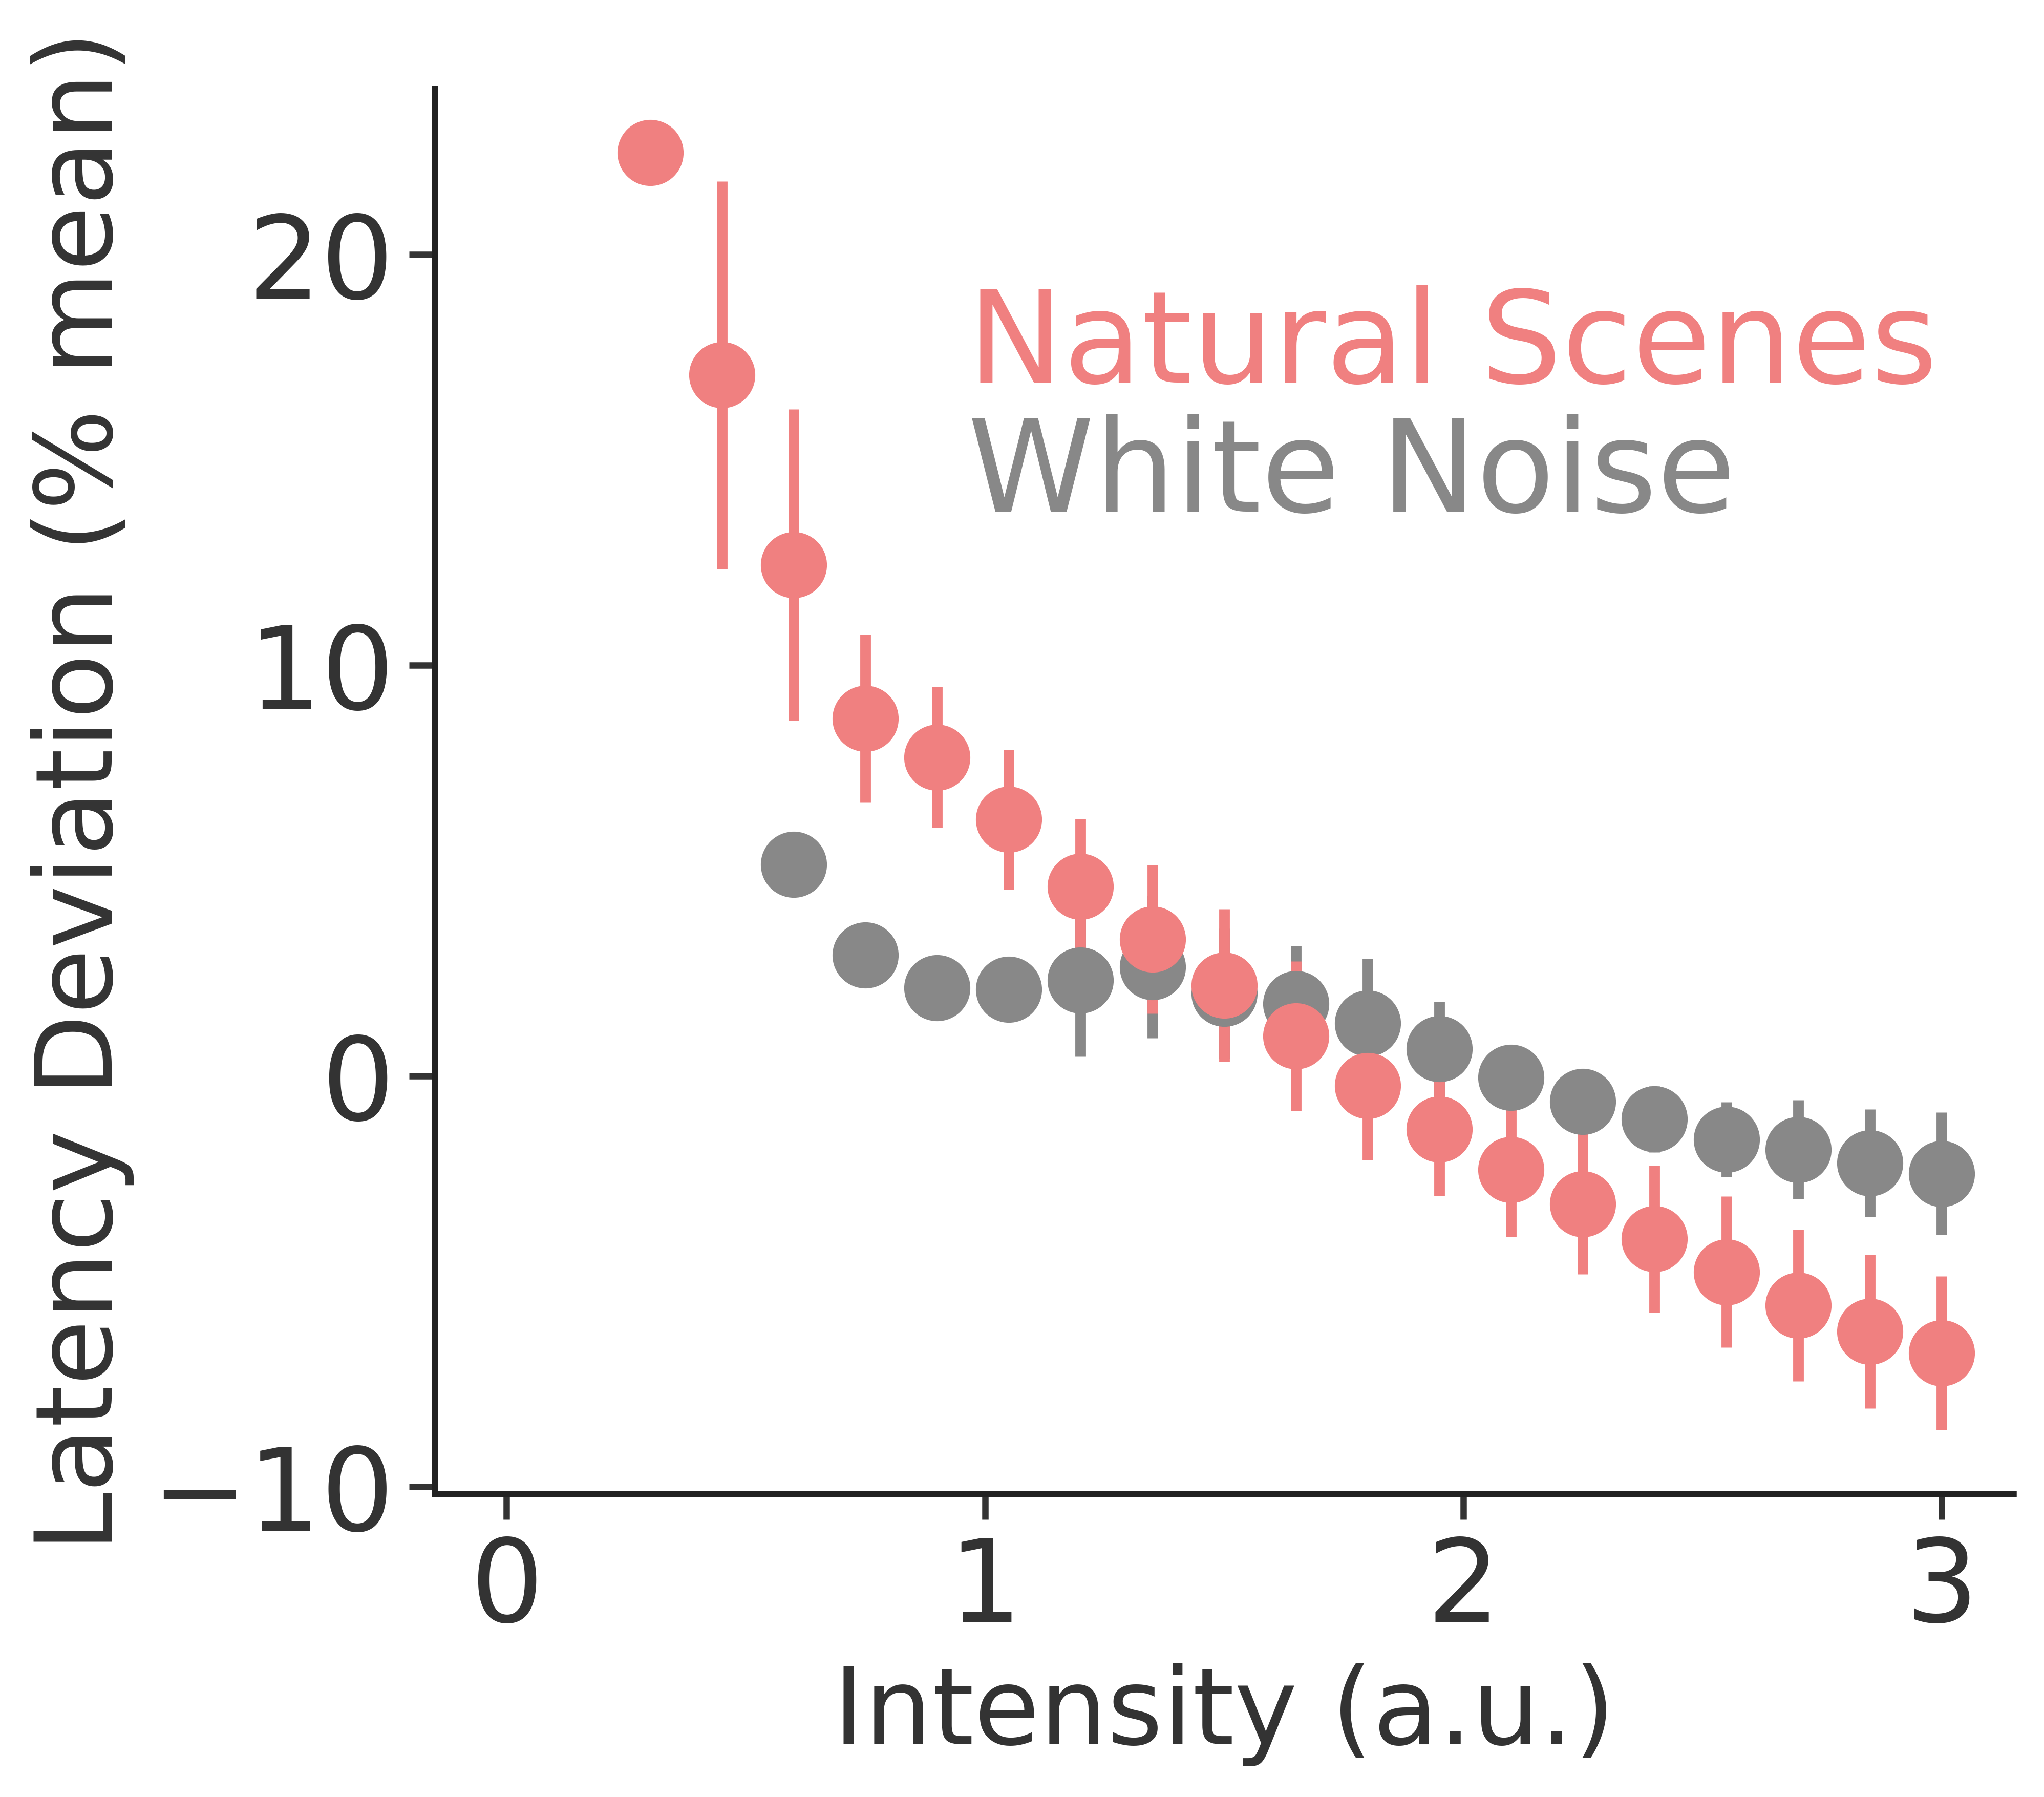

In [9]:
fontsize = 25
titlesize = 35
ticksize = 27
binwidth = 1
alpha = 0.8

fig = plt.figure(figsize=(7, 6))
ax = plt.gca()

#ax.plot(-intensities, wn_plot, 'o', color=whit_color)
#ax.plot(-intensities, ns_plot, 'o', color=nat_color)

ax.errorbar(-intensities, wn_plot, yerr=wn_errs, fmt='o', color=whit_color)
ax.errorbar(-intensities, ns_plot, yerr=ns_errs, fmt='o', color=nat_color)
#ax.set_xlabel('Intensity',fontsize=40)
#ax.set_ylabel('Latency',fontsize=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.locator_params(nbins=4)
ax.tick_params(axis='both', which='major', labelsize=ticksize)

# Add labels.
plt.xlabel('Intensity (a.u.)',fontsize=fontsize)
if rescaling=="global": 
    plt.ylabel('Mean Latency Units (ms)',fontsize=fontsize)
elif rescaling == "model":
    plt.ylabel('Mean Latency Units (ms)',fontsize=fontsize)
elif rescaling == "percent":
    plt.ylabel('Latency Deviation (% mean)',fontsize=fontsize)
else:
    plt.ylabel('Normalized Latency (mean=1)',fontsize=fontsize)
    
#ax.xaxis.label.set_color('333333')
#ax.yaxis.label.set_color('333333')

#plt.ylim(70, 100)
#plt.xlim(0, 10.5)
#plt.legend(['White Noise', 'Natural Scenes'],bbox_to_anchor=(.5, 1), loc=2,

ax.annotate('White Noise', xy=(0.45, 0.75), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.45, 0.82), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=nat_color)
            
#l = plt.legend(['White Noise', 'Natural Scenes'], loc='upper right',
#                                                borderaxespad=0.,fontsize=30,
#                                                handletextpad=0,
#                                                handlelength=0,
#                                                handleheight=0,
#                                                markerscale=0,
#                                                frameon=False)
#colors = [whit_color, nat_color]
#for color,text in zip(colors, l.get_texts()):
#    text.set_color(color)
plt.tight_layout()

folder_name = "lat_encs"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, prename+"latency_encoding_latencies_scaletype{}".format(rescaling))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

if rescaling == "global":
    captions[folder_name][save_name.split("/")[-1]] = """
    Scaled values of the model latencies by the intensity of the stimulus. Errorbars are standard
    error over individual model cells. Latency values for each cell were first divided by the mean
    of that cell's latencies for all intensities and then multiplied by the mean of all cell
    latencies combined.
    """
elif rescaling == "none":
    captions[folder_name][save_name.split("/")[-1]] = """
    Scaled values of the model latencies vs the intensity of the stimulus. Errorbars are standard
    error over individual model cells. Latency values for each cell were divided by the mean
    of that cell's latencies for all intensities.
    """
elif rescaling == "percent":
    captions[folder_name][save_name.split("/")[-1]] = """
    Shows percent deviation from the mean of the model latencies against the intensity of the stimulus.
    Errorbars are standard error over individual model cells. Percent deviations were calculated as
    deviations of each individual cell from the mean of that cell's latencies for all intensities.
    """

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


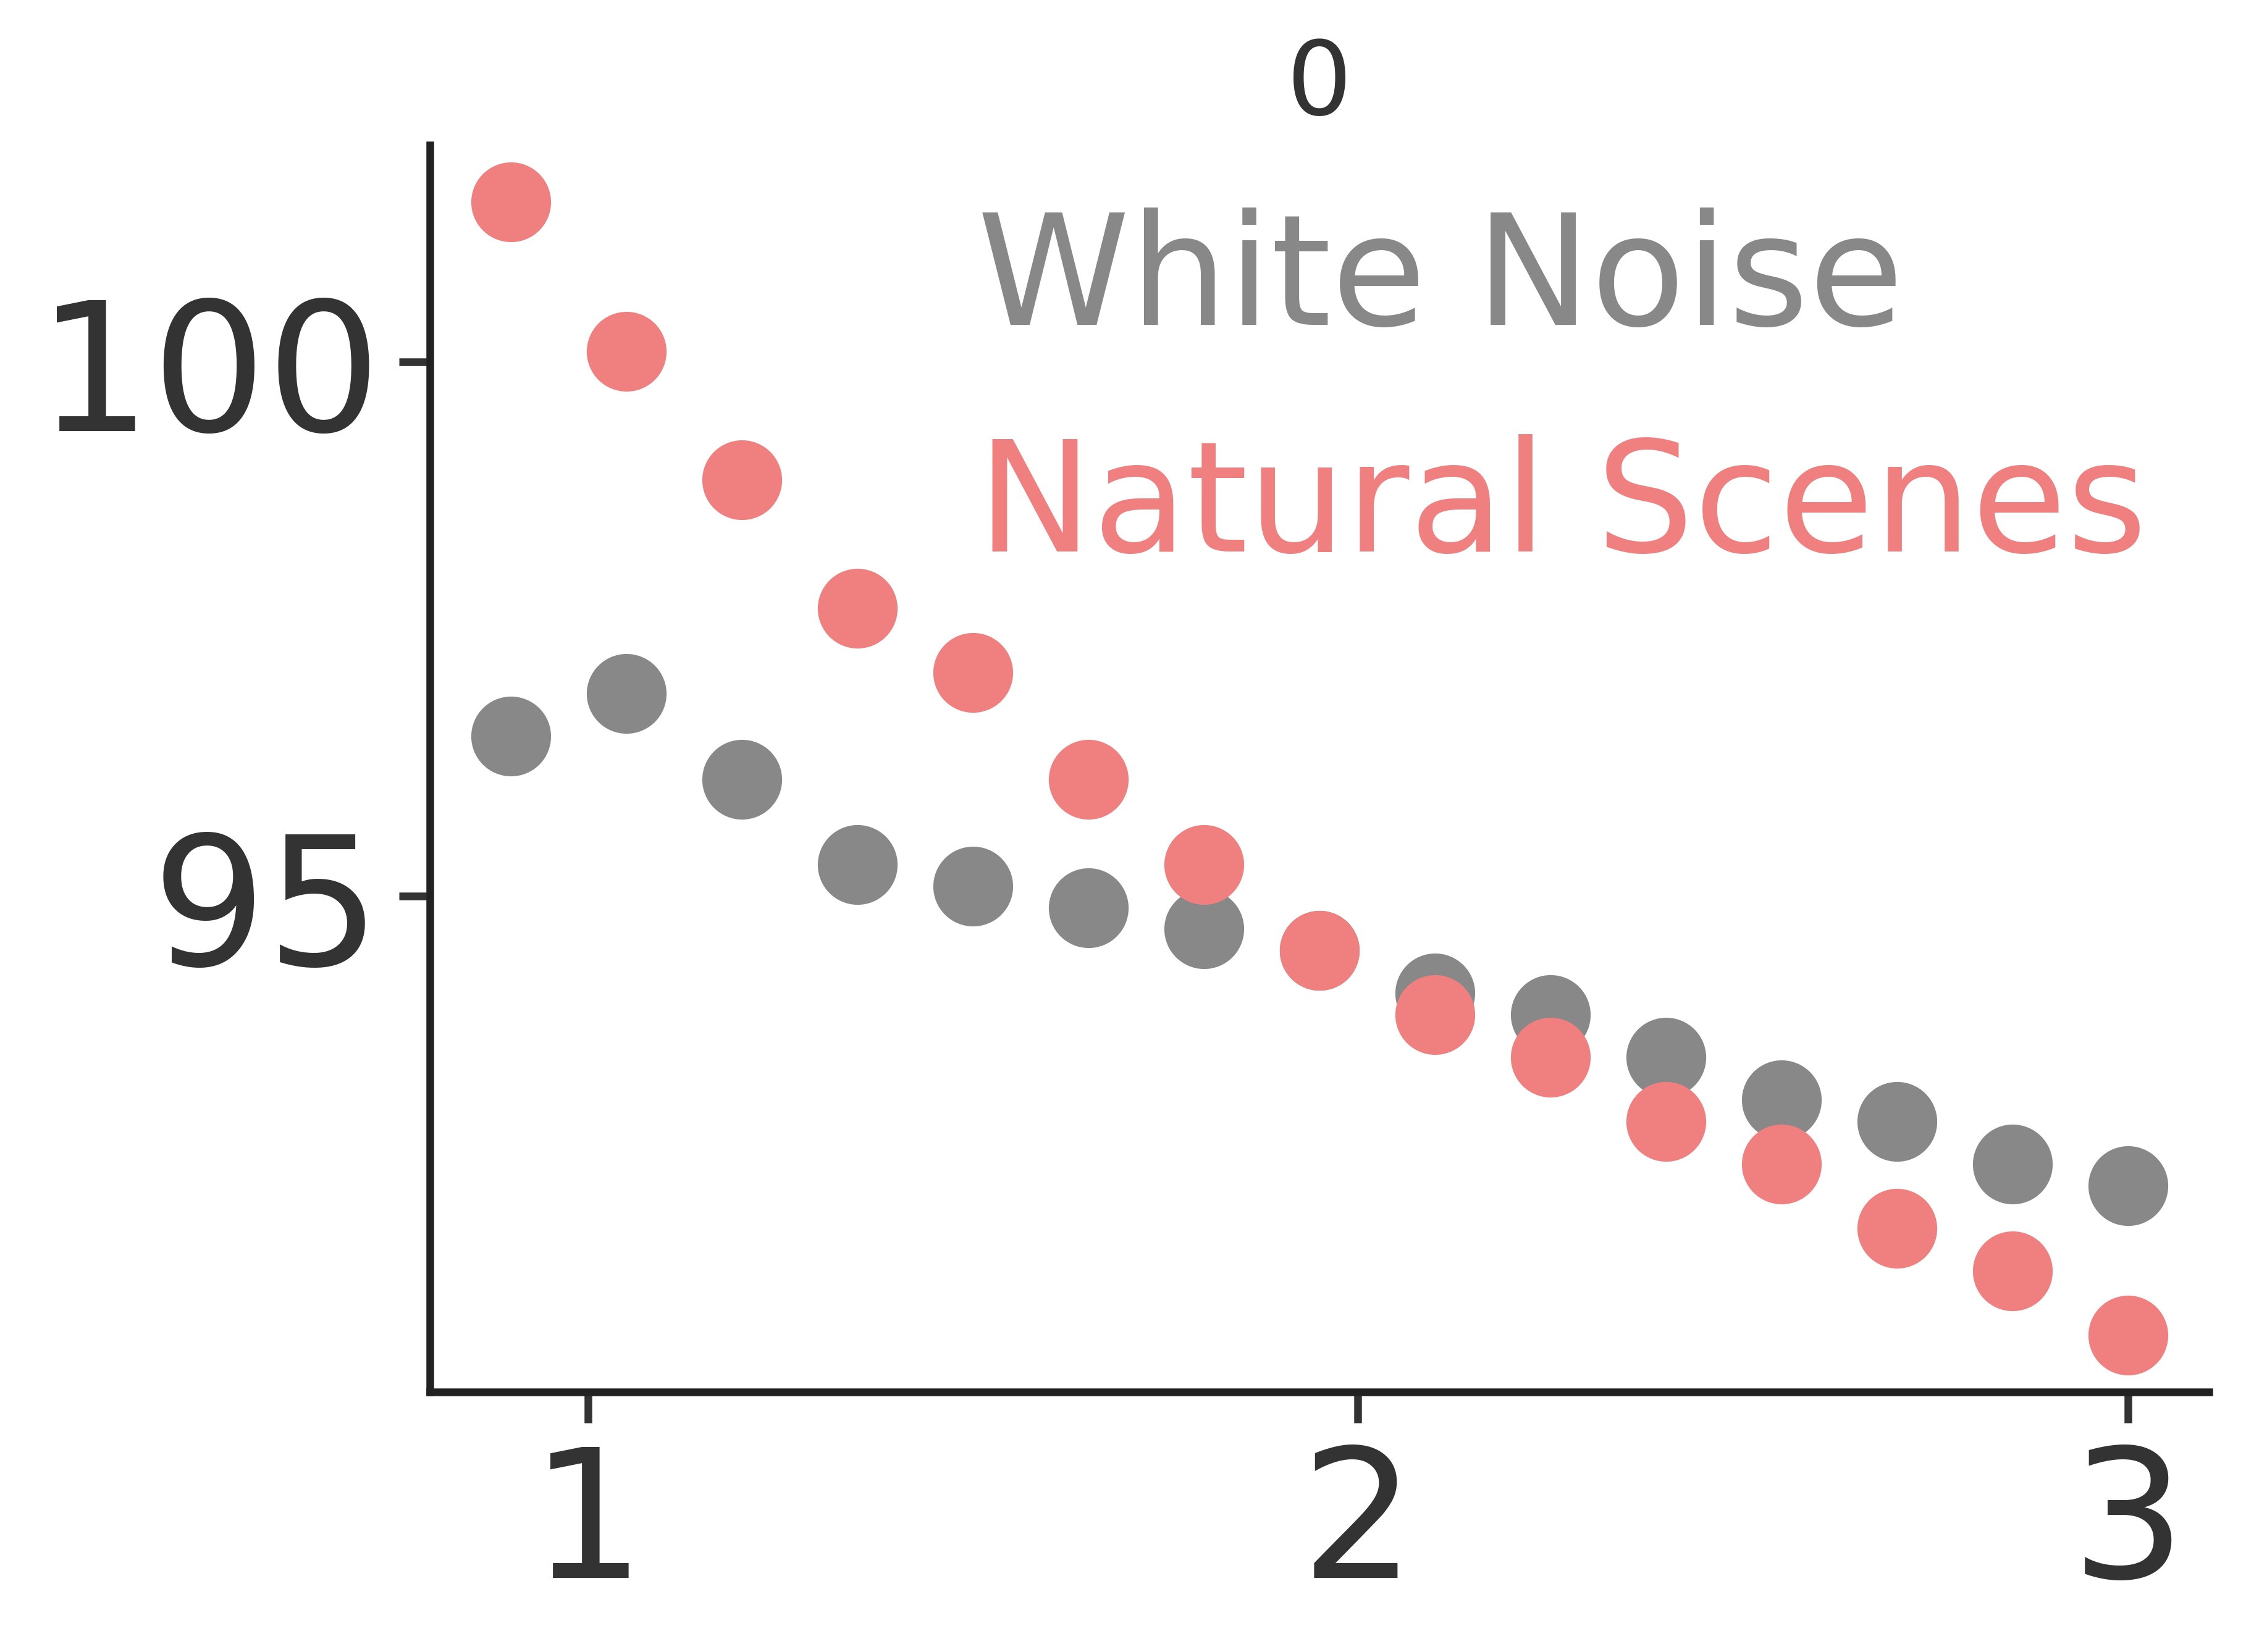

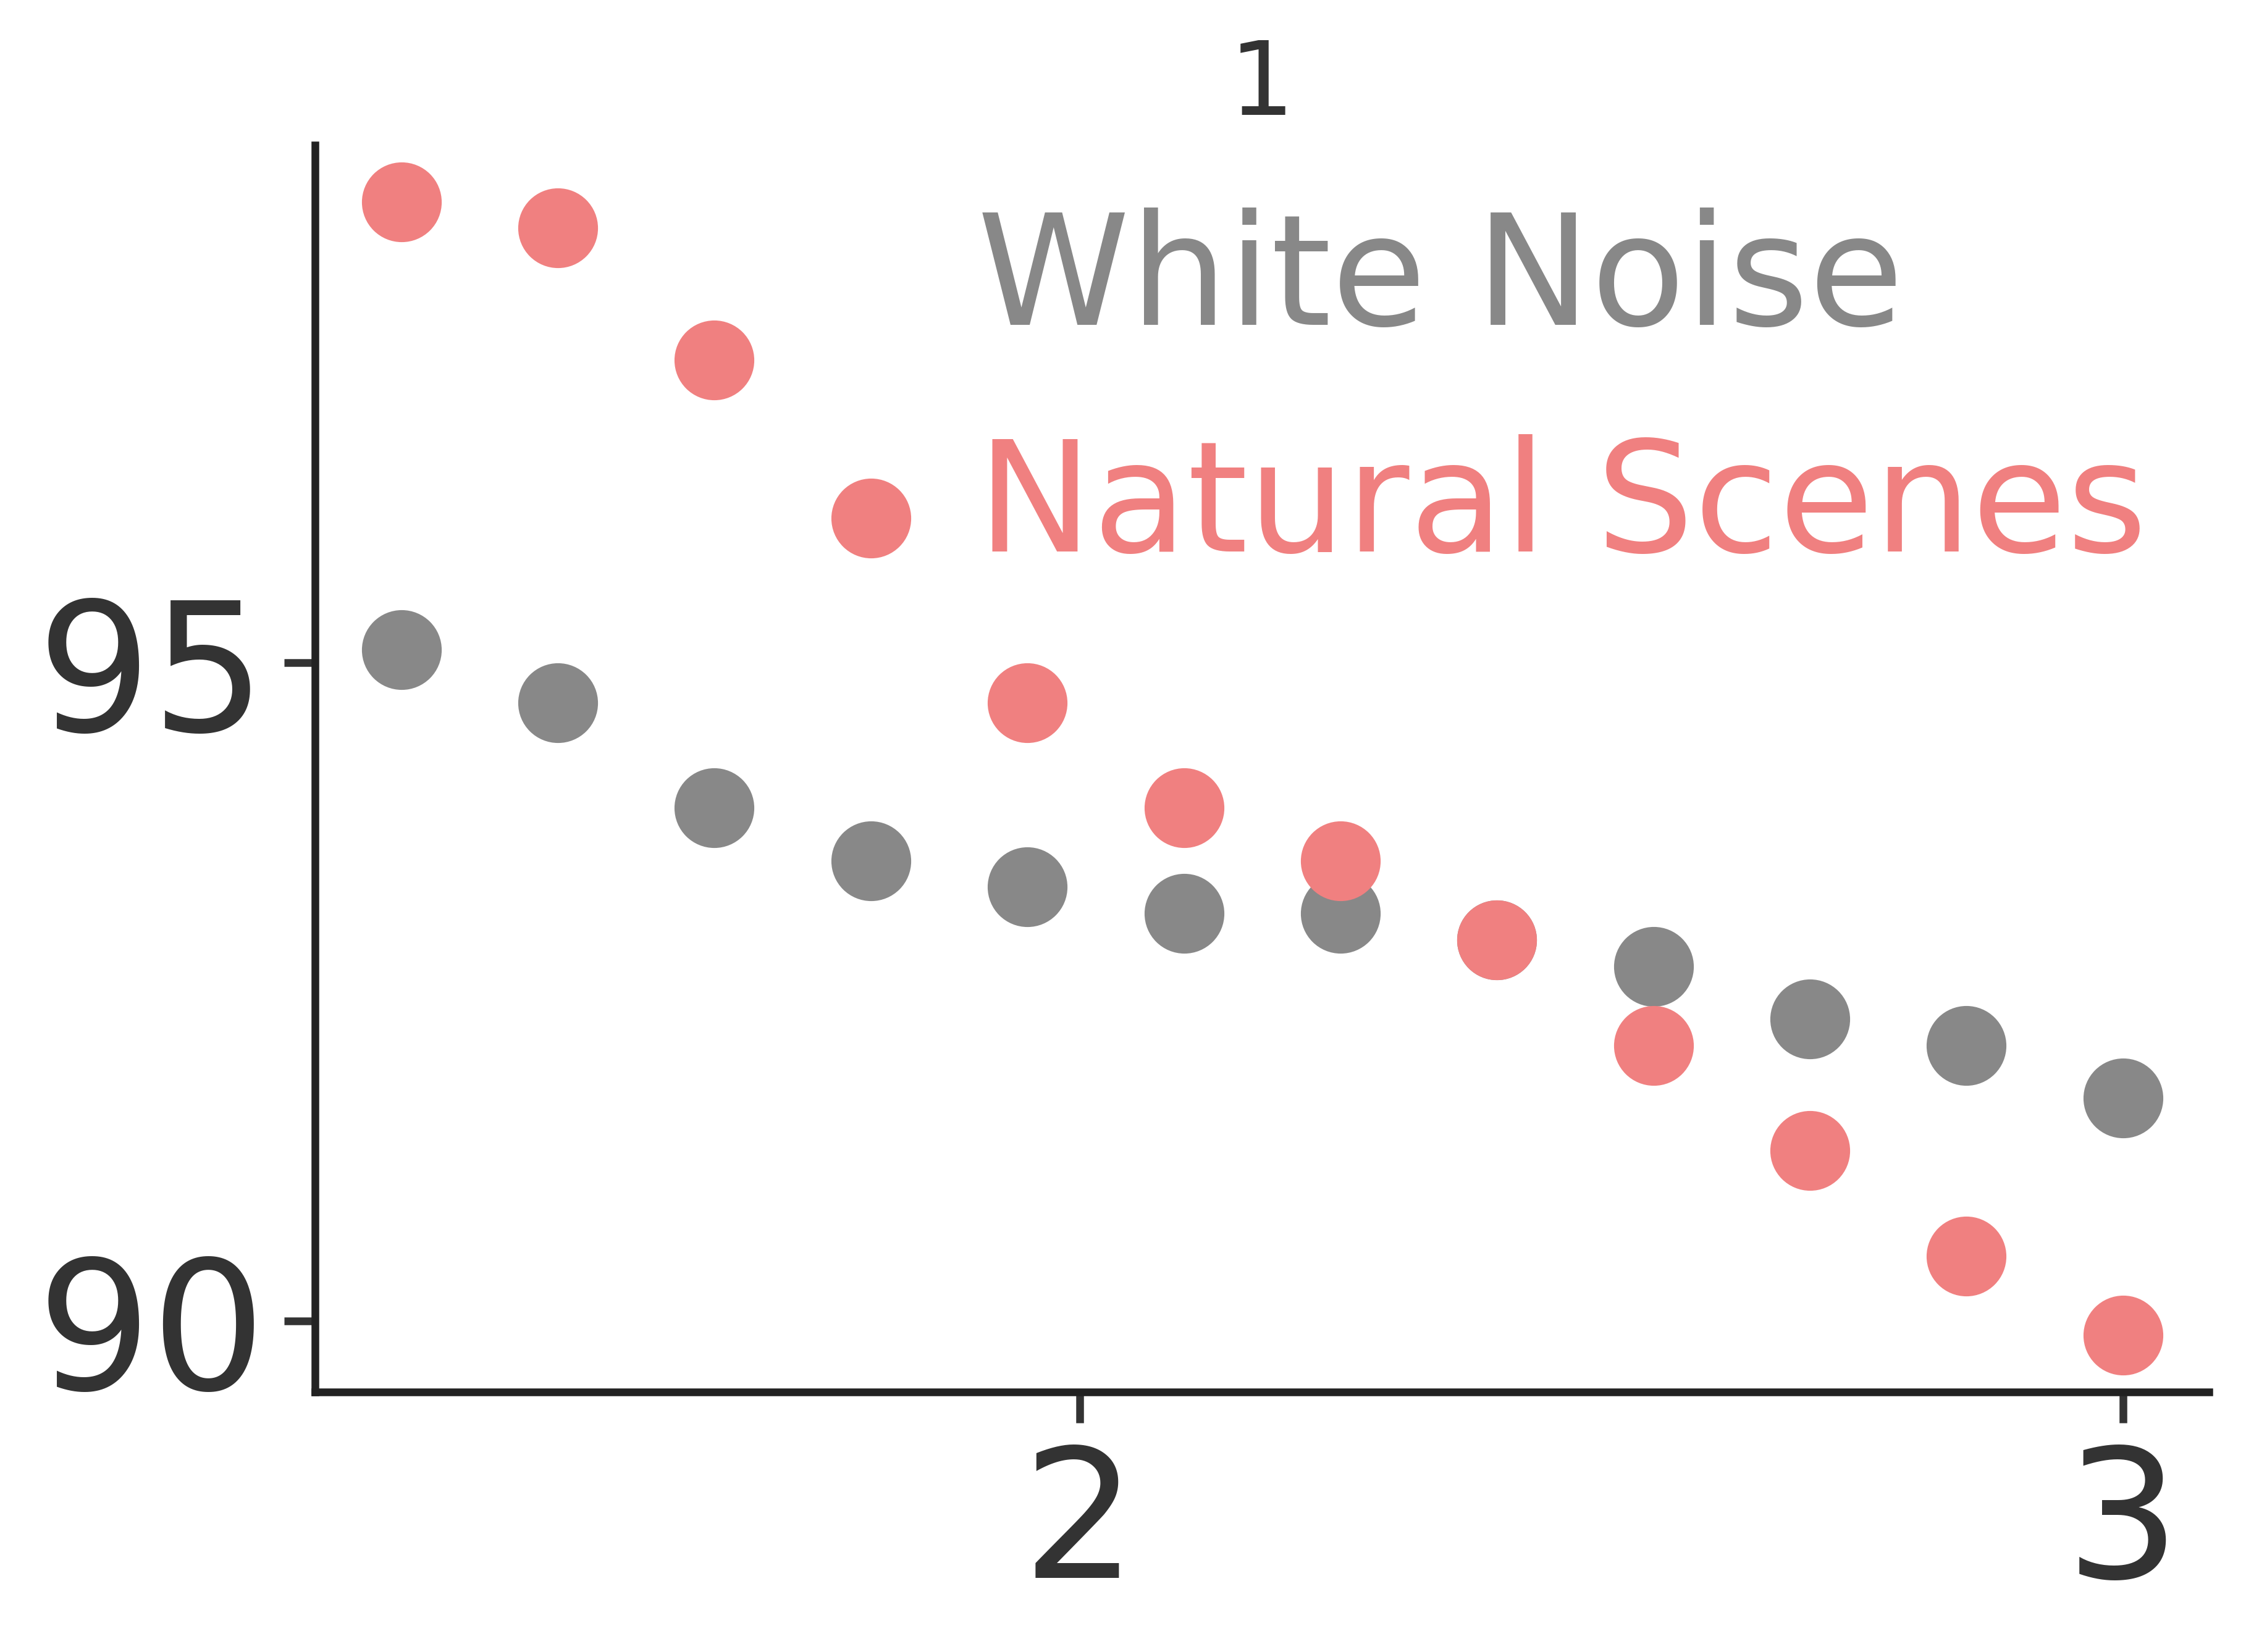

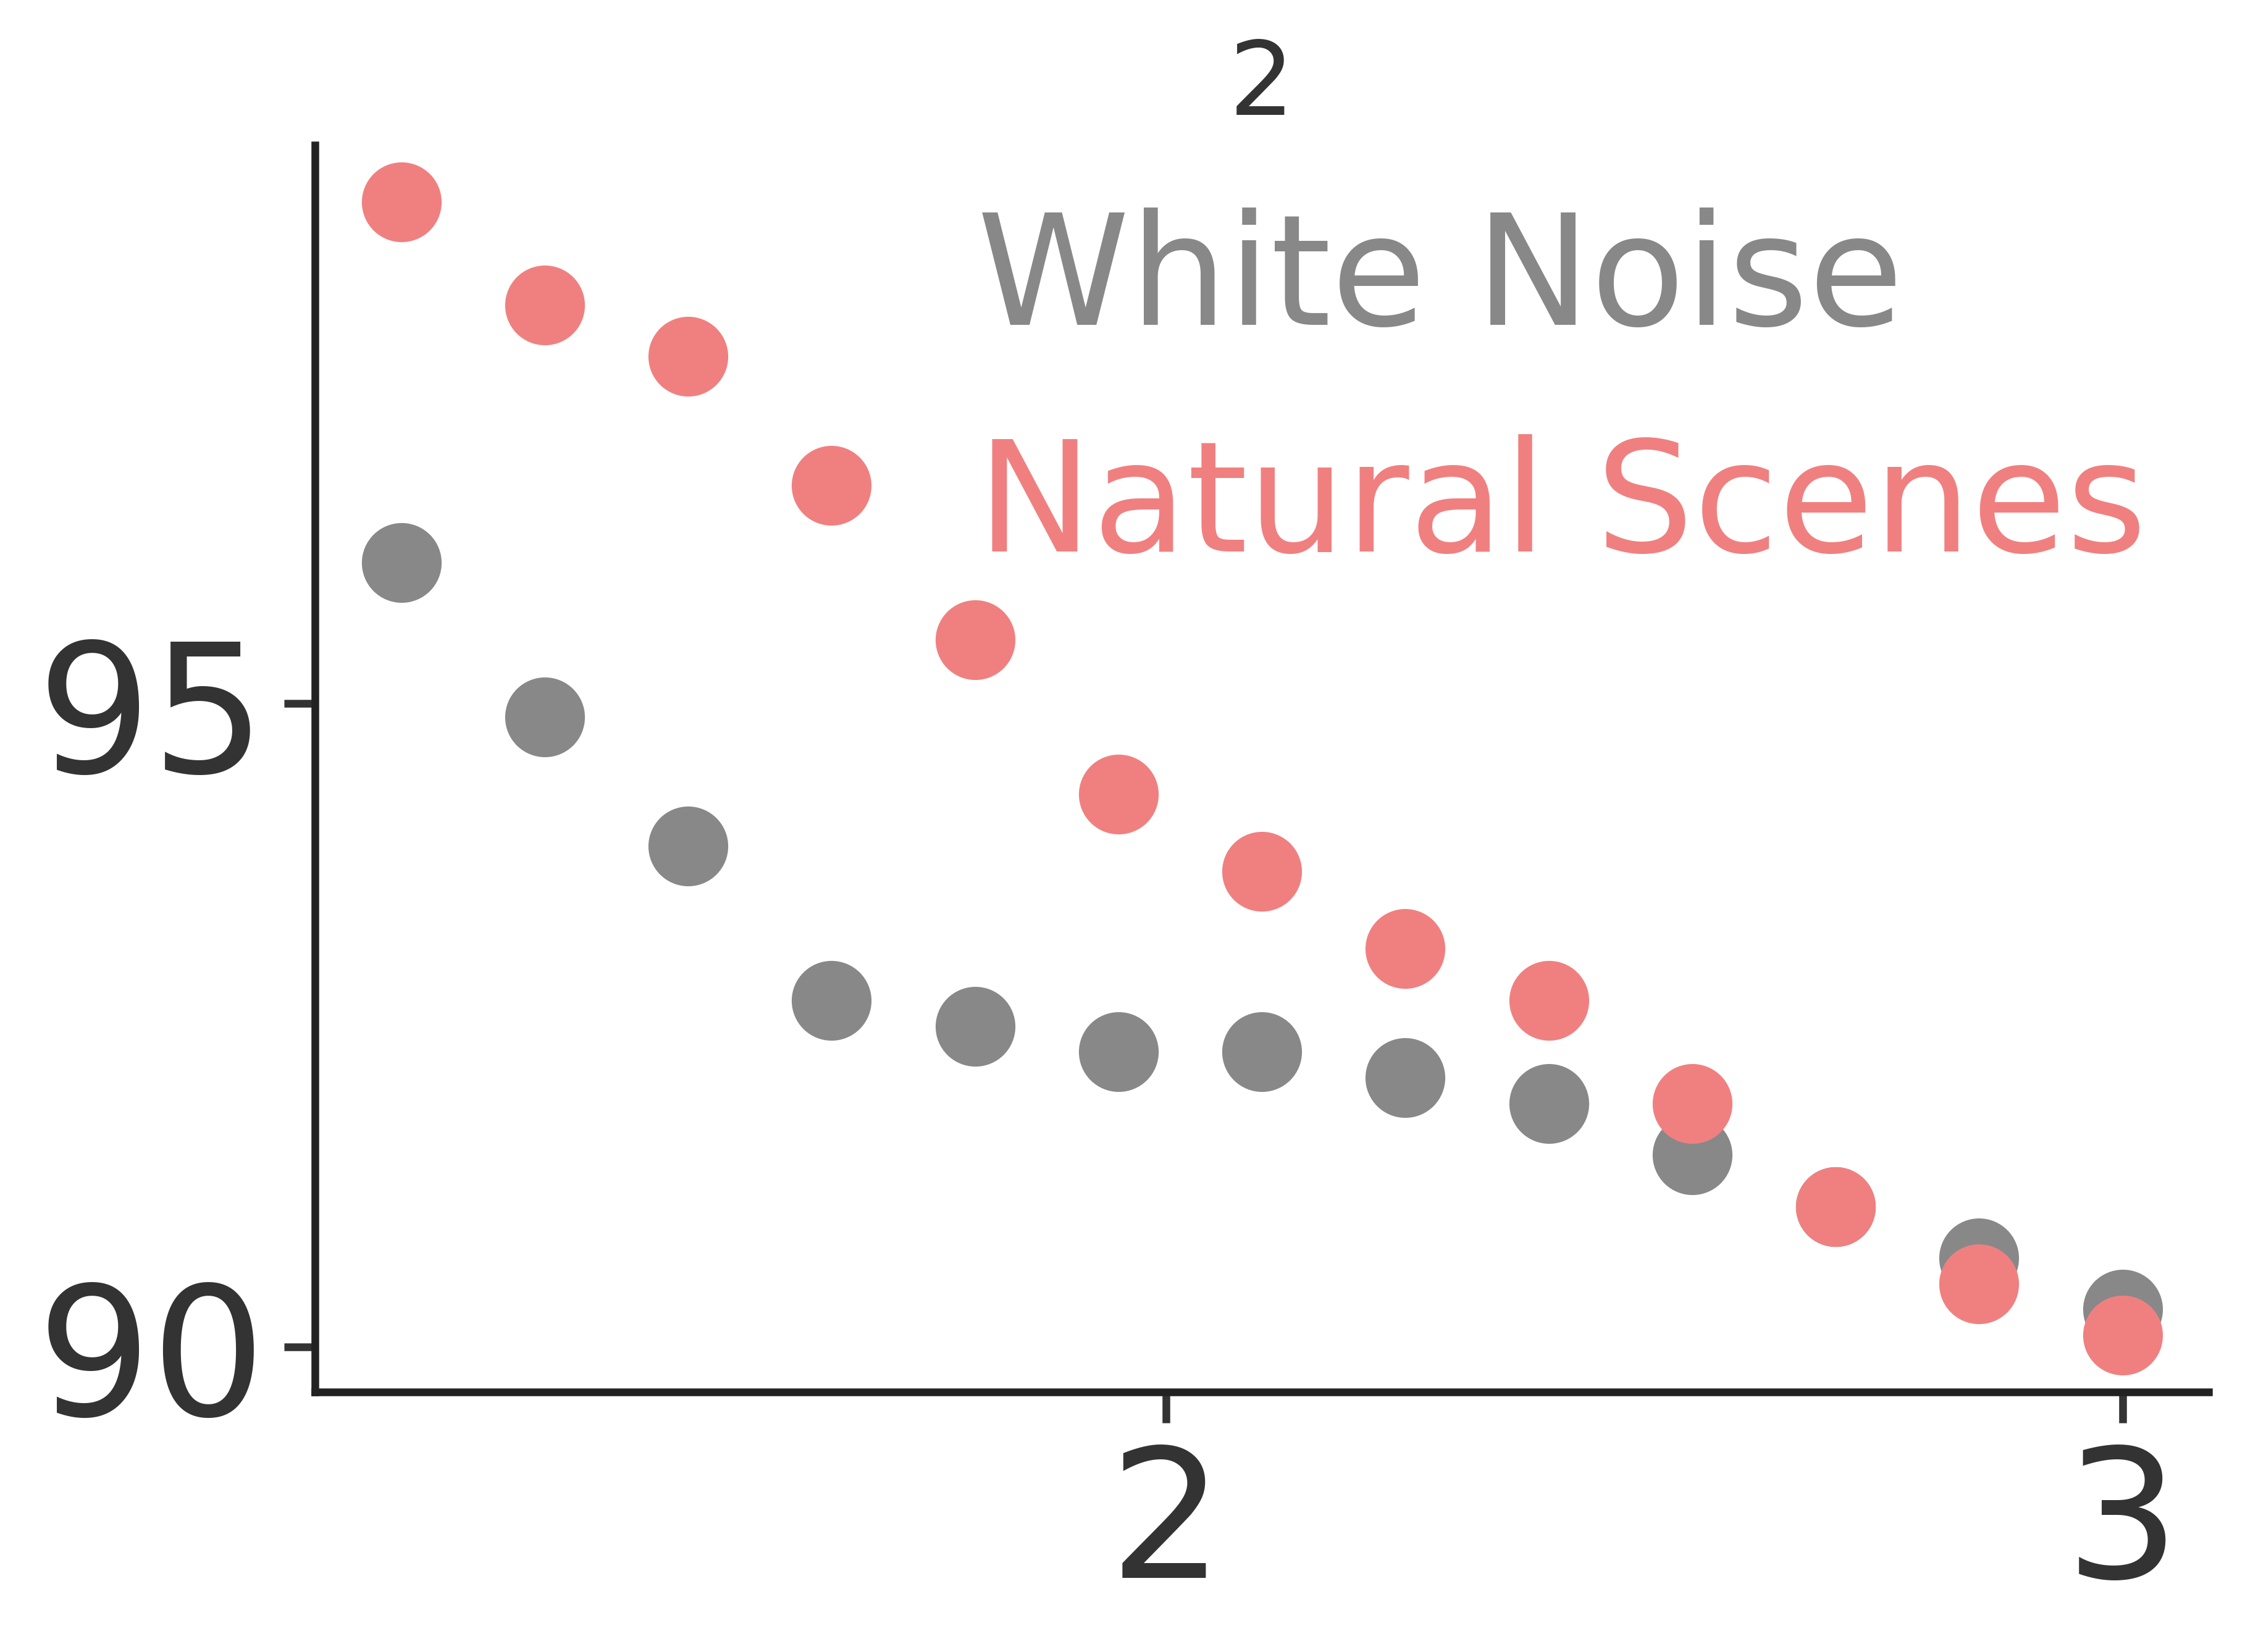

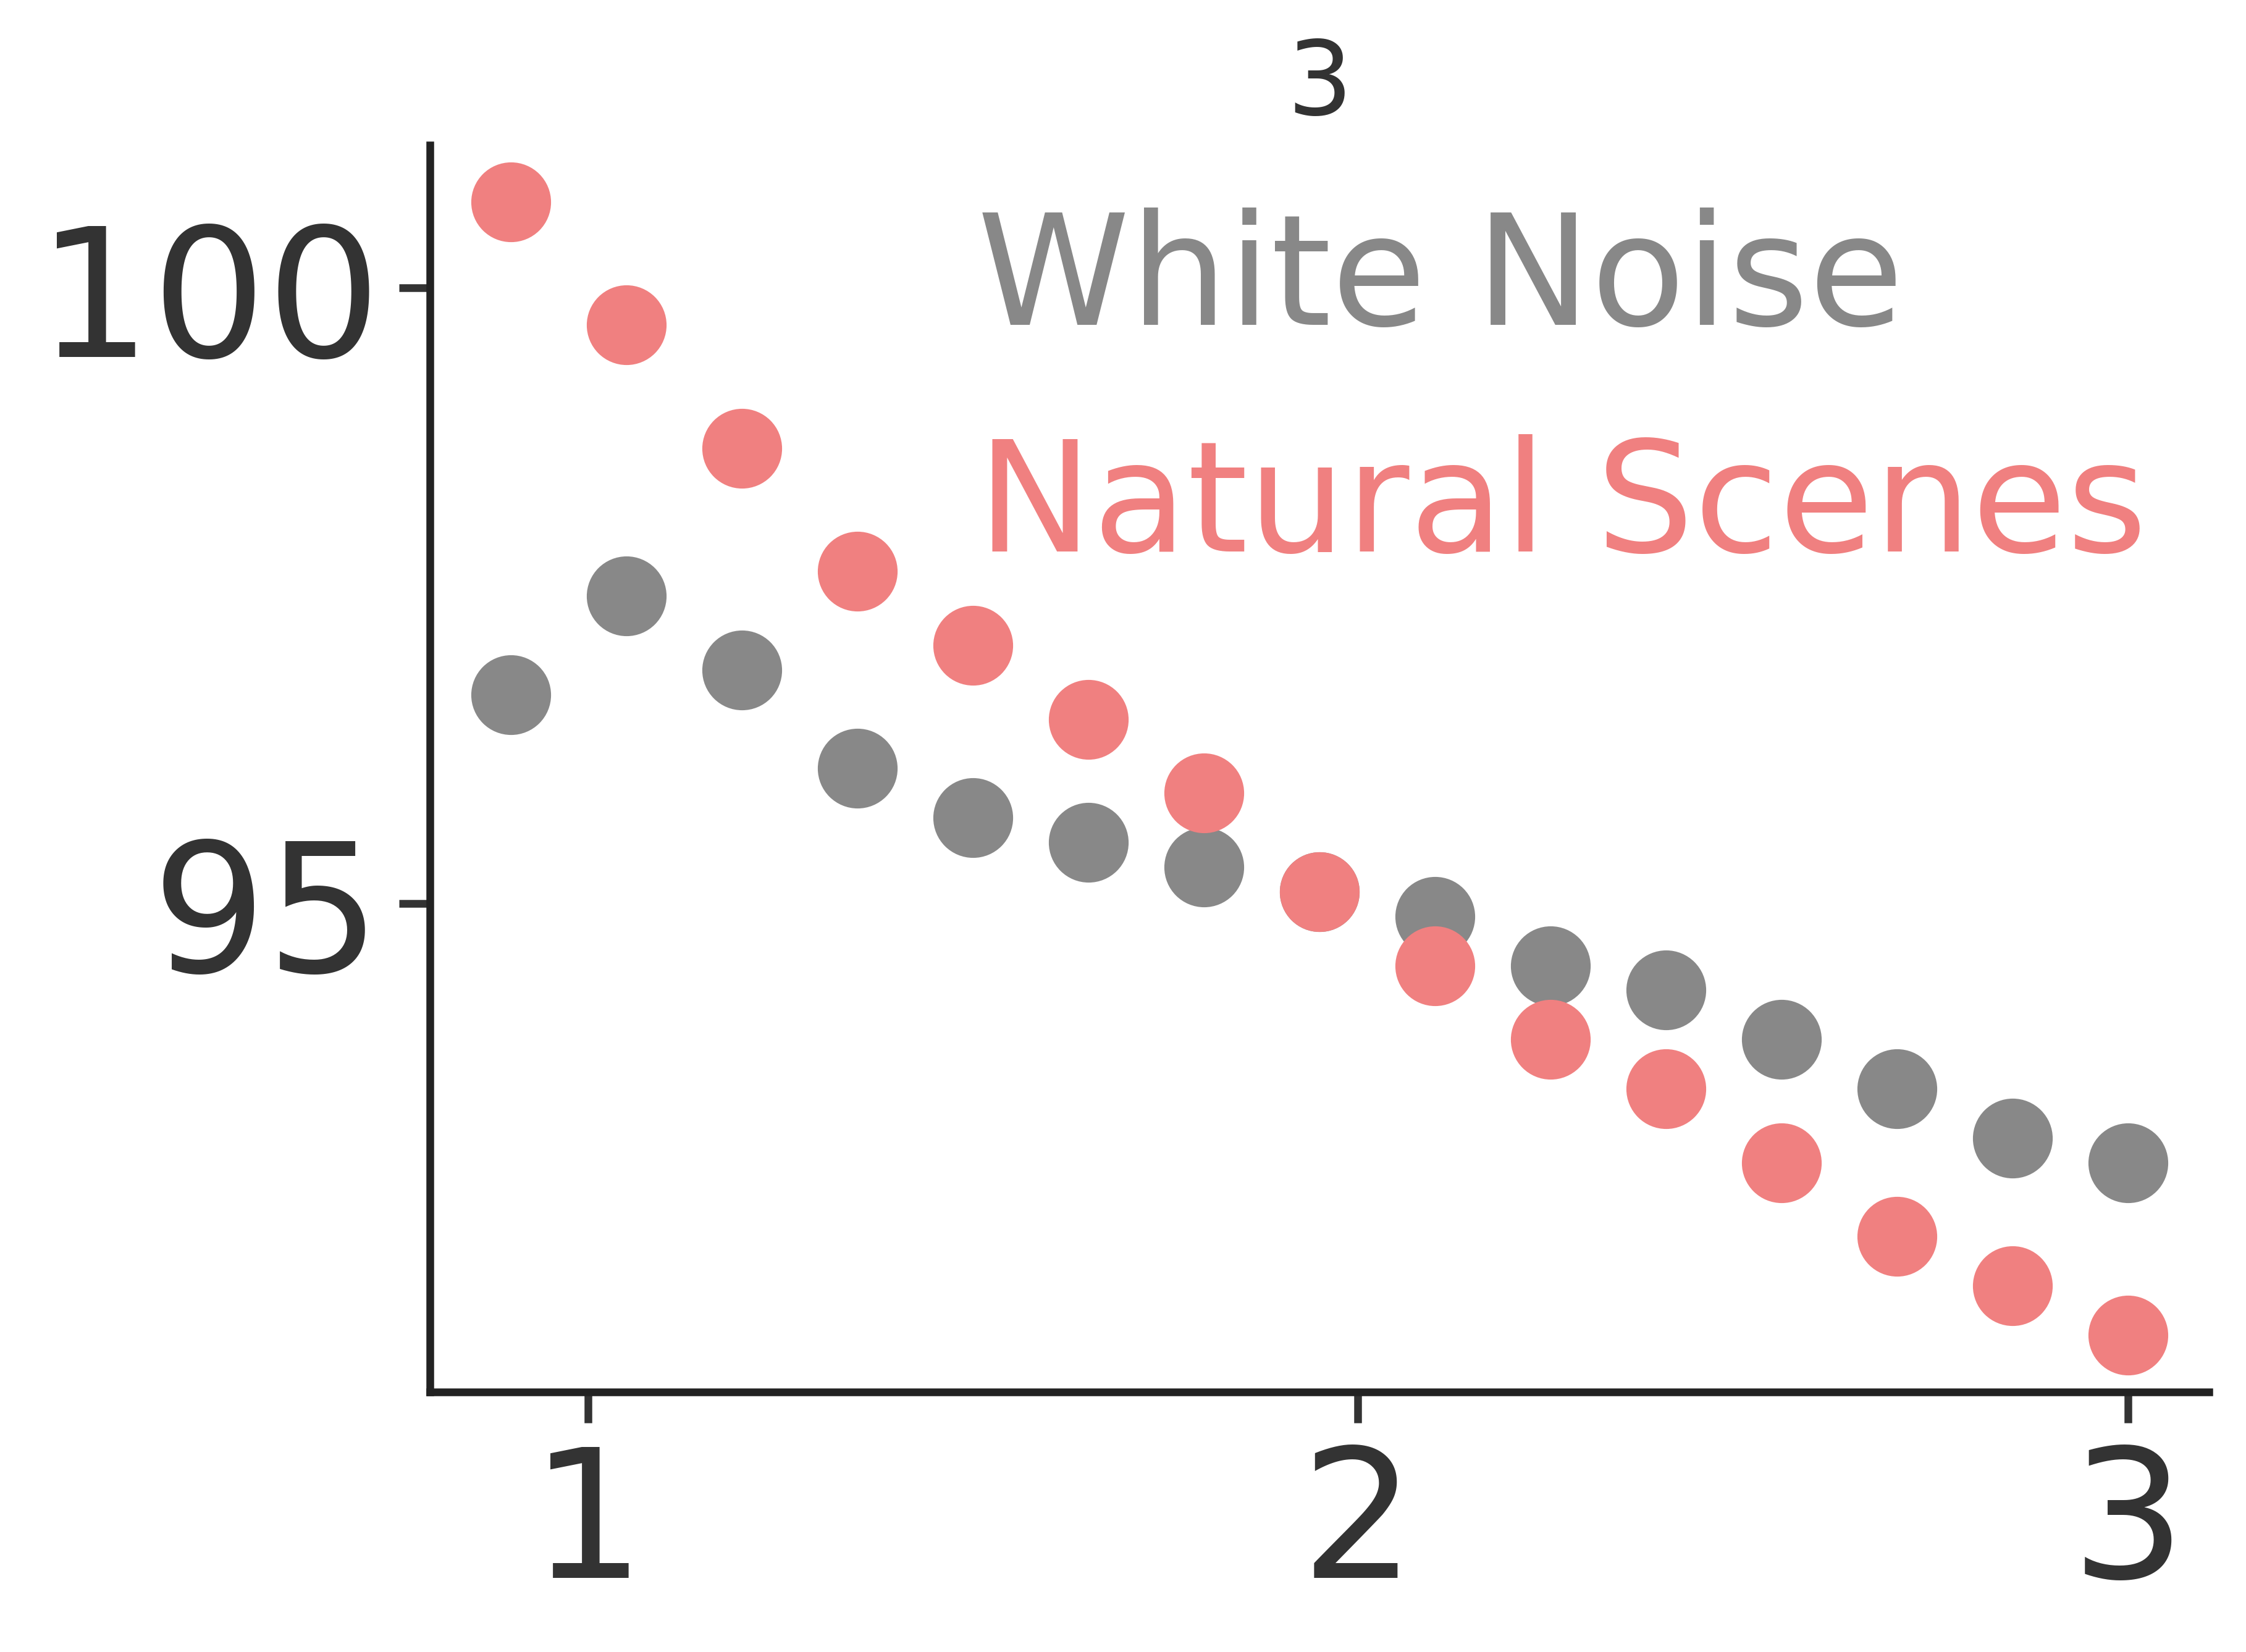

In [10]:
# Panel 3: Latency vs. Intensity
# Make figure.
#plt.style.use('deepretina.mplstyle')
#fig = plt.figure(figsize=(7, 6))
for ci in range(4):
    #if ci==cii:
    if True:
        fig = plt.figure()
        ax = plt.gca()
        idx = wn_lats[ci]==wn_lats[ci]
        wn_plot = wn_lats[ci][idx]
        ns_plot = ns_lats[ci][idx]
        ax.plot(-intensities[idx], wn_plot, 'o', color=whit_color)
        ax.plot(-intensities[idx], ns_plot, 'o', color=nat_color)
        #ax.set_xlabel('Intensity',fontsize=40)
        #ax.set_ylabel('Latency',fontsize=40)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.locator_params(nbins=4)
        ax.tick_params(axis='both', which='major', labelsize=35)
        plt.title(ci)
        
        # Add labels.
        #plt.xlabel('Intensity (a.u.)',fontsize=20)
        #plt.ylabel('Latency (ms)',fontsize=20)
        #plt.ylim(70, 100)
        #plt.xlim(0, 10.5)
        #plt.legend(['White Noise', 'Natural Scenes'],bbox_to_anchor=(.5, 1), loc=2,
        l = plt.legend(['White Noise', 'Natural Scenes'], loc='upper right',
                                                        borderaxespad=0.,fontsize=30,
                                                        handletextpad=-2.0, handlelength=0,
                                                        markerscale=0,
                                                        frameon=False)
        colors = [whit_color, nat_color]
        for color,text in zip(colors, l.get_texts()):
            text.set_color(color)
        plt.locator_params(nbins=3)
        plt.tight_layout()
        
        folder_name = "lat_encs"
        folder = os.path.join(savefolder, folder_name)
        if not os.path.exists(folder):
            os.makedirs(folder)
        save_name = os.path.join(folder, prename+"individual_latency_encoding_latencies_cellidx{}_unscaled".format(ci))
        plt.savefig(save_name + ".png", bbox_inches="tight")
        plt.savefig(save_name + ".pdf", bbox_inches="tight")
        plt.show()
        
        captions[folder_name][save_name.split("/")[-1]] = """
        Unscaled values of the model latencies by the intensity of the stimulus for individual cells.
        """
        
        with open(os.path.join(folder, caption_file), "w") as f:
            for k,v in captions[folder_name].items():
                f.write(k+":\n")
                f.write(v+"\n\n")
    

In [11]:
# Drop Cells with None Slopes
ns_slopes = []
wn_slopes = []
for i in range(len(fits["ns"])):
    if not(rescaling == "global" or rescaling == "model"):
        n = scaled_fits["ns"][i].slope
        w = scaled_fits["wn"][i].slope
    else:
        n = fits["ns"][i].slope
        w = fits["wn"][i].slope
    if w is None or n is None: continue
    ns_slopes.append(n)
    wn_slopes.append(w)


df = pd.DataFrame({
    "White Noise": wn_slopes,
    "Natural Scenes": ns_slopes,
    "Cell Idx": np.arange(len(ns_slopes)),
})
df = pd.melt(df, id_vars="Cell Idx", value_vars=["White Noise", "Natural Scenes"], var_name="Stim Type", value_name="Slope")
df.head()
    

Cell Idx    Stim Type     Slope
0         0  White Noise -2.221414
1         1  White Noise -1.932904
2         2  White Noise -2.854764
3         3  White Noise -2.141252
4         4  White Noise -1.619443

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


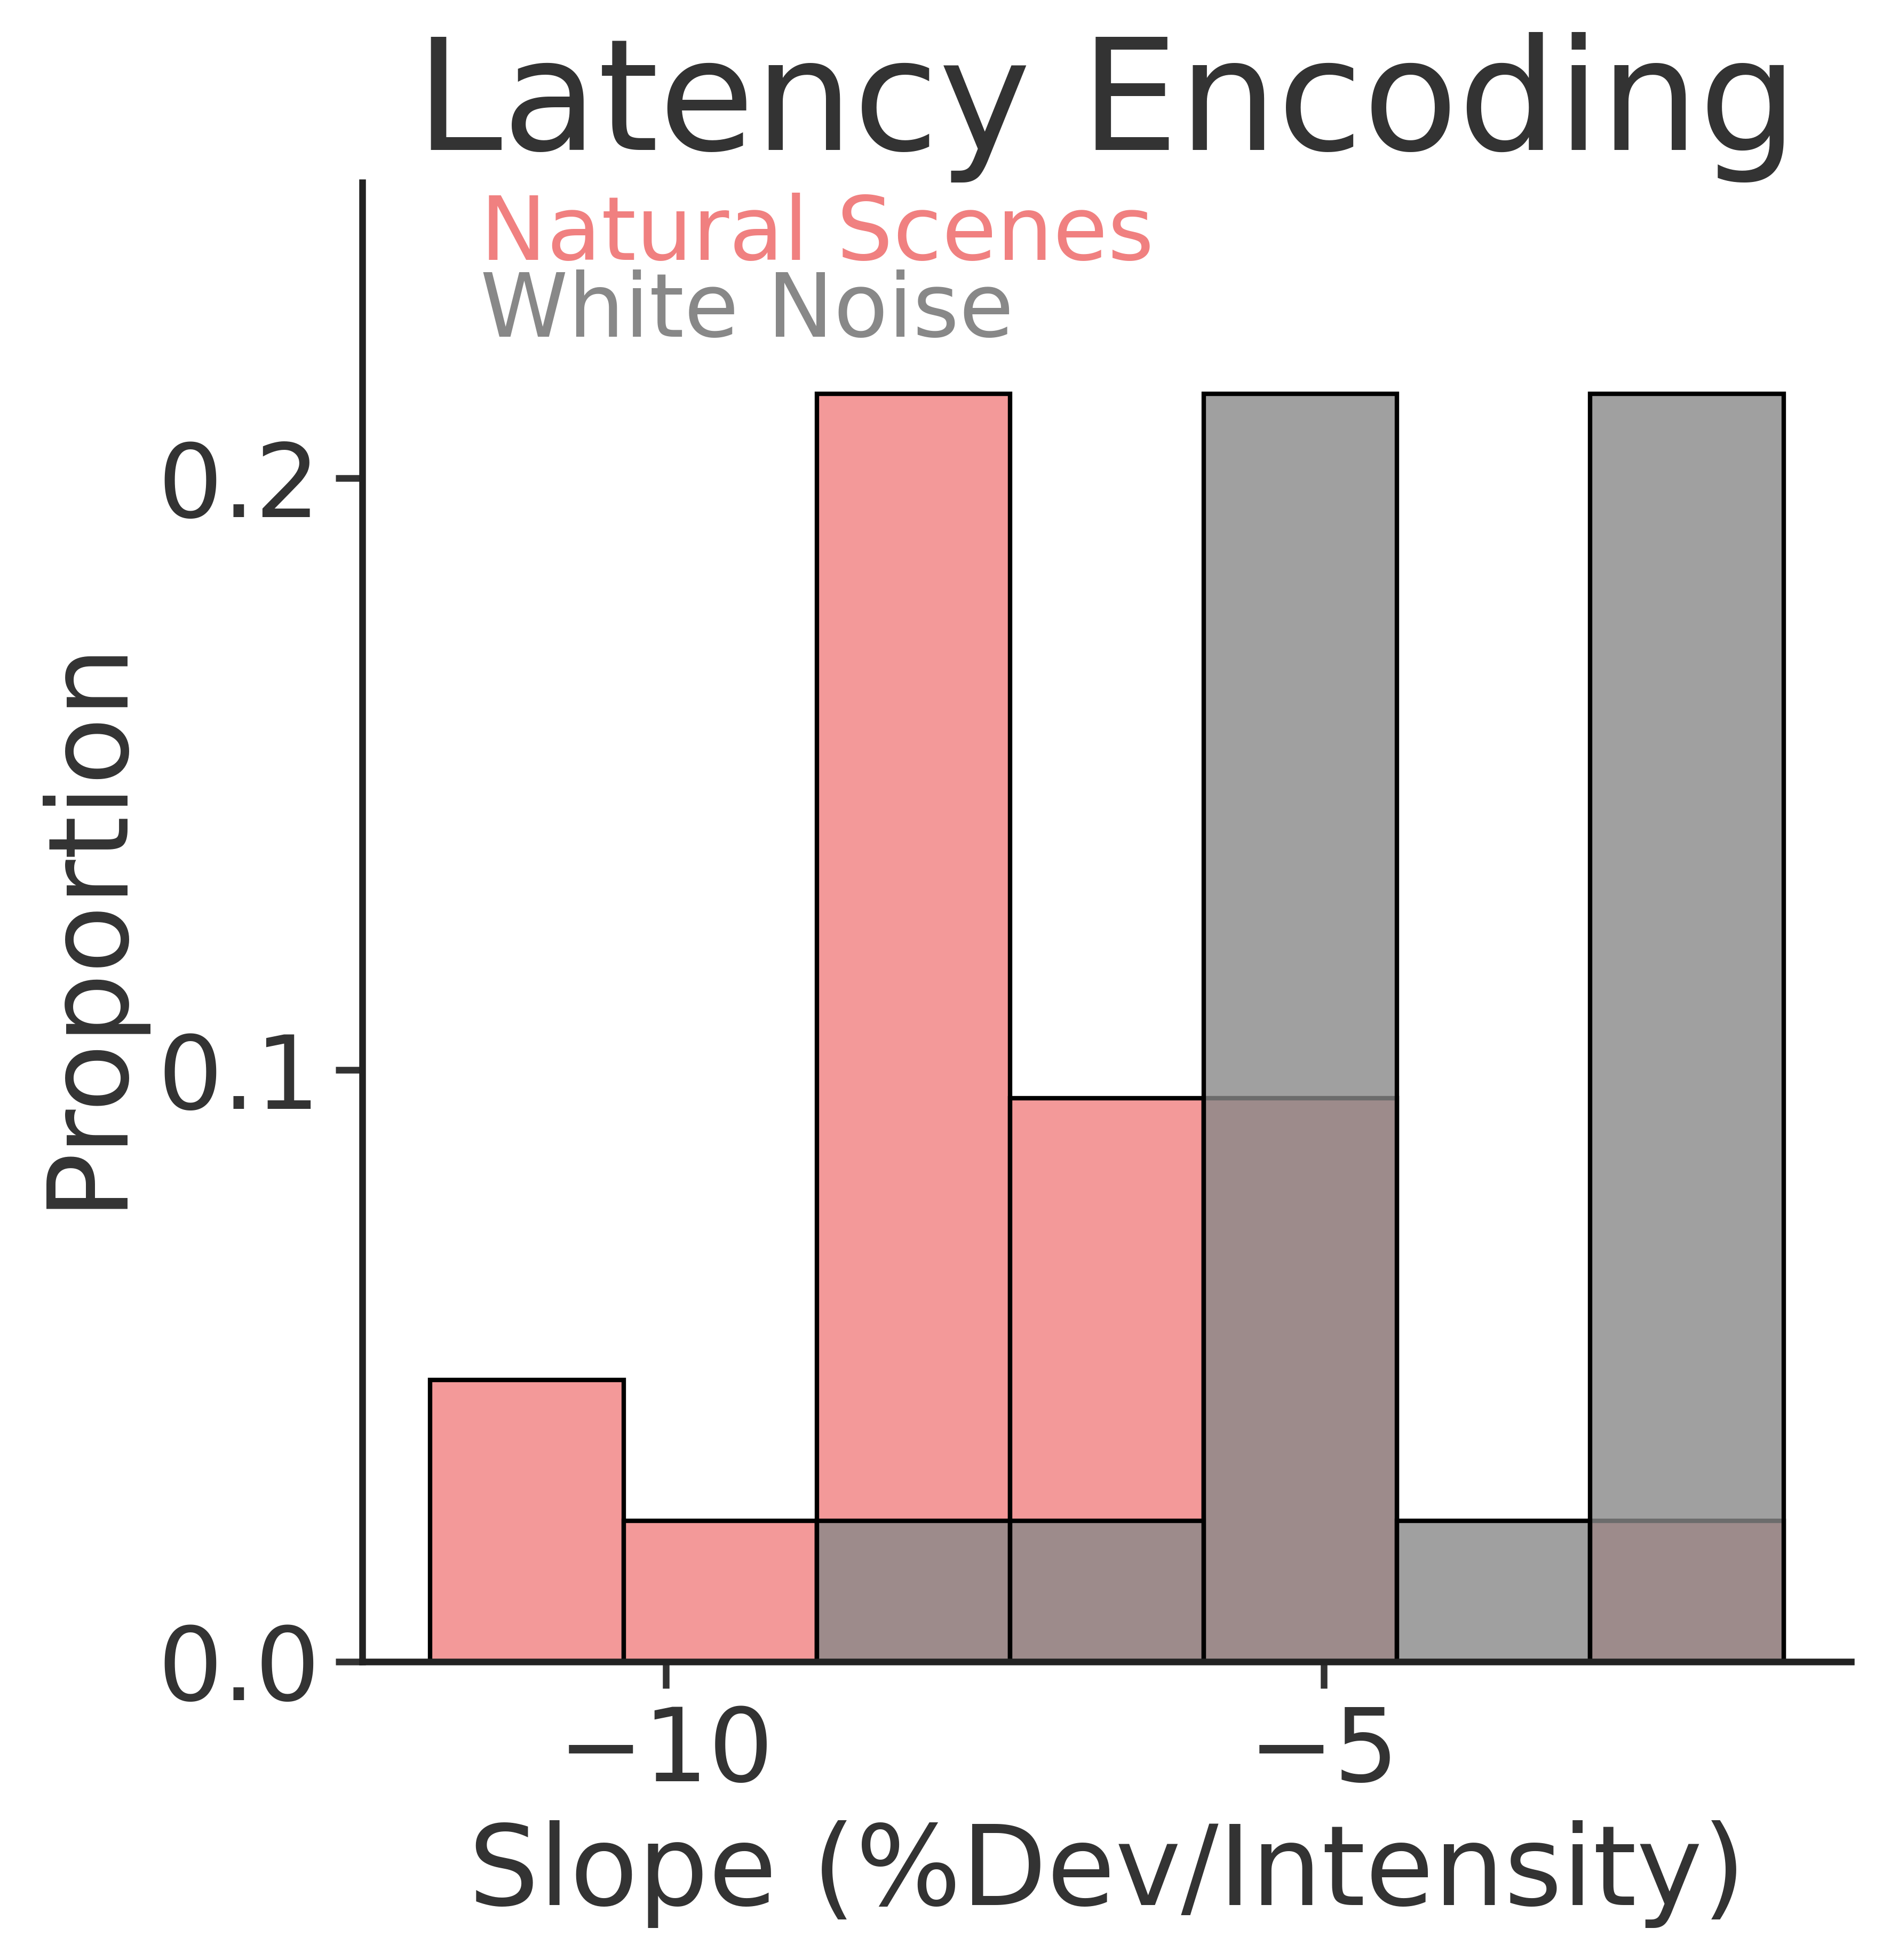

In [12]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
alpha = 0.8

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.histplot(x="Slope", data=df, stat="proportion", hue="Stim Type", ax=ax,
             palette={"White Noise": whit_color, "Natural Scenes": nat_color}, alpha=alpha)
#yticks = [i/10 for i in range(0, int(ylim[1]*10)+1, 3)]
#plt.yticks(yticks, fontsize=ticksize)
#plt.xticks([-8, -4, 0], fontsize=ticksize)
ylim = [0,0.25]
plt.ylim(ylim)
plt.ylabel("Proportion", fontsize=fontsize)
if rescaling == "percent":
    xlabel = "Slope (%Dev/Intensity)"
elif rescaling == "none":
    xlabel = "Slope (Normed Latency/Intensity)"
elif rescaling == "global" or rescaling=="model":
    xlabel = "Slope (Mean Latency Units/Intensity)"
plt.xlabel(xlabel, fontsize=fontsize)
plt.title("Latency Encoding", fontsize=titlesize)
plt.legend().set_visible(False)
px = 0.25
py = 0.88
ax.annotate('White Noise', xy=(px, py), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            #bbox={"alpha": 0.5, "facecolor": "w"},
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(px, py+0.04), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            #bbox={"alpha": 0.5, "facecolor": "w"},
            color=nat_color)
            
plt.locator_params(nbins=3)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "lat_encs"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}latency_enc_slope_hist_rescaling{}".format(prename, rescaling))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

if rescaling == "percent":
    captions[folder_name][save_name.split("/")[-1]] = """
    Histogram of the slope of the latency percent deviations over the intensity of the stimulus.
    Errorbars are standard error over individual model cells. Percent deviations were calculated as
    deviations of each individual cell from the mean of that cell's latencies for all intensities.
    """
elif rescaling=="none":
    captions[folder_name][save_name.split("/")[-1]] = """
    Histogram of the slope of the normalized latencies over the intensity of the stimulus.
    Errorbars are standard error over individual model cells. Normalized latencies were calculated as
    the latency of each individual cell divided by the mean of that cell's latencies for all intensities.
    """
elif rescaling=="global" or rescaling=="model":
    captions[folder_name][save_name.split("/")[-1]] = """
    Histogram of the slope of the latencies vs the intensity of the stimulus.
    Latency values for each cell were first divided by the mean of that cell's latencies for all
    intensities and then multiplied by the mean of all cell latencies combined. This was meant
    to give a sense of latency scale while preserving the trend of each cell.
    """

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

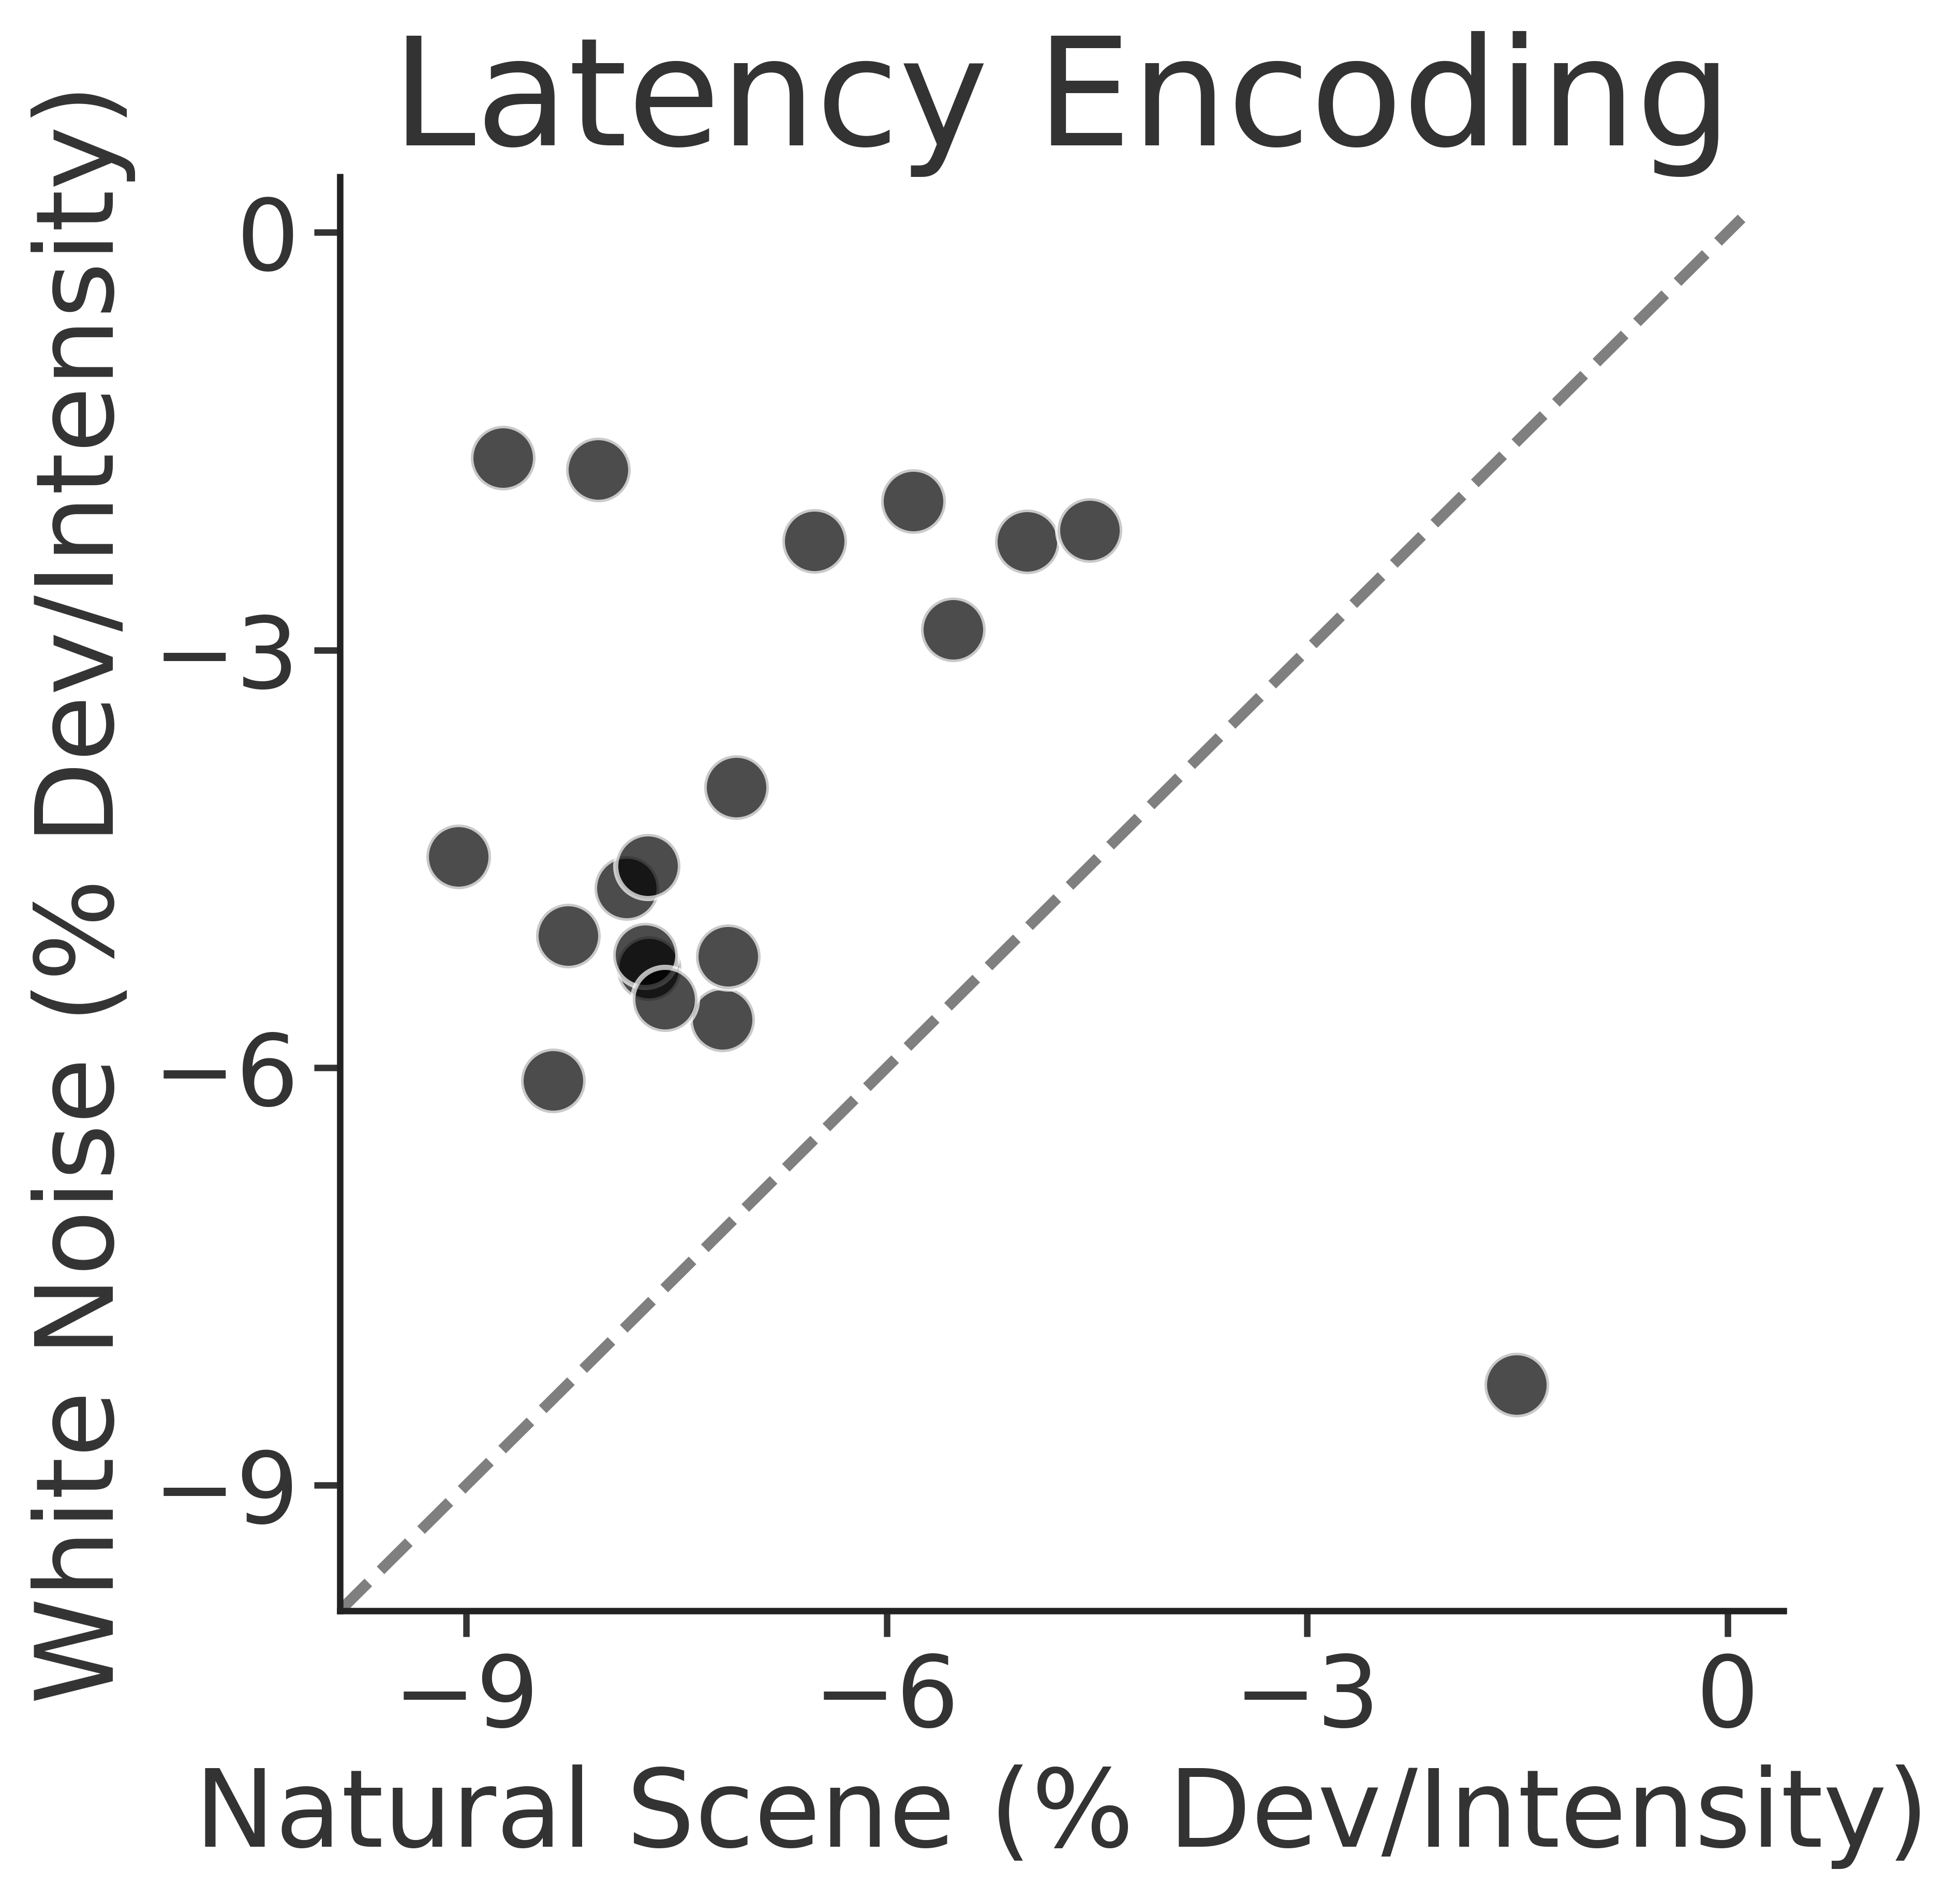

In [13]:
alpha = 0.7

x = []
y = []
for w,n in zip(wn_slopes, ns_slopes):
    if w is None or n is None: continue
    x.append(n)
    y.append(w)

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x,y, ax=ax, alpha=alpha, color="black")
ylim = [0,0.42]
yticks = [i/10 for i in range(int(ylim[1]*10)+1)]
ticks = [-9,-6,-3,0]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [-9.9, 0.4]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.arange(lim[0], lim[1]), np.arange(lim[0], lim[1]), "--k", alpha=0.5)
if rescaling == "percent":
    units = "(% Dev/Intensity)"
elif rescaling == "none":
    units = "(Normed Latency/Intensity)"
elif rescaling == "global" or rescaling=="model":
    units = "(Mean Latency Units/Intensity)"
plt.ylabel("White Noise "+units, fontsize=fontsize)
plt.xlabel("Natural Scene "+units, fontsize=fontsize)
plt.title("Latency Encoding", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "lat_encs"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}latency_enc_slope_scatter_rescaling{}".format(prename, rescaling))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

if rescaling == "percent":
    captions[folder_name][save_name.split("/")[-1]] = """
    Scatterplot of the White Noise models' vs the Natural Scene models' slope of the latency percent
    deviations over the intensity of the stimulus. Percent deviations were calculated as
    deviations of each individual cell from the mean of that cell's latencies for all intensities.
    """
elif rescaling=="none":
    captions[folder_name][save_name.split("/")[-1]] = """
    Scatterplot of the White Noise models' vs the Natural Scene models' slope of the normalized
    latencies over the intensity of the stimulus. Normalized latencies were calculated as
    the latency of each individual cell divided by the mean of that cell's latencies for all intensities.
    """
elif rescaling=="global" or rescaling=="model":
    captions[folder_name][save_name.split("/")[-1]] = """
    Scatter plot of the white noise and natural scene differences for the same cell in latency encoding.
    The y-axis is the latency encoding of the whitenoise model for a single cell, the x-axis is the
    latency encoding of the naturalscene model for the same cell.
    Latency values for each cell were first divided by the mean of that cell's latencies for all
    intensities and then multiplied by the mean of all cell latencies combined. We then
    fit a linear line to the Latency vs Intensity for each cell to calculate the latency encoding value.
    """


with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

# Fast Contrast Adaptation

In [16]:
DATAFILE = prepath+'fast_contrast_adaptation-allmodels.h5'

In [17]:
def signfix(taus):
    """Corrects sign of a temporal kernel."""
    new_taus = []
    for tau in taus:
        if np.mean(tau[25:]) > 0:
            new_taus.append(-tau)
        else:
            new_taus.append(tau)
    return np.stack(new_taus)


def cadapt(contrasts, mdls, ncells):
    """Runs contrast adaptation analysis."""
    celldata = []
    for mdl, nc in zip(mdls, ncells):
        if nc == "all": nc = mdl.n_units
        mdl.cuda()
        mdl.eval()
        for ci in range(nc):
            taus = []
            for c in tqdm(contrasts):
                X = stimuli.concat(stimuli.white(200, nx=50, contrast=c))
                X = torch.FloatTensor(X).cuda()
                X.requires_grad = True
                pred = mdl(X)[:,ci]
                pred.sum().backward()
                g = X.grad.data.detach().cpu().numpy()
                rf = g.mean(axis=0)
                _, tau = ft.decompose(rf)
                taus.append(tau)
            celldata.append(signfix(np.stack(taus)))
        mdl.cpu()
    return np.stack(celldata)


def center_of_mass(f, p):
    return np.sum(f * p)

def upsample_single(tau, t, t_us):
    return interp1d(t, tau, kind='cubic')(t_us)


def upsample(taus, t, t_us):
    return np.stack([upsample_single(tau, t, t_us) for tau in taus])


def npower(x):
    """Normalized Fourier power spectrum."""
    amp = np.abs(fft(x))
    power = amp ** 2
    return power / power.max()



def generate_data(min_contrast=0.5, max_contrast=2.0, num_contrasts=4):
    """Generates data for the contrast adaptation figure."""
    contrasts = np.linspace(min_contrast, max_contrast, num_contrasts)
    t = np.linspace(-400, 0, 40)
    t_us = np.linspace(-400, 0, 1000)

    root_dir = '/home/grantsrb/src/torch-deep-retina/models/'
    paths = [
        root_dir+prename+'15-10-07_naturalscene.pt',
        root_dir+prename+'15-11-21a_naturalscene.pt',
        root_dir+prename+'15-11-21b_naturalscene.pt',
    ]
    nats_mdls = [tdr.io.load_model(path) for path in paths]
    nat_adapt = cadapt(contrasts, nats_mdls, ["all" for _ in range(len(nats_mdls))]) # Get temporal kernels
    shape = nat_adapt.shape[:-1]
    nss = upsample(nat_adapt.reshape(np.prod(shape), -1), t, t_us).reshape(*shape, 1000) # Upsample kernels
    Fns = np.stack([npower(ni) for ni in nss])                      # FFT analysis

    paths = [
        root_dir+prename+ '15-10-07_whitenoise.pt',
        root_dir+prename+'15-11-21a_whitenoise.pt',
        root_dir+prename+'15-11-21b_whitenoise.pt',
    ]
    whits_mdls = [tdr.io.load_model(path) for path in paths]
    whit_adapt = cadapt(contrasts, whits_mdls, ["all" for _ in range(len(whits_mdls))])
    shape = whit_adapt.shape[:-1]
    wns = upsample(whit_adapt.reshape(np.prod(shape), -1), t, t_us).reshape(*shape, 1000)
    Fwn = np.stack([npower(ni) for ni in wns])

    freqs = fftfreq(1000, 1e-3 * np.mean(np.diff(t_us)))

    data = {
        'ns': nat_adapt,
        'contrasts': contrasts,
        'nss': nss,
        't': t,
        't_us': t_us,
        'wn': whit_adapt,
        'wns': wns,
        'Fns': Fns,
        'Fwn': Fwn,
        'freqs': freqs,
    }
    dd.io.save(DATAFILE, data)
    return data


In [18]:
plt.style.use('deepretina.mplstyle')
if os.path.exists(DATAFILE):
    data = dd.io.load(DATAFILE)
else:
    data = generate_data()
#data = generate_data()
Fw = data['Fwn']
Fn = data['Fns']
fr = fftfreq(1000, 4e-4)

shape = data["ns"].shape[:-1]
ns_cm = np.zeros(shape)
shape = data["wn"].shape[:-1]
wn_cm = np.zeros(shape)
for ci in range(shape[0]):
    for j in range(shape[1]):
        ns_cm[ci, j] = center_of_mass(fr[:7], Fn[ci, j, :7])
        wn_cm[ci, j] = center_of_mass(fr[:7], Fw[ci, j, :7])

contrasts = data['contrasts']

ns_df = {
    "contrasts": np.tile(contrasts,(ns_cm.shape[0],)),
    "resps": ns_cm.reshape(-1),
    "ci": np.repeat(np.arange(ns_cm.shape[0]),(ns_cm.shape[1],)),
}
ns_df = pd.DataFrame(ns_df)
ns_df["mtype"] = "naturalscenes"
wn_df = {
    "contrasts": np.tile(contrasts,(wn_cm.shape[0],)),
    "resps": wn_cm.reshape(-1),
    "ci": np.repeat(np.arange(wn_cm.shape[0]), (wn_cm.shape[1],)),
}
wn_df = pd.DataFrame(wn_df)
wn_df["mtype"] = "whitenoise"
df = pd.concat([ns_df,wn_df], axis=0, sort=True)



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.45it/s]


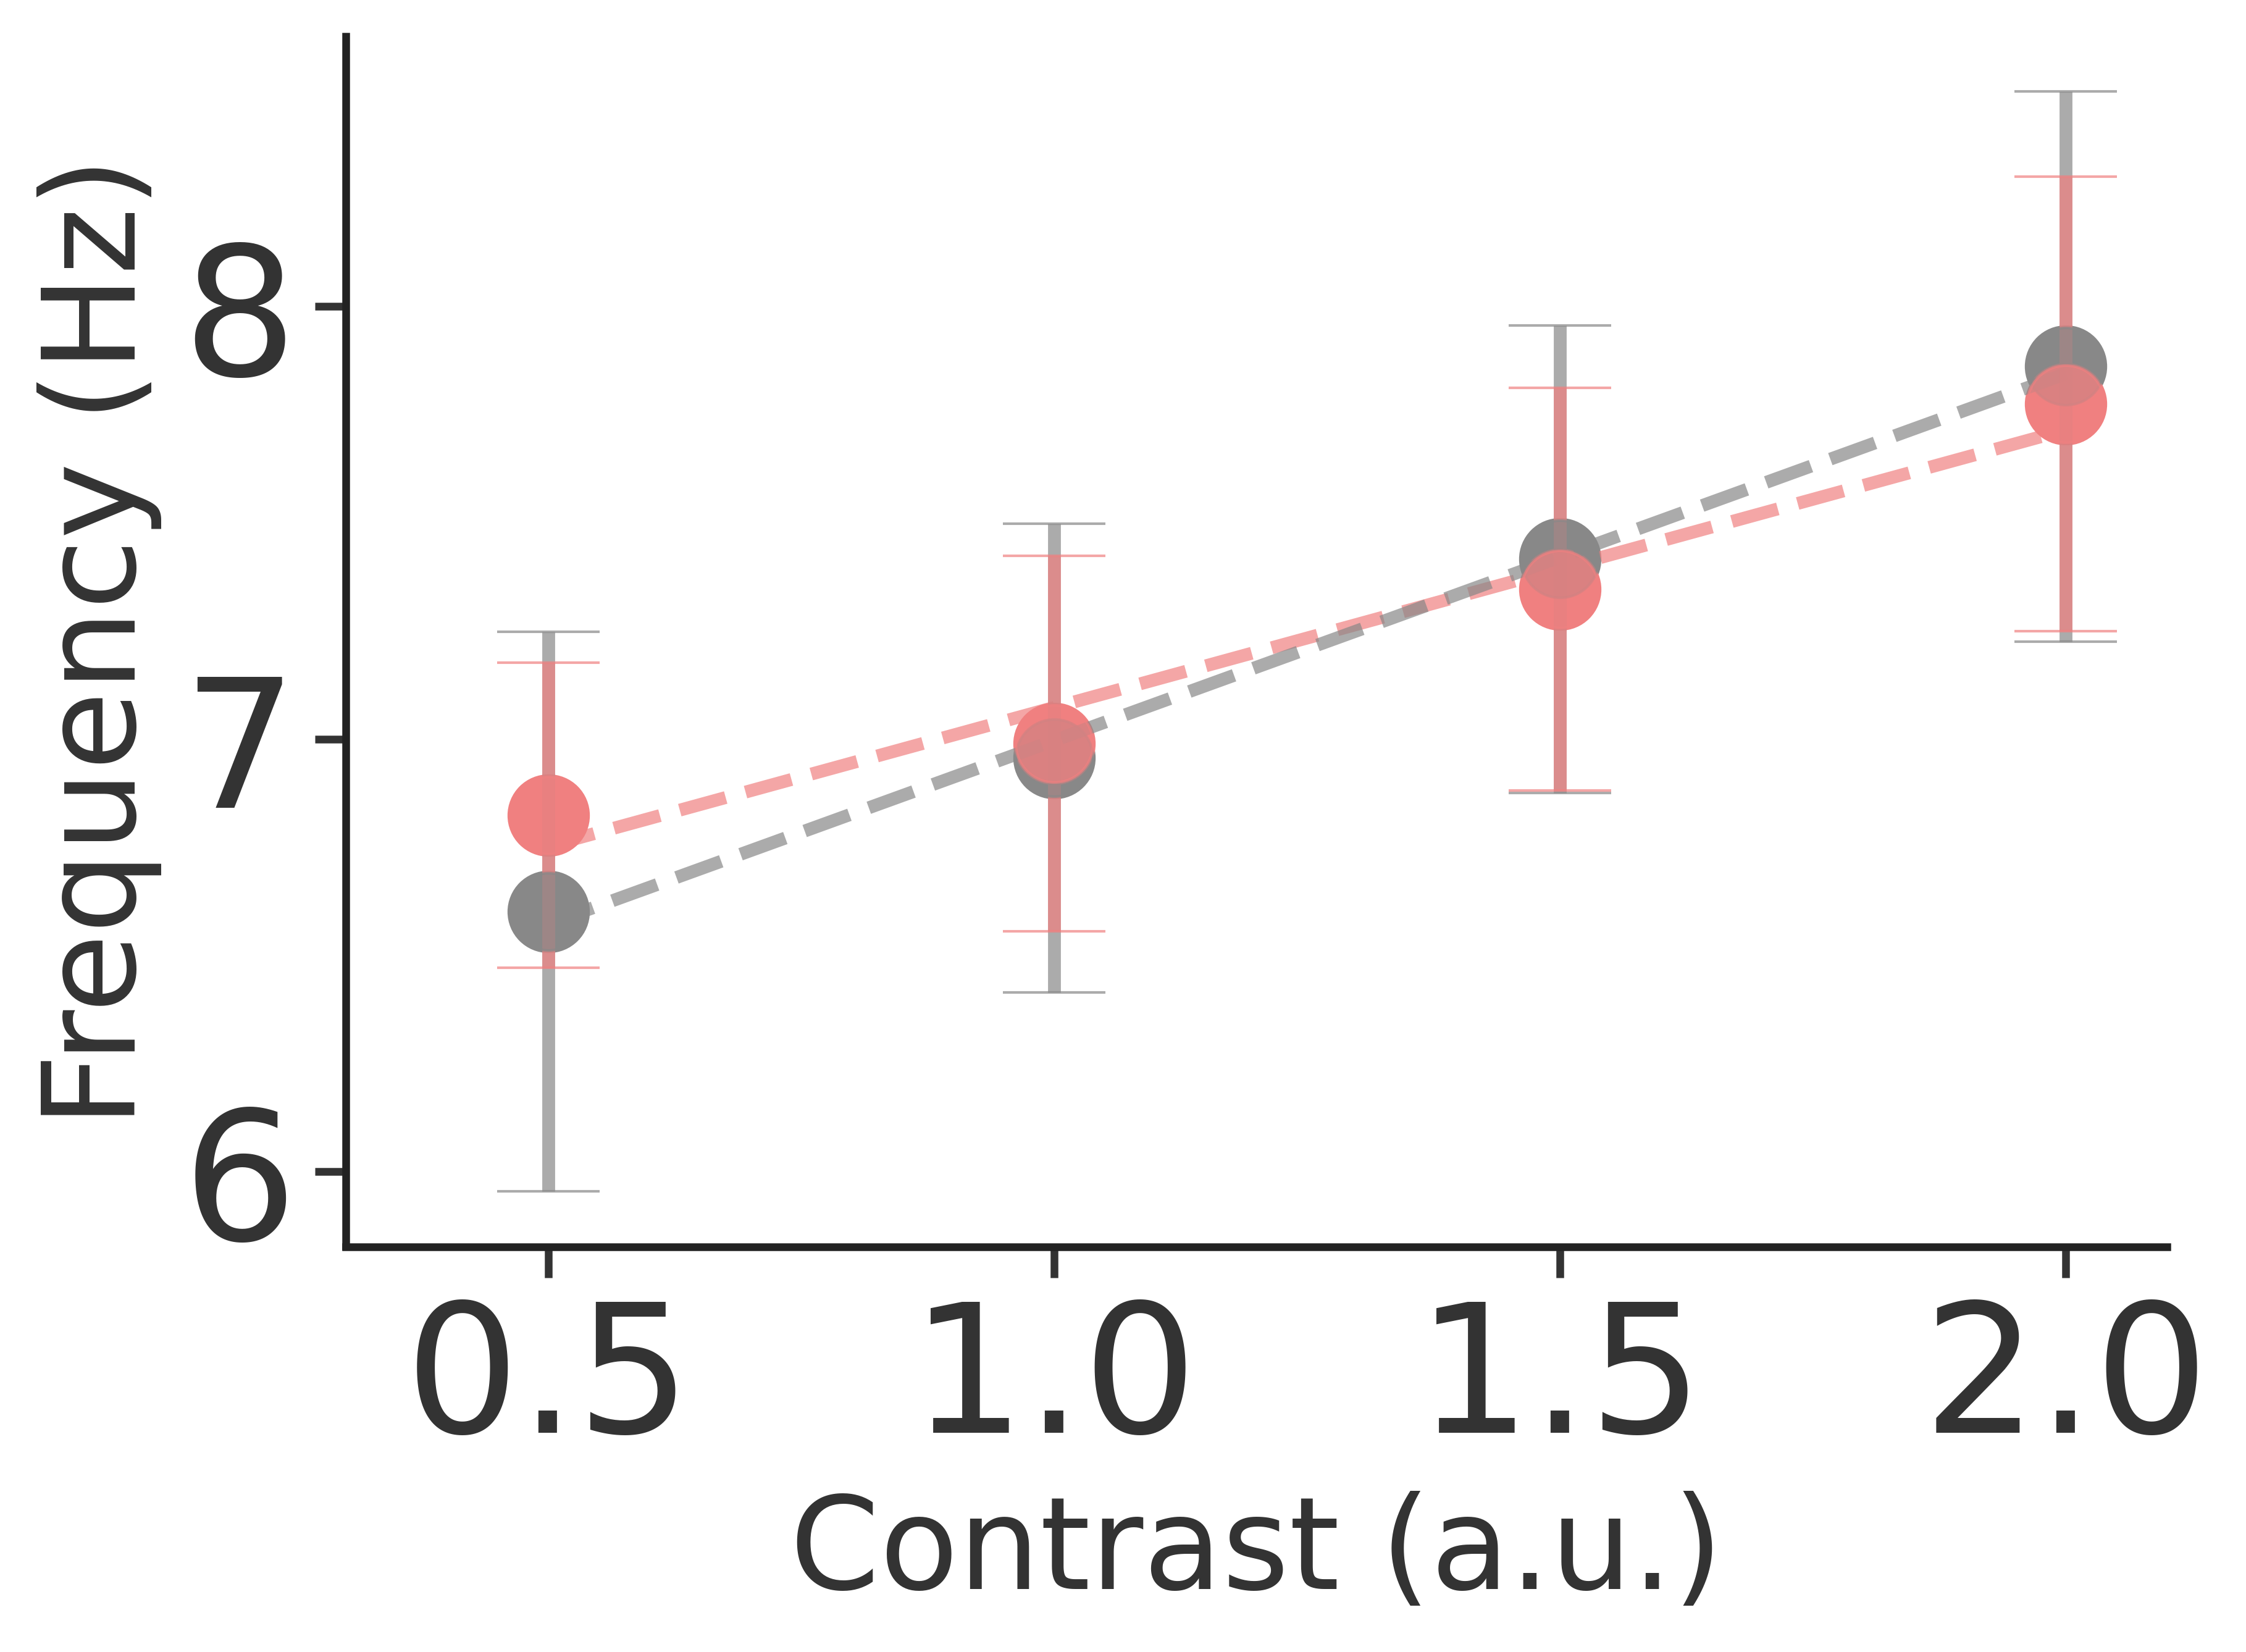

In [19]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
alpha = 0.7
capsize = 10

fig = plt.figure()
ax = fig.add_subplot(111)
plt.sca(ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

zs = np.linspace(contrasts[0], contrasts[-1], int(1e3))
#Pw = stats.linregress(x=contrasts,y=wn_cm.mean(0))
#ax.plot(zs, Pw.slope*zs + Pw.intercept, '--', color=whit_color, alpha=alpha)
#Pn = stats.linregress(x=contrasts,y=ns_cm.mean(0))
#ax.plot(zs, Pn.slope*zs + Pn.intercept, '--', color=nat_color, alpha=alpha)
Pn = np.polyfit(contrasts, ns_cm.mean(0), 1)
Pw = np.polyfit(contrasts, wn_cm.mean(0), 1)
ax.plot(zs, np.polyval(Pn, zs), '--', color=nat_color, alpha=alpha)
ax.plot(zs, np.polyval(Pw, zs), '--', color=whit_color, alpha=alpha)

nat_mean = ns_cm.mean(0)
whit_mean = wn_cm.mean(0)
plt.errorbar(x=contrasts, y=whit_mean, yerr=wn_cm.std(0)/np.sqrt(wn_cm.shape[0]), color=whit_color, fmt="o", alpha=alpha, capsize=capsize)
plt.scatter(contrasts, whit_mean, color=whit_color, alpha=1)
plt.errorbar(x=contrasts, y=nat_mean, yerr=ns_cm.std(0)/np.sqrt(ns_cm.shape[0]), color=nat_color, fmt="o",alpha=alpha, capsize=capsize)
plt.scatter(contrasts, nat_mean, color=nat_color, alpha=1)
#sns.pointplot(x="contrasts", y="resps", data=df, hue="mtype",
#              linestyles="", alpha=alpha,
#              palette={"naturalscenes": nat_color, "whitenoise": whit_color},
#              ax=ax)
#errorplot(contrasts, ns_cm.mean(axis=0), ns_cm.std(axis=0) / np.sqrt(5), method='line', fmt='o', color=nat_color, ax=ax)
#errorplot(contrasts, wn_cm.mean(axis=0), wn_cm.std(axis=0) / np.sqrt(5), method='line', fmt='o', color=whit_color, ax=ax)


#ax.set_xlim(0.25, 2.25)
#ax.set_ylim(9, 16)
plt.xticks([0.5, 1, 1.5, 2])
plt.xlim([.3,2.1])
#plt.yticks(ticks=[9,12,15])
ax.set_xlabel('Contrast (a.u.)', fontsize=fontsize)
ax.set_ylabel('Frequency (Hz)', fontsize=fontsize)
#ax.set_title('Center of mass of frequency response',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=35)
#plt.locator_params(nbins=3)
plt.tight_layout()

folder_name = "contrast_adapt"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}fastcontrastadaptationfig".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
Contrast adapation over all cells in each model.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

In [20]:
fits = {
    "wn": [],
    "ns": [],
}
for ci in range(wn_cm.shape[0]):
    fits["wn"].append(stats.linregress(x=contrasts,y=wn_cm[ci]))
    fits["ns"].append(stats.linregress(x=contrasts,y=ns_cm[ci]))


In [21]:
# Drop Cells with None Slopes
wn_slopes = [fits["wn"][i].slope for i in range(len(fits["wn"]))]
ns_slopes = [fits["ns"][i].slope for i in range(len(fits["ns"]))]


df = pd.DataFrame({
    "White Noise": wn_slopes,
    "Natural Scenes": ns_slopes,
    "Cell Idx": np.arange(len(ns_slopes)),
})
df = pd.melt(df, id_vars="Cell Idx", value_vars=["White Noise", "Natural Scenes"], var_name="Stim Type", value_name="Slope")
df.head()
    

Cell Idx    Stim Type     Slope
0         0  White Noise  0.861262
1         1  White Noise  0.997198
2         2  White Noise  0.334936
3         3  White Noise  0.529188
4         4  White Noise  0.273354

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


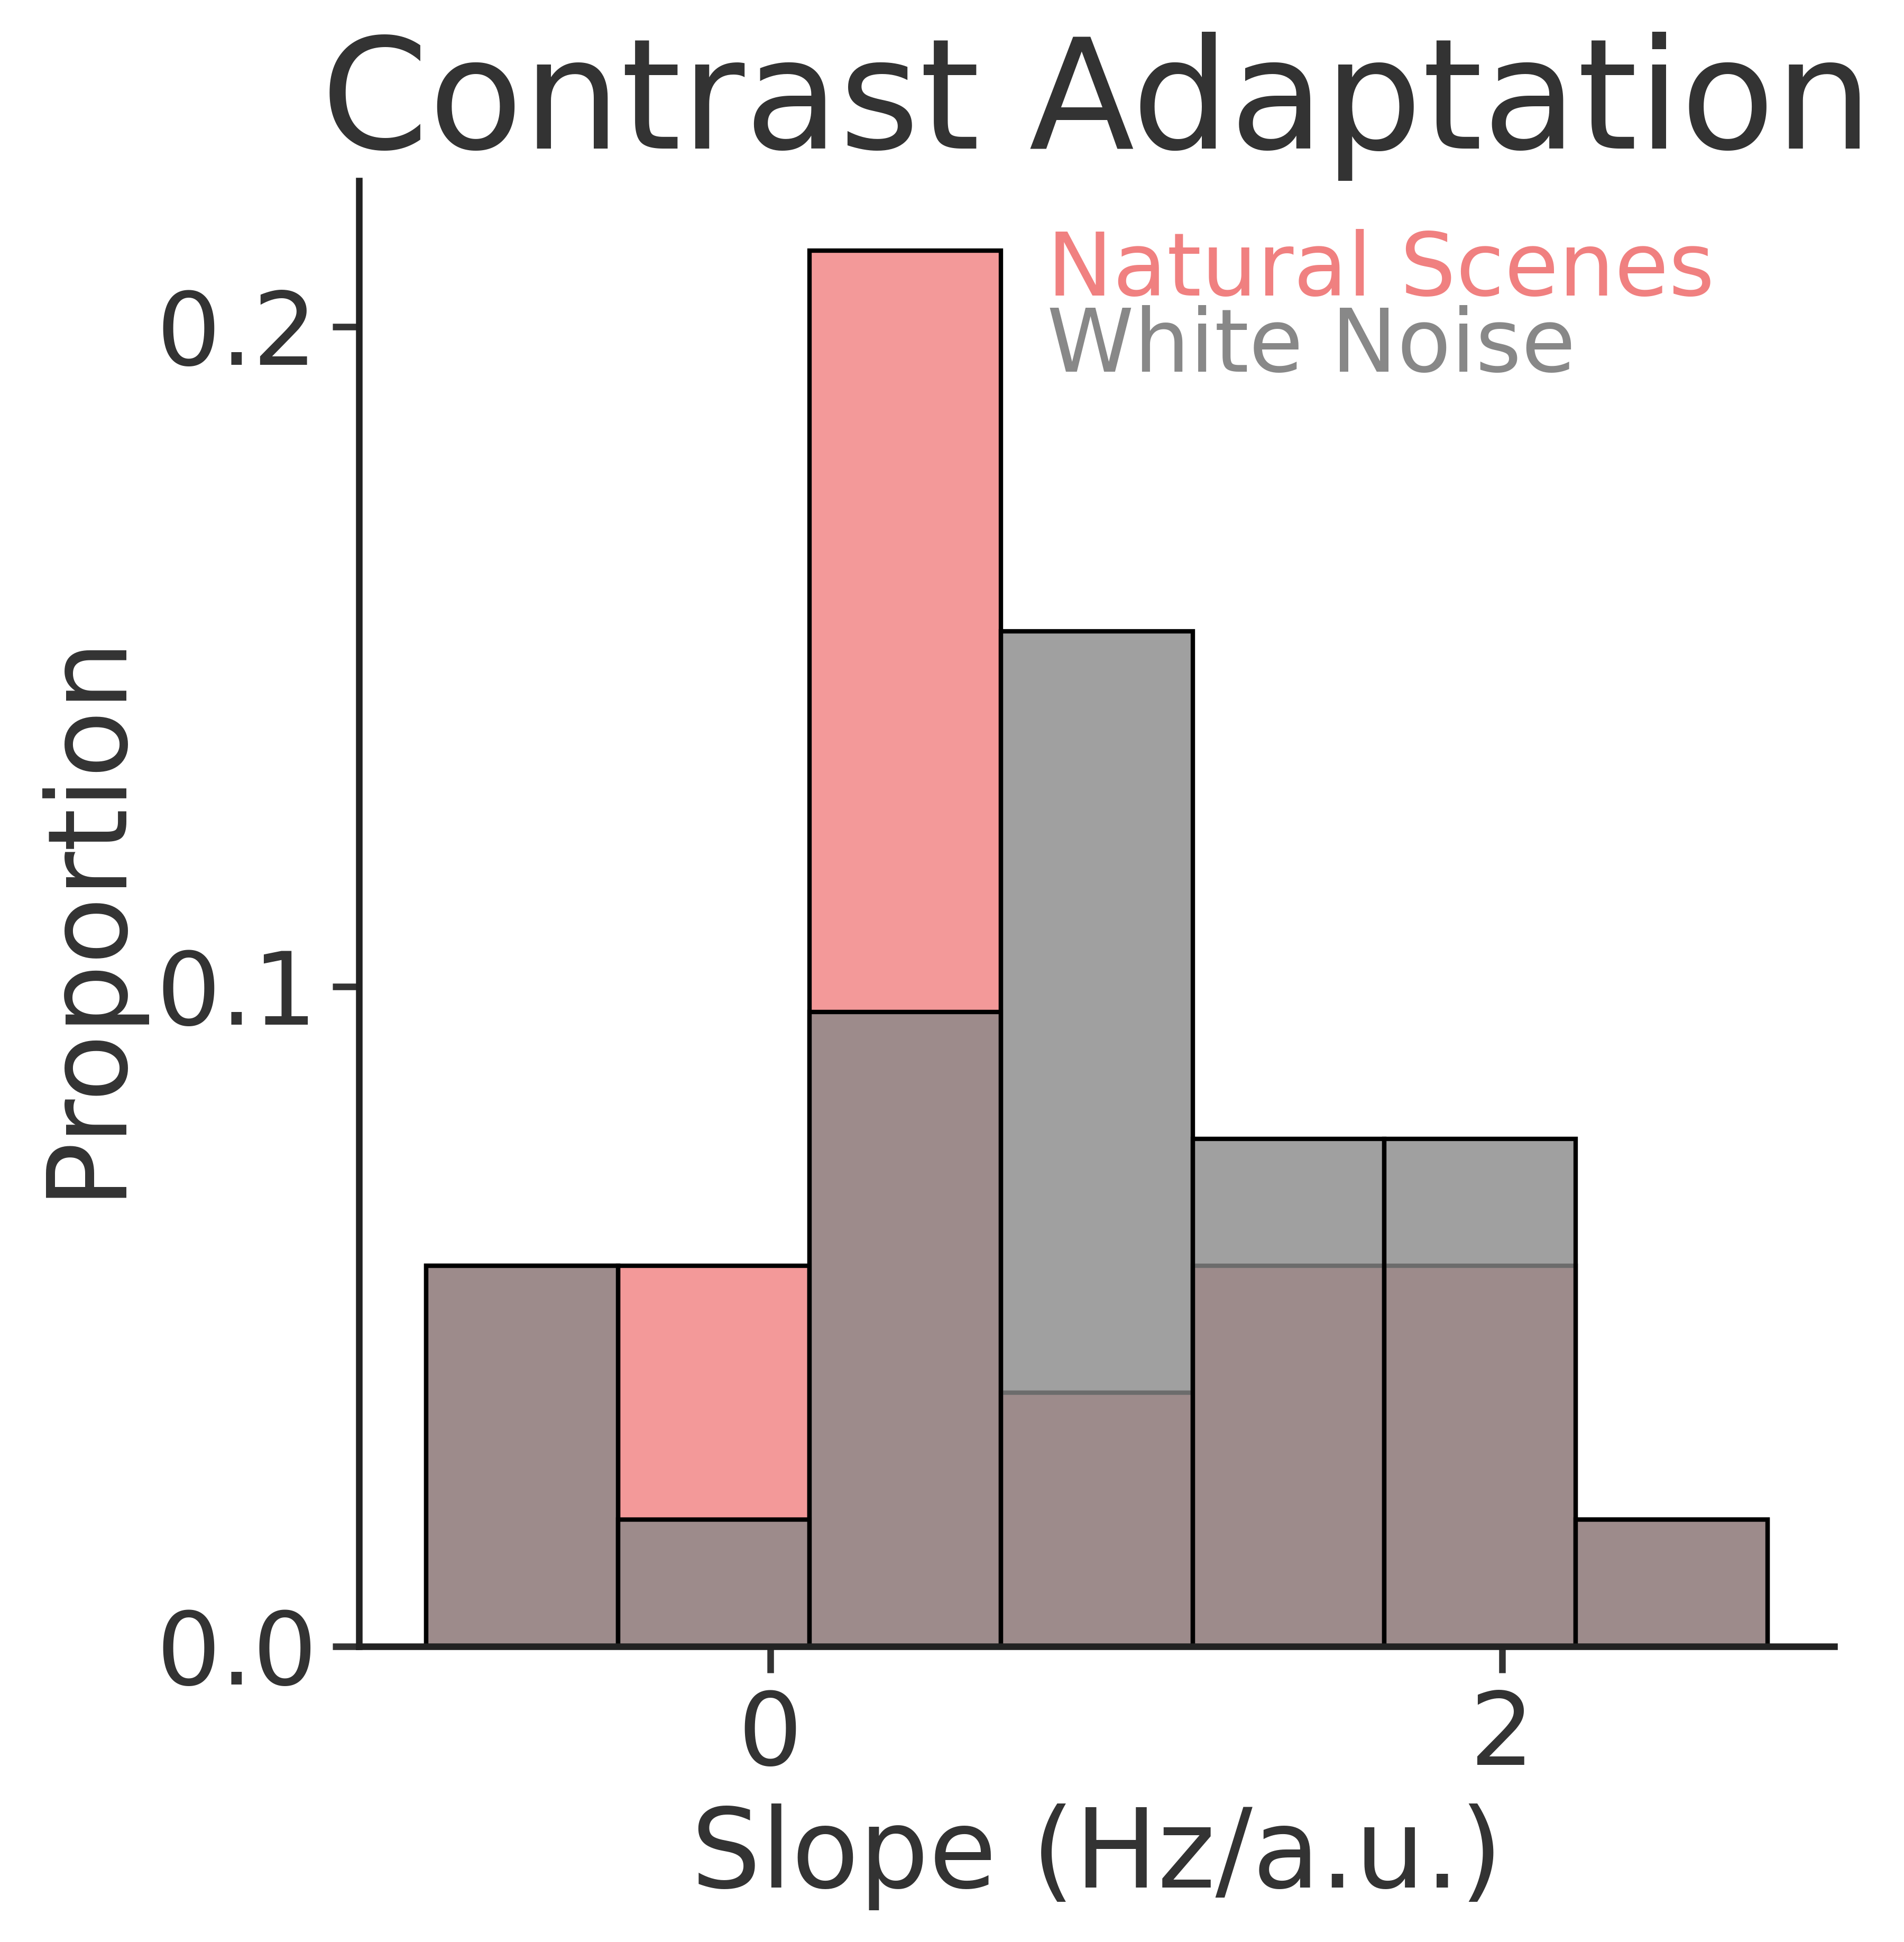

In [22]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
alpha = 0.8

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.histplot(x="Slope", data=df, stat="proportion", hue="Stim Type", ax=ax,
             palette={"White Noise": whit_color, "Natural Scenes": nat_color}, alpha=alpha)
#ylim = [0,0.6]
#yticks = [i/10 for i in range(0, int(ylim[1]*10)+1, 3)]
#plt.yticks(yticks, fontsize=ticksize)
#plt.xticks([-8, -4, 0], fontsize=ticksize)
#plt.ylim(ylim)
plt.ylabel("Proportion", fontsize=fontsize)
plt.xlabel("Slope (Hz/a.u.)", fontsize=fontsize)
plt.title("Contrast Adaptation", fontsize=titlesize)
plt.legend().set_visible(False)
ax.annotate('White Noise', xy=(0.55, 0.86), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.55, 0.9), #xycoords='axes points',
            xycoords="figure fraction",
            size=20, ha='left', va='top',
            bbox=None,
            color=nat_color)
            
plt.locator_params(nbins=4)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "contrast_adapt"
folder = os.path.join(savefolder, "contrast_adapt")
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}fast_contrast_slope_hist".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
Histogram of the contrast adaptation for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

In [23]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 0.5
alpha = 0.7

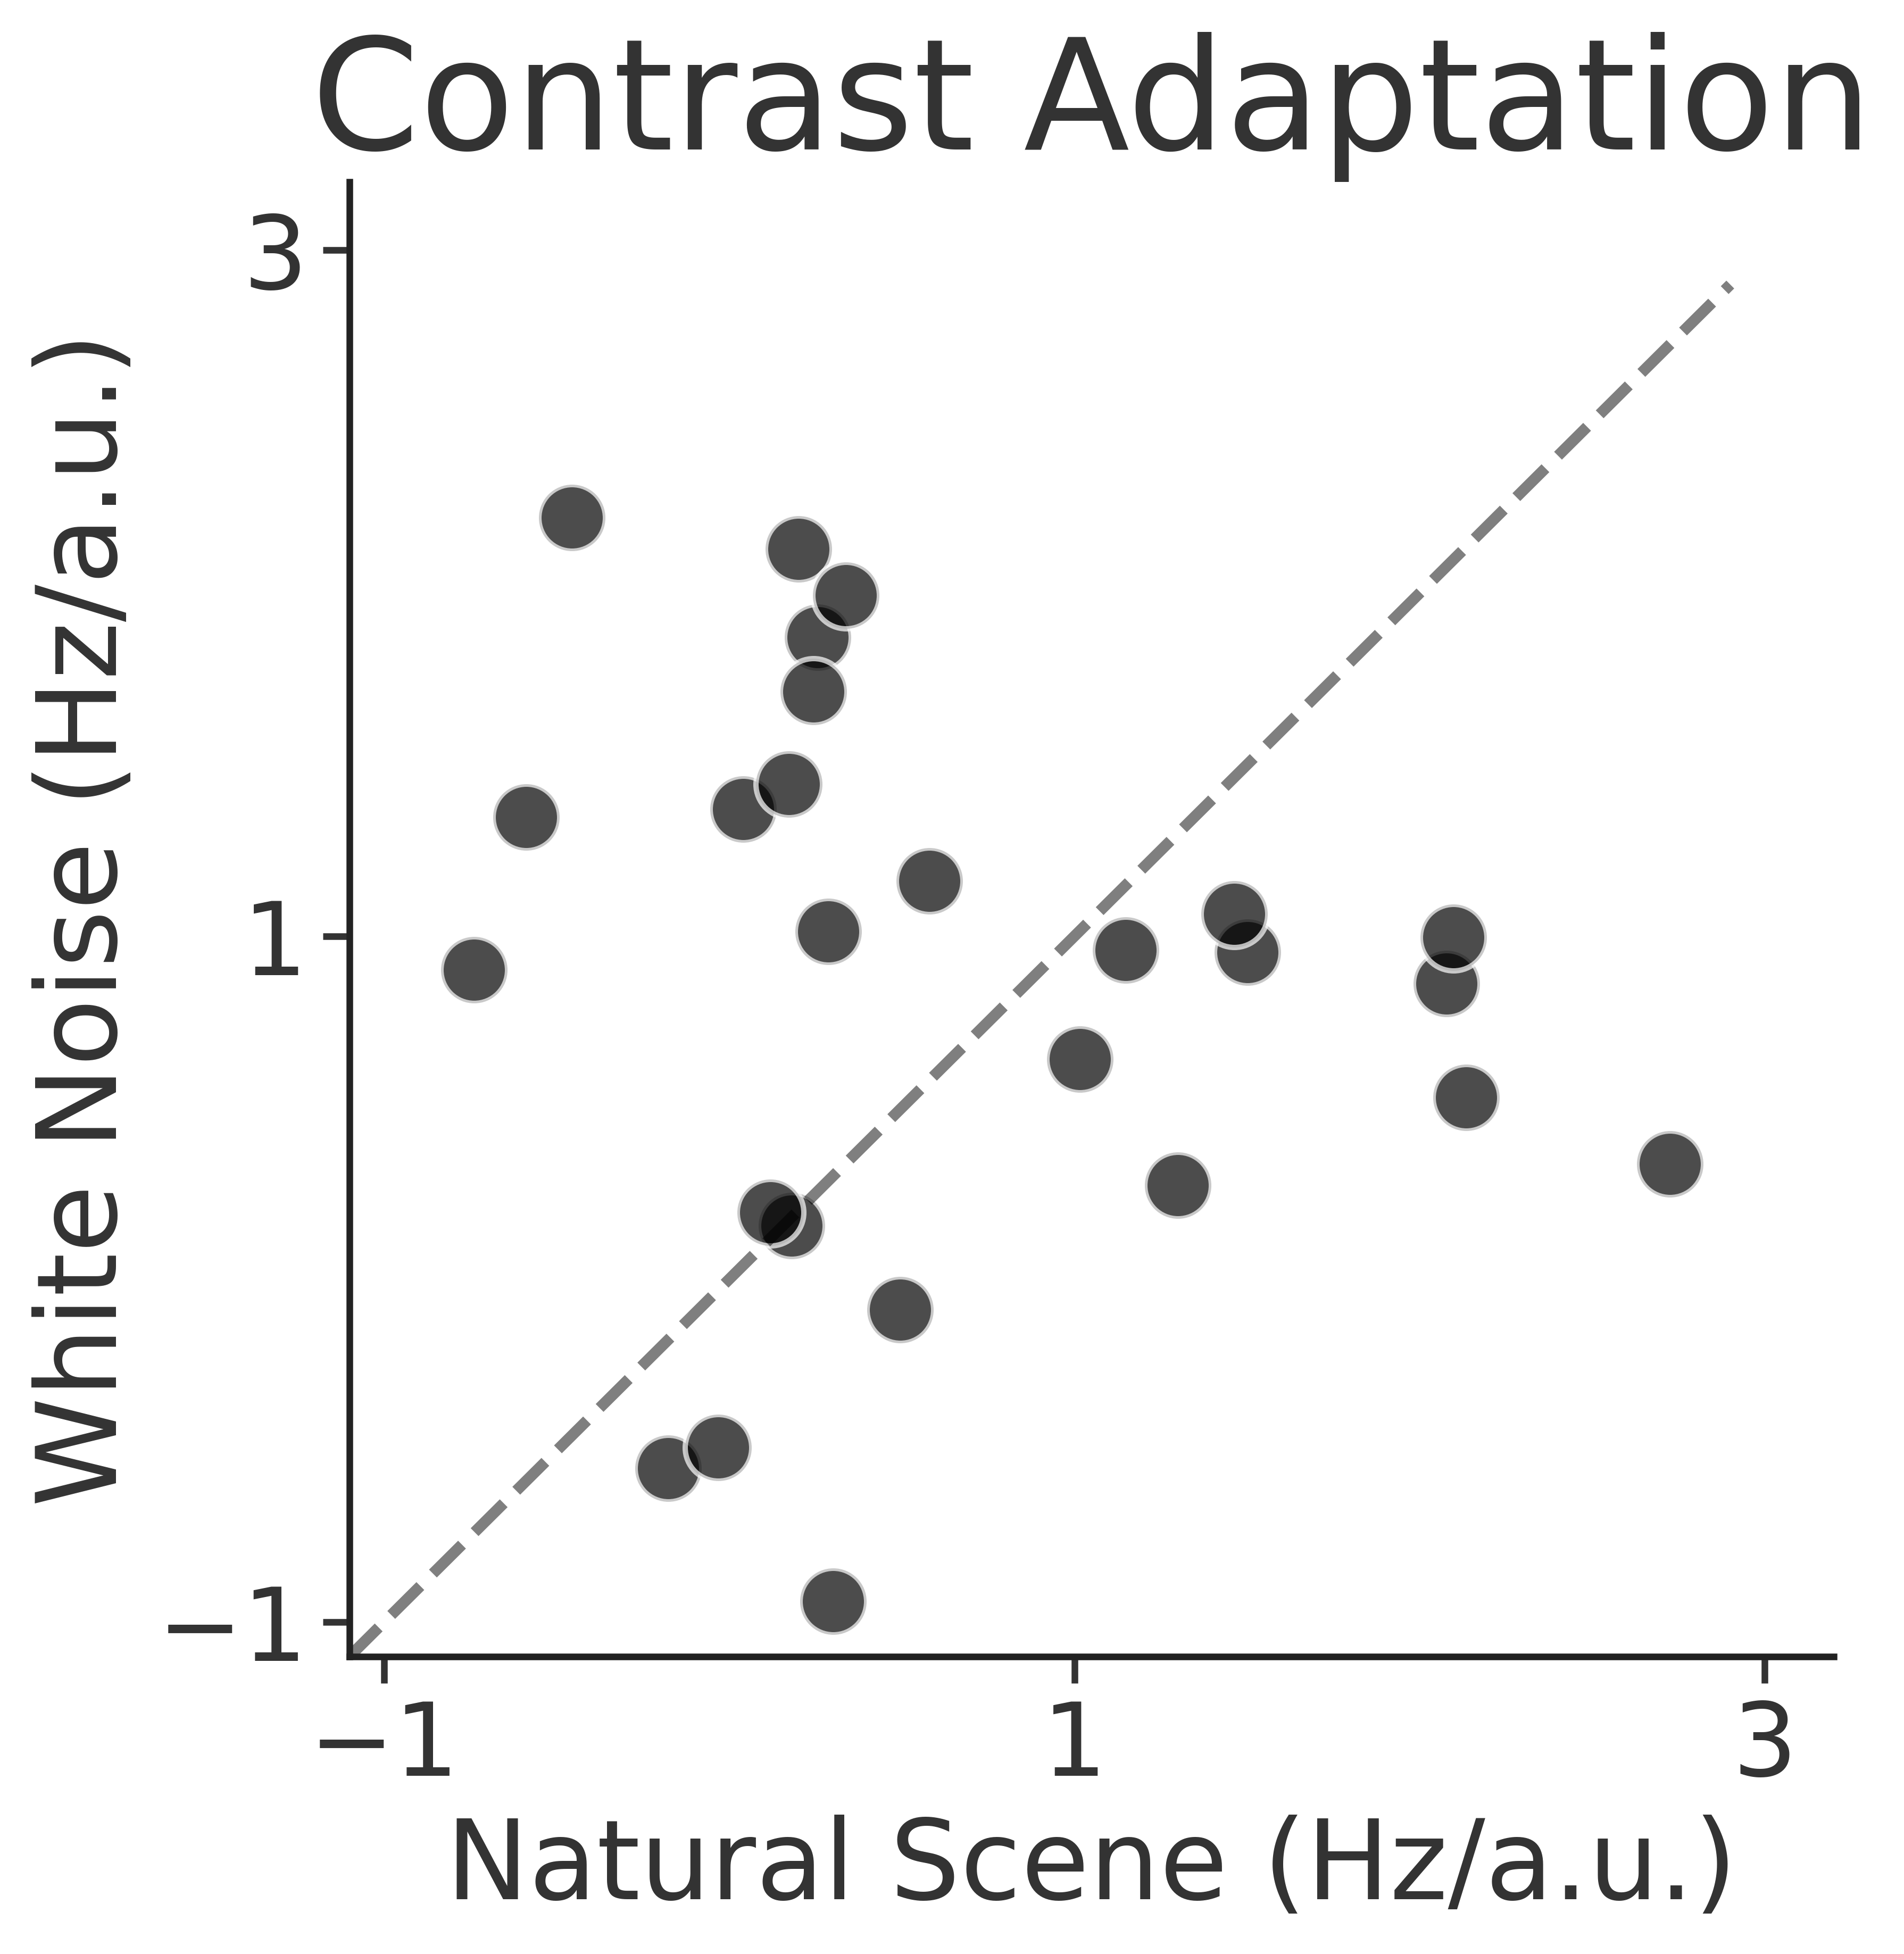

In [24]:
wn_slopes = [fits["wn"][i].slope for i in range(len(fits["wn"]))]
ns_slopes = [fits["ns"][i].slope for i in range(len(fits["ns"]))]
x = []
y = []
for w,n in zip(wn_slopes, ns_slopes):
    if w is None or n is None: continue
    x.append(n)
    y.append(w)

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x,y, ax=ax, alpha=alpha, color="black")
ticks = [-1,1,3]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [-1.1, 3.2]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.arange(lim[0], lim[1]), np.arange(lim[0], lim[1]), "--k", alpha=0.5)
plt.ylabel("White Noise (Hz/a.u.)", fontsize=fontsize)
plt.xlabel("Natural Scene (Hz/a.u.)", fontsize=fontsize)
plt.title("Contrast Adaptation", fontsize=titlesize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

folder_name = "contrast_adapt"
folder = os.path.join(savefolder, "contrast_adapt")
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}contrast_adapt_slope_scatter".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
White Noise model contrast adapation plotted against Natural Scenes model contrast adaption
for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

# f2/f1 Ratio

In [27]:
#def sqz_predict(mdls):
#    """Squeeze predictions from multiple models into one array."""
#    def predict(X):
#        X = torch.FloatTensor(X).cuda()
#        return np.hstack([mdl(X).detach().cpu().numpy() for mdl in mdls])
#    return predict
def sqz_predict(mdls):
    """Squeeze predictions from multiple models into one array."""
    def predict(X):
        X = torch.FloatTensor(X).cuda()
        preds = []
        for mdl in mdls:
            mdl.cuda()
            mdl.eval()
            preds.append(mdl(X).detach().cpu().numpy())
            mdl.cpu()
        return np.hstack(preds)
    return predict


def freq_doubling(predict, ncells, phases, widths, halfperiod=25, nsamples=140):
    """
    We're looking at the ratio of the amplitude of the firing rate at a base
    frequency (decided by the specified halfperiod) to the amplitude of the
    firing rate at double the base frequency. This gives insight into the
    nonlinear computations of the cells.
    """
    F1 = np.zeros((ncells, phases.size, widths.size))
    F2 = np.zeros_like(F1)

    period = (2 * halfperiod) * 0.01
    base_freq = 1 / period
    freqs = fftfreq(nsamples - 40, 0.01)
    i1 = np.where(freqs == base_freq)[0][0]
    i2 = np.where(freqs == base_freq * 2)[0][0]
    print(f'Base frequency: {base_freq}Hz\n\tF1[{i1}]: {freqs[i1]}Hz\n\tF2[{i2}]: {freqs[i2]}Hz\n')

    for p, phase in enumerate(phases):
        for w, width in tqdm(list(enumerate(widths))):
            X = stimuli.reversing_grating(nsamples, halfperiod, width, phase, 'sin')
            stim = stimuli.concat(X)
            r = predict(stim)
            for ci in range(r.shape[1]):
                amp = np.abs(fft(r[:, ci]))
                F1[ci, p, w] = amp[i1]
                F2[ci, p, w] = amp[i2]
    return F1, F2


In [28]:
def freq_doubling(predict, ncells, phases, widths, halfperiod=25, nsamples=140):
    """
    We're looking at the ratio of the amplitude of the firing rate at a base
    frequency (decided by the specified halfperiod) to the amplitude of the
    firing rate at double the base frequency. This gives insight into the
    nonlinear computations of the cells.
    """
    F1 = np.zeros((ncells, phases.size, widths.size))
    F2 = np.zeros_like(F1)

    period = (2 * halfperiod) * 0.01
    base_freq = 1 / period
    freqs = fftfreq(nsamples - 40, 0.01)
    i1 = np.where(freqs == base_freq)[0][0]
    i2 = np.where(freqs == base_freq * 2)[0][0]
    print(f'Base frequency: {base_freq}Hz\n\tF1[{i1}]: {freqs[i1]}Hz\n\tF2[{i2}]: {freqs[i2]}Hz\n')

    for p, phase in enumerate(phases):
        #for w, width in tqdm(list(enumerate(widths))):
        w = 1
        width = widths[1]
        X = stimuli.reversing_grating(nsamples, halfperiod, width, phase, 'sin')
        stim = stimuli.concat(X)
        r = predict(stim)
        for ci in range(r.shape[1]):
            amp = np.abs(fft(r[:, ci]))
            F1[ci, p, w] = amp[i1]
            F2[ci, p, w] = amp[i2]
    return F1, F2

In [29]:
ncells = 5 + 4 + 17                 # Total number of cells.
phases = np.linspace(0, 1, 9)       # Grating phases.
widths = np.arange(1, 9)            # Bar widths (checkers).
sz = widths * 55.55                 # Bar widths (microns).

mtype = "naturalscene"
ns_predict = sqz_predict((
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-10-07', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21a', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21b', mtype))),
))

ns_F1, ns_F2 = freq_doubling(ns_predict, ncells, phases, widths)
ns_fratio = ns_F2 / ns_F1
ns_mu = ns_fratio.mean(axis=1) # Average over phases

mtype = "whitenoise"
wn_predict = sqz_predict((
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-10-07',  mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21a', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21b', mtype))),
))

wn_F1, wn_F2 = freq_doubling(wn_predict, ncells, phases, widths)
wn_fratio = wn_F2 / wn_F1
wn_mu = wn_fratio.mean(axis=1)

Base frequency: 2.0Hz
	F1[2]: 2.0Hz
	F2[4]: 4.0Hz

Base frequency: 2.0Hz
	F1[2]: 2.0Hz
	F2[4]: 4.0Hz



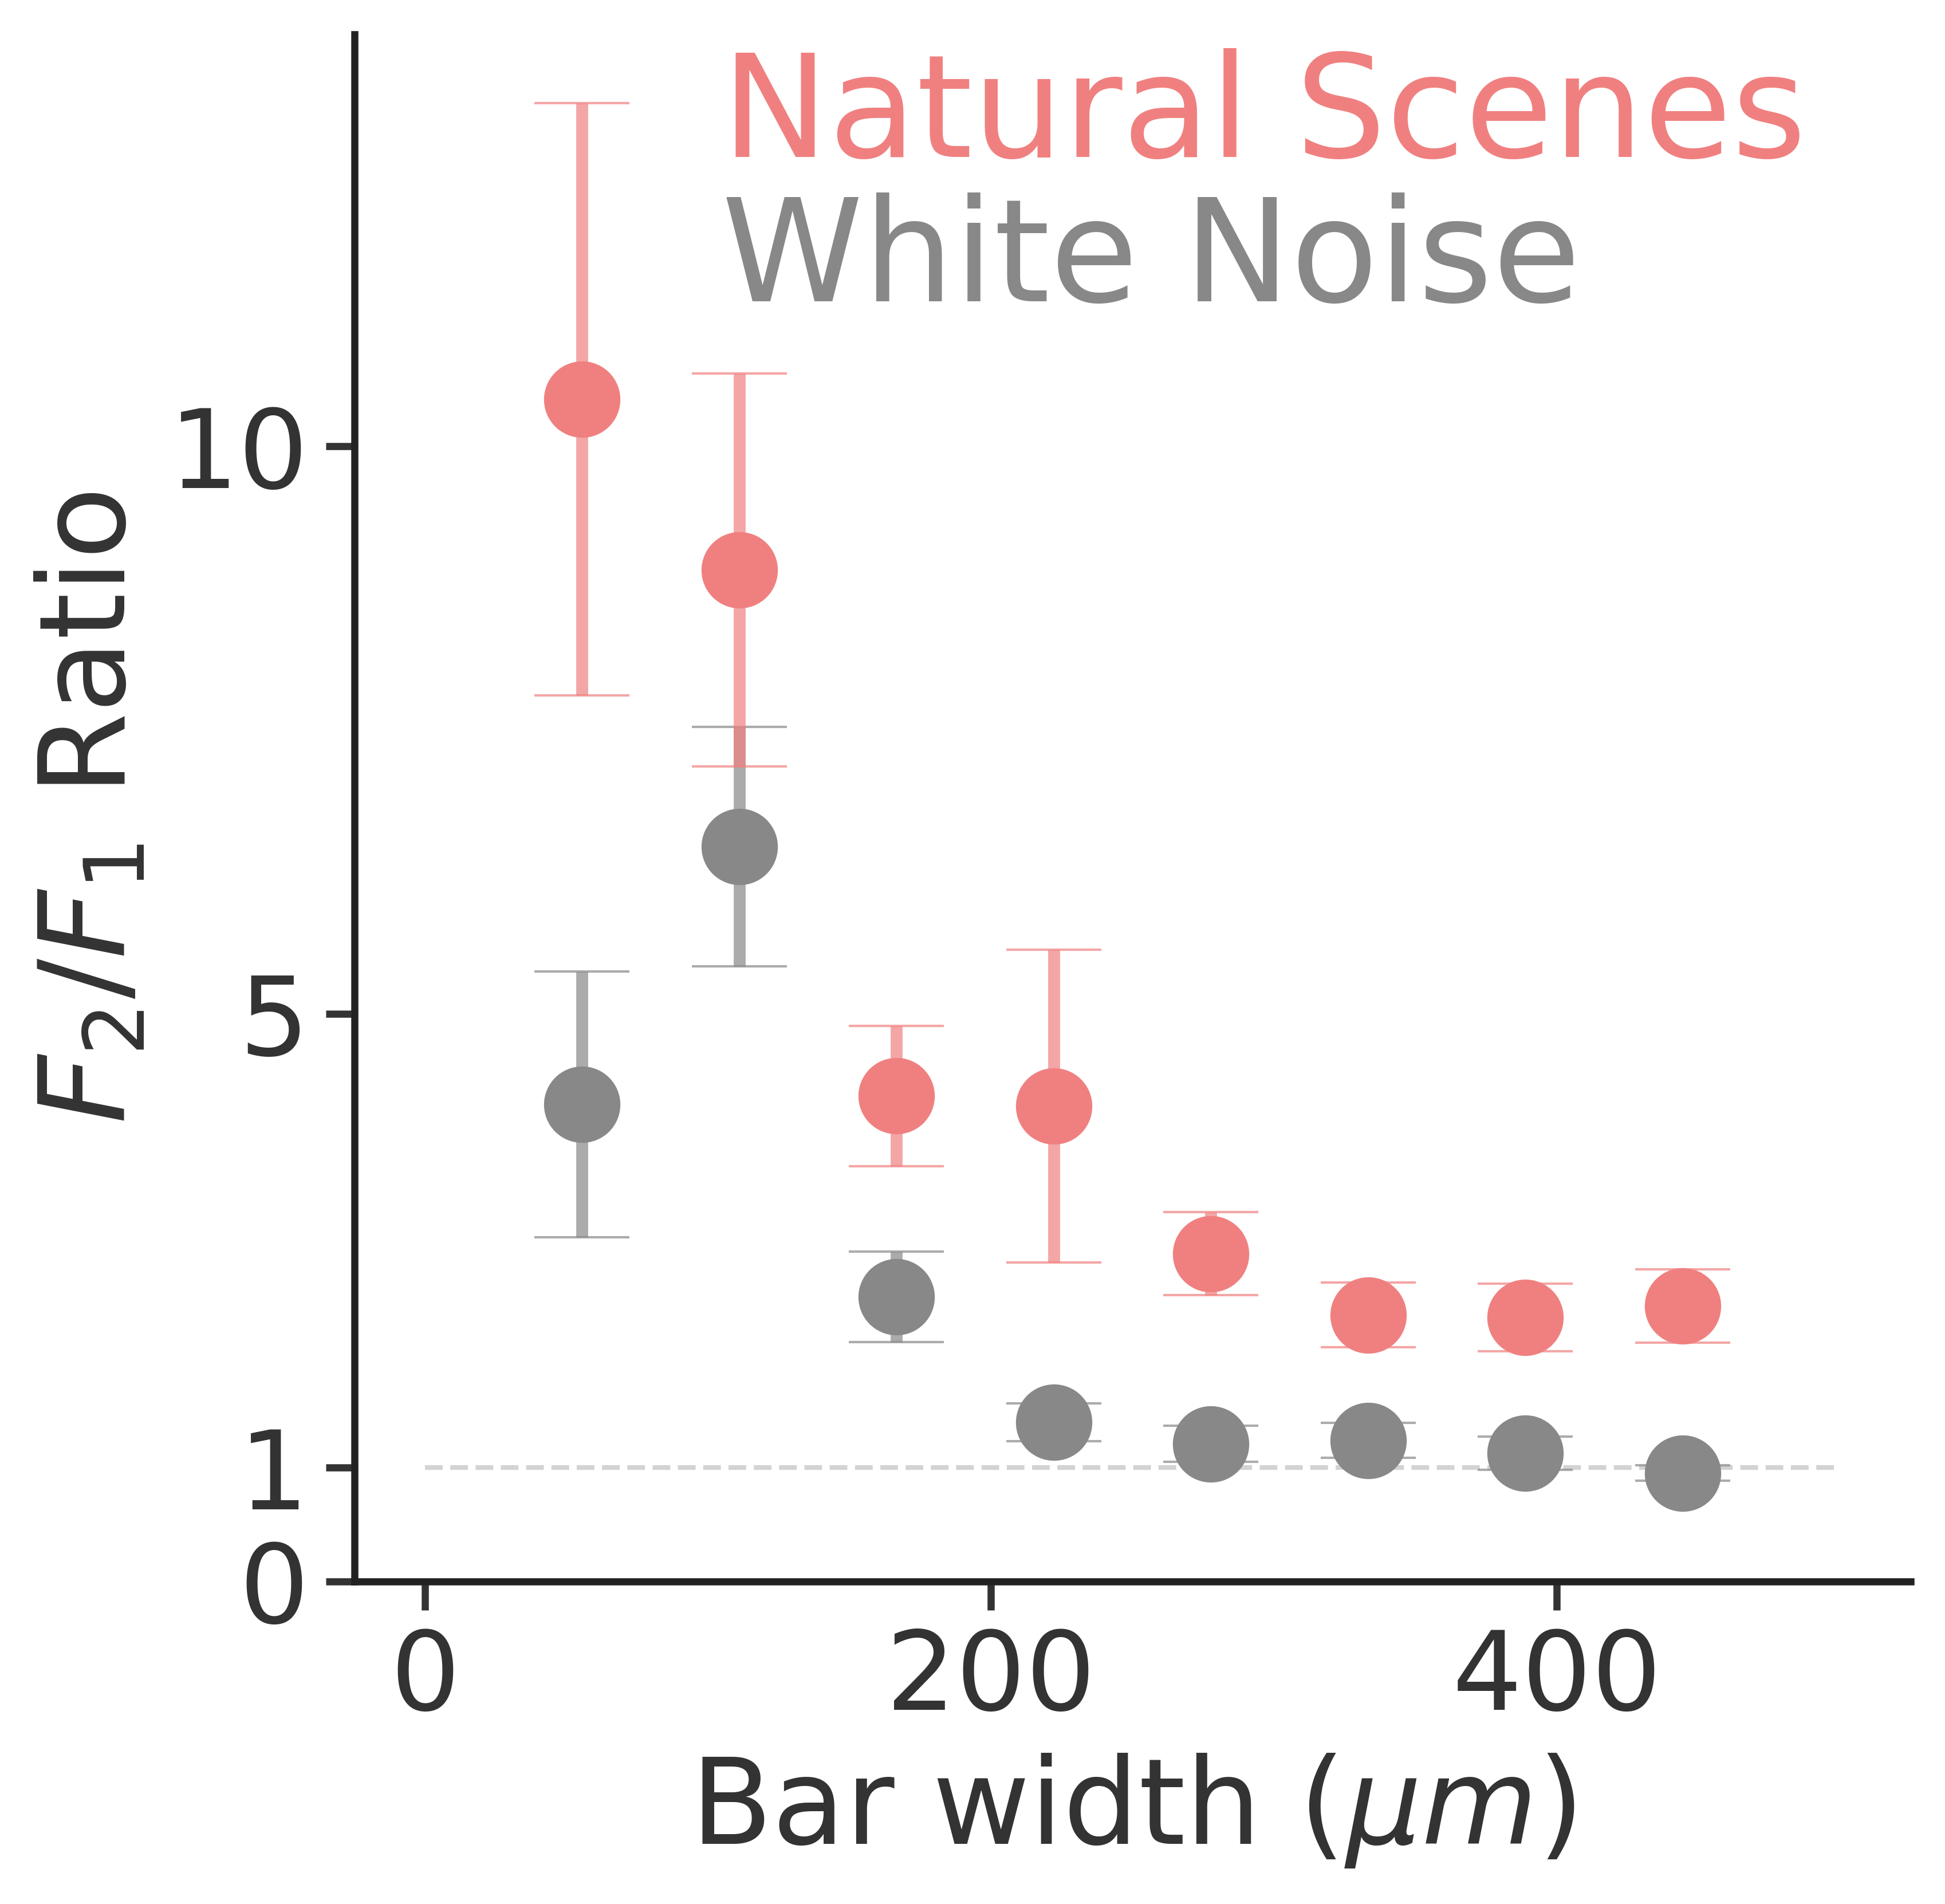

In [25]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 0.5
alpha = 0.7

# Plot
fig = plt.figure(figsize=(6,6))
plt.style.use('deepretina.mplstyle')
ax = plt.gca()

#errorplot(sz, mu.mean(axis=0), mu.std(axis=0) / np.sqrt(ncells), method='line', fmt='o', color='#222222', ax=ax)

mu_mean = wn_mu.mean(axis=0)
mu_err = wn_mu.std(axis=0) / np.sqrt(ncells)
plt.errorbar(x=sz, y=mu_mean, yerr=mu_err, color=whit_color, fmt="o", alpha=alpha, capsize=capsize)
plt.scatter(sz, mu_mean, color=whit_color, alpha=1)

mu_mean = ns_mu.mean(axis=0)
mu_err = ns_mu.std(axis=0) / np.sqrt(ncells)
plt.errorbar(x=sz, y=mu_mean, yerr=mu_err, color=nat_color, fmt="o", alpha=alpha, capsize=capsize)
plt.scatter(sz, mu_mean, color=nat_color, alpha=1)

ax.plot([0, 500], [1, 1], '--', color='lightgray', lw=1, zorder=0)
ax.set_xlabel('Bar width ($\mu m$)',fontsize=fontsize)
ax.set_ylabel('$F_2/F_1$ Ratio',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=ticksize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=[0,200,400])
plt.yticks(ticks=[0,1,5,10])

ax.annotate('White Noise', xy=(0.35, 0.83), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.35, 0.9), #xycoords='axes points',
            xycoords="figure fraction",
            size=30, ha='left', va='top',
            bbox=None,
            color=nat_color)
            

#ax.set_ylim(0, 8.2)
plt.tight_layout()

folder_name = "f2"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}f2_response".format(prename))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()


captions[folder_name][save_name.split("/")[-1]] = """
Mean frequency doubling for all cells in each model.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")


In [26]:
rat_idx = 1
ratios = {
    "wn": [],
    "ns": [],
}
for ci in range(wn_mu.shape[0]):
    ratios["wn"].append(wn_mu[ci][rat_idx])
    ratios["ns"].append(ns_mu[ci][rat_idx])
    
df = pd.DataFrame({
    "White Noise": ratios["wn"],
    "Natural Scenes": ratios["ns"],
    "Cell Idx": np.arange(len(ratios["ns"])),
})

df = pd.melt(df, id_vars="Cell Idx", value_vars=["White Noise", "Natural Scenes"], var_name="Stim Type", value_name="Ratio")
df

Cell Idx       Stim Type      Ratio
0          0     White Noise   4.184045
1          1     White Noise   1.787668
2          2     White Noise   8.709436
3          3     White Noise   2.565079
4          4     White Noise   2.388813
5          5     White Noise   1.600930
6          6     White Noise   7.516274
7          7     White Noise   7.072331
8          8     White Noise   1.295834
9          9     White Noise   8.193718
10        10     White Noise   6.385763
11        11     White Noise   2.981938
12        12     White Noise   5.981982
13        13     White Noise   0.731056
14        14     White Noise   7.180015
15        15     White Noise   8.689718
16        16     White Noise   3.391937
17        17     White Noise  21.170679
18        18     White Noise   2.216430
19        19     White Noise  19.680992
20        20     White Noise   9.533802
21        21     White Noise  14.846568
22        22     White Noise   1.922114
23        23     White Noise  12.444732
24        24     White Noise   1.489755
25        25     White Noise   4.306620
26         0  Natural Scenes   5.359644
27         1  Natural Scenes  22.115683
28         2  Natural Scenes   8.026103
29         3  Natural Scenes   4.682802
30         4  Natural Scenes  12.964580
31         5  Natural Scenes   2.886420
32         6  Natural Scenes  13.627539
33         7  Natural Scenes   4.395292
34         8  Natural Scenes   2.011421
35         9  Natural Scenes  21.999592
36        10  Natural Scenes   1.289585
37        11  Natural Scenes   3.806009
38        12  Natural Scenes   0.917936
39        13  Natural Scenes   1.090639
40        14  Natural Scenes   6.765239
41        15  Natural Scenes  14.113063
42        16  Natural Scenes   4.858915
43        17  Natural Scenes   8.082044
44        18  Natural Scenes   1.771404
45        19  Natural Scenes   4.604342
46        20  Natural Scenes   6.440837
47        21  Natural Scenes  16.579290
48        22  Natural Scenes   1.409118
49        23  Natural Scenes  38.147410
50        24  Natural Scenes   2.254092
51        25  Natural Scenes  21.435203

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


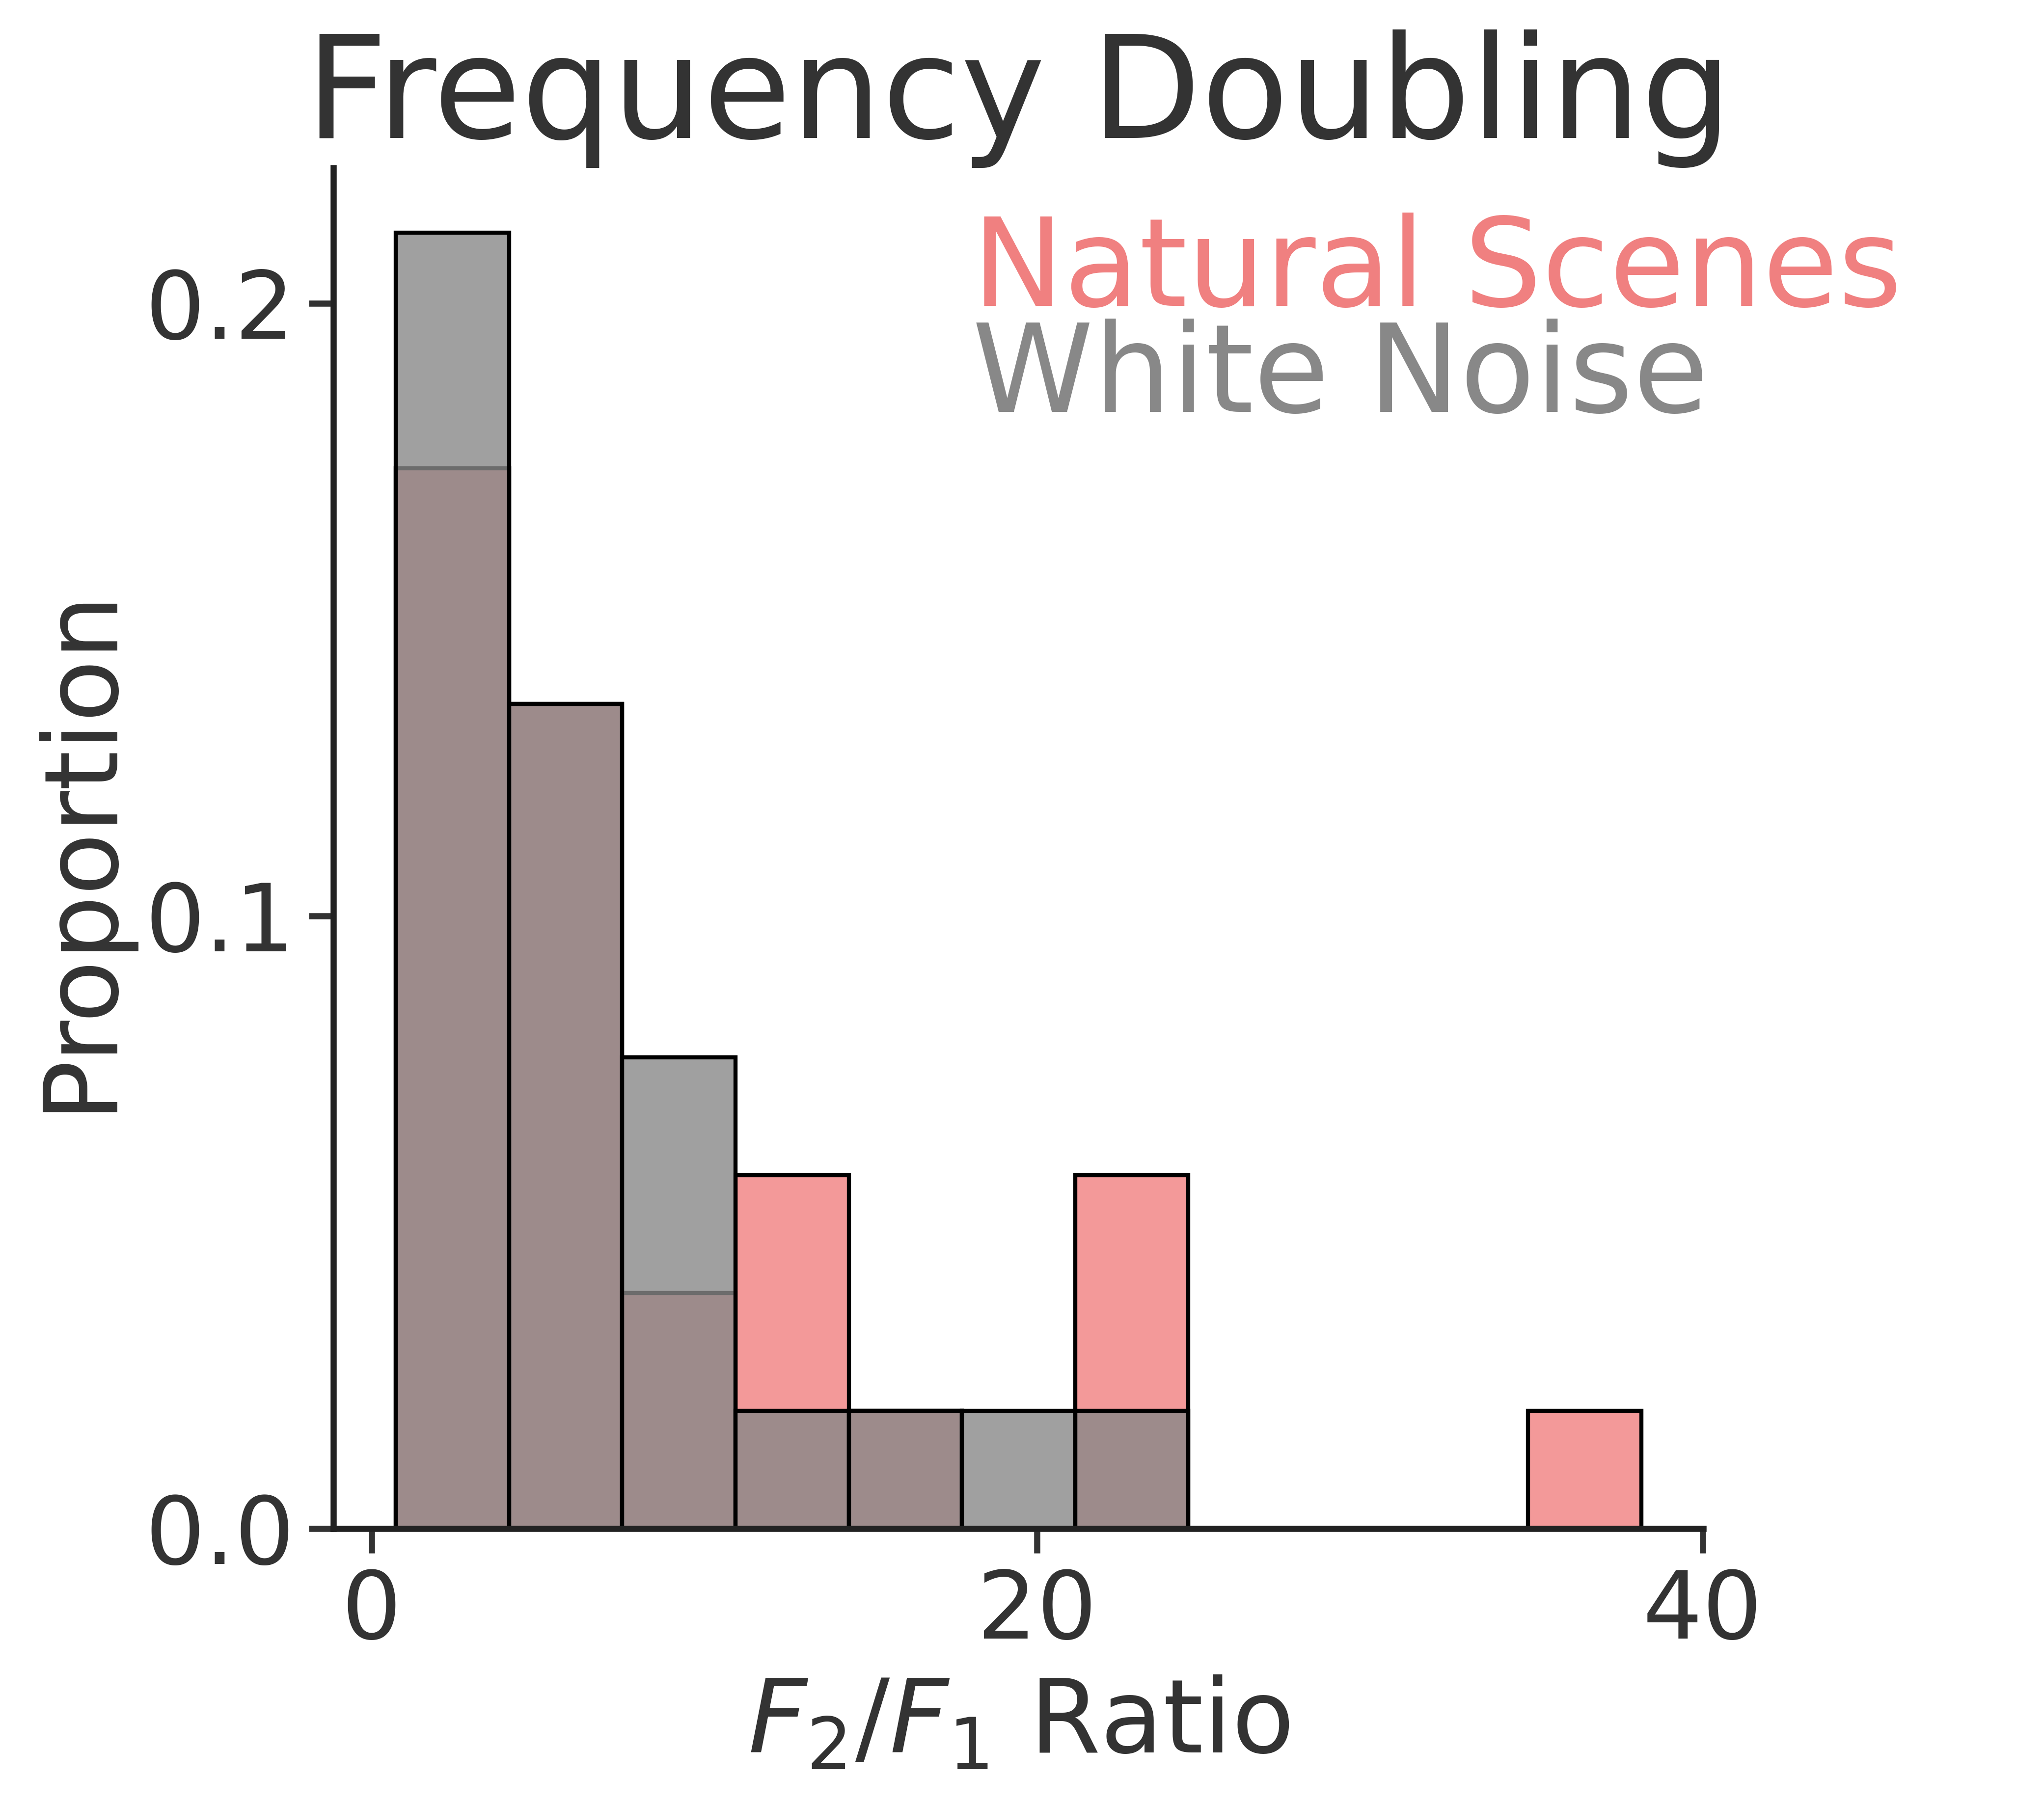

In [27]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
annotesize = 30
alpha = 0.8

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.histplot(x="Ratio", data=df, stat="proportion", hue="Stim Type", ax=ax,
             palette={"White Noise": whit_color, "Natural Scenes": nat_color}, alpha=alpha)
#ylim = [0,0.6]
#yticks = [i/10 for i in range(0, int(ylim[1]*10)+1, 3)]
#plt.yticks(yticks, fontsize=ticksize)
#plt.xticks([-8, -4, 0], fontsize=ticksize)
#plt.ylim(ylim)
plt.ylabel("Proportion", fontsize=fontsize)
plt.xlabel("$F_{2}/F_{1}$ Ratio", fontsize=fontsize)
plt.title("Frequency Doubling", fontsize=titlesize)
plt.legend().set_visible(False)
ax.annotate('White Noise', xy=(0.55, 0.84), #xycoords='axes points',
            xycoords="figure fraction",
            size=annotesize, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(0.55, 0.9), #xycoords='axes points',
            xycoords="figure fraction",
            size=annotesize, ha='left', va='top',
            bbox=None,
            color=nat_color)
            
plt.locator_params(nbins=4)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "f2"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}f2_ratioidx{}_hist".format(prename,rat_idx))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
Histogram of individual cell $F_{2}/F_{1}$ ratios.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

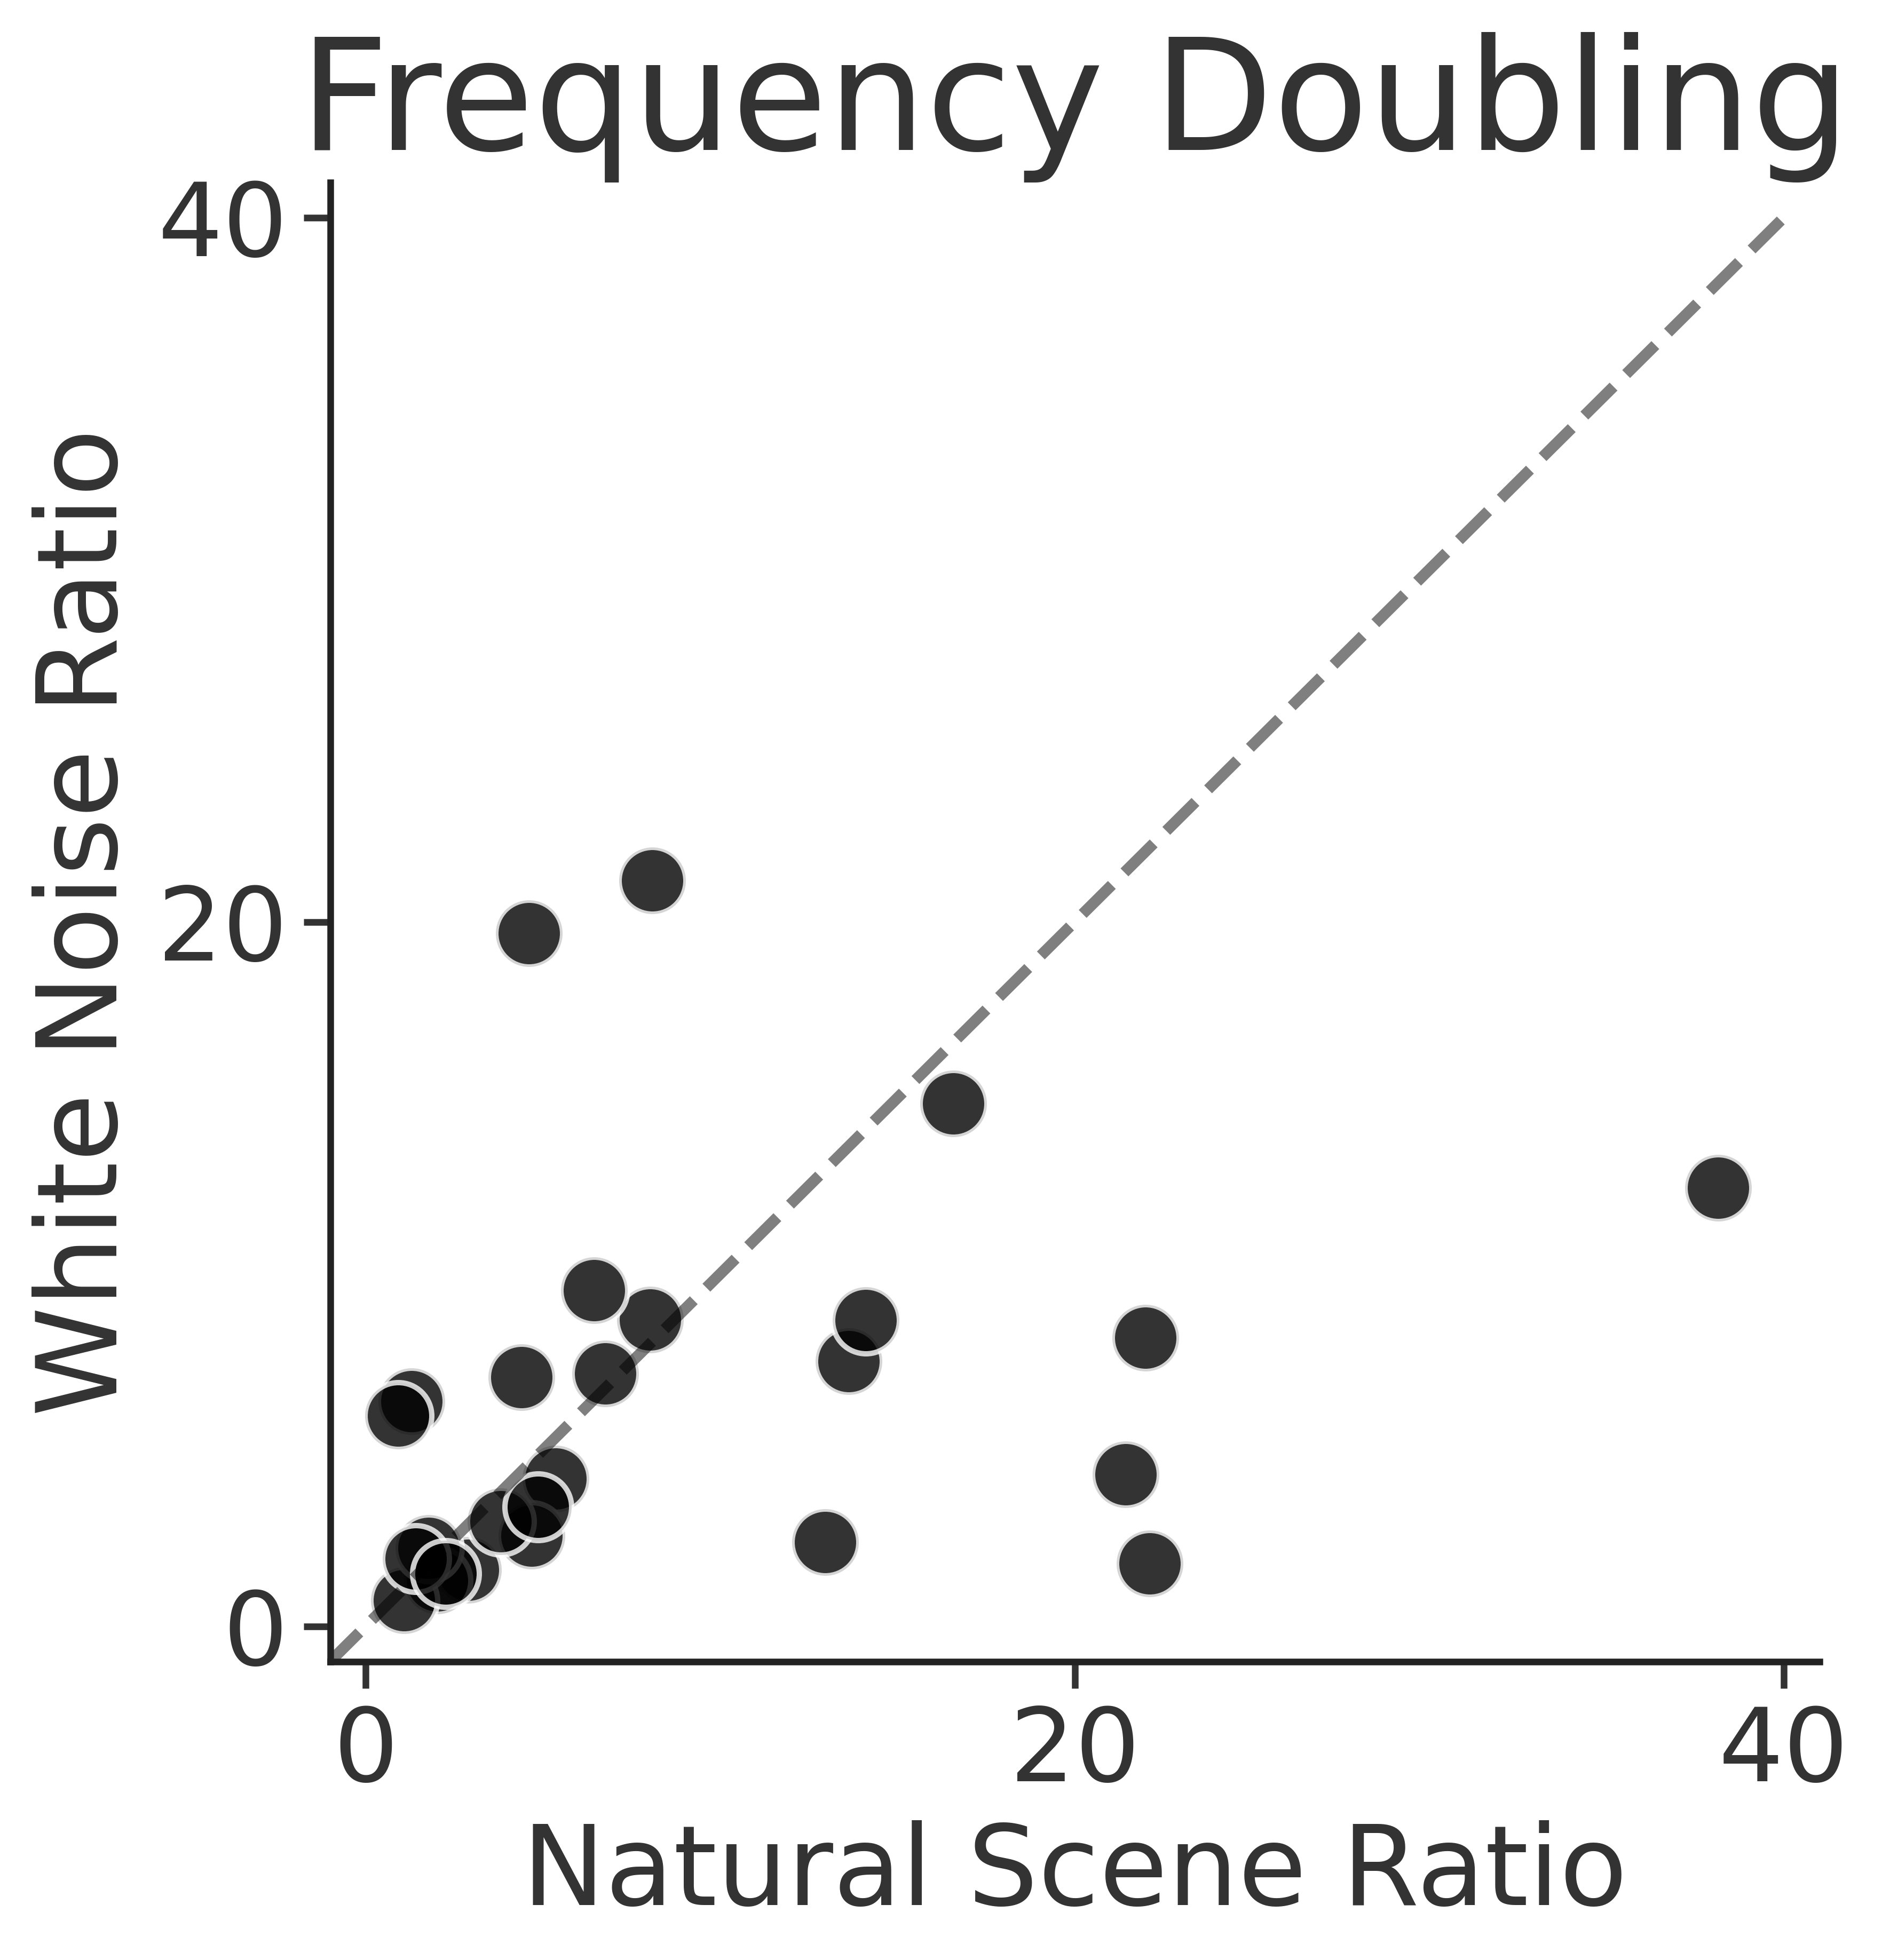

In [28]:
wn_rats = ratios["wn"]
ns_rats = ratios["ns"]
x = []
y = []
for w,n in zip(wn_rats, ns_rats):
    if w is None or n is None: continue
    x.append(n)
    y.append(w)


fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x,y, ax=ax, alpha=alpha, color="black")
ticks = [0,20,40]
plt.xticks(ticks, fontsize=ticksize)
plt.yticks(ticks, fontsize=ticksize)
lim = [-1, 41]
plt.ylim(lim)
plt.xlim(lim)
ax.plot(np.arange(lim[0], lim[1]), np.arange(lim[0], lim[1]), "--k", alpha=0.5)
plt.ylabel("White Noise Ratio", fontsize=fontsize)
plt.xlabel("Natural Scene Ratio", fontsize=fontsize)
plt.title("Frequency Doubling", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "f2"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
save_name = os.path.join(folder, "{}f2_ratioidx{}_scatter".format(prename,rat_idx))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
White Noise model $F_{2}/F_{1}$ ratio plotted against Natural Scenes model $F_{2}/F_{1}$ ratio
for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

# Omitted Stimulus Response

In [14]:
ncells = 5 + 4 + 17                 # Total number of cells.

mtype = "naturalscene"
ns_models = [
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-10-07', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21a', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21b', mtype))),
]

mtype = "whitenoise"
wn_models = [
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-10-07',  mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21a', mtype))),
    tdr.io.load_model(os.path.join(prepath,'convgc_{}_{}.pt'.format('15-11-21b', mtype))),
]

In [15]:
# Generate stimulus.
dt = 10
# interval: delay
# duration: duration of flash
osr_kwargs = {
    "duration": 2,
    "interval": 6,
    "nflashes": 8,
    "intensity": -2,
    "noise_std": 0,
}
X, omt_idx = tdr.retinal_phenomena.osr_stim(**osr_kwargs)
# Responses
t = np.linspace(0, len(X)*dt, len(X))
ns_resp = tdr.retinal_phenomena.sqz(ns_models, X).T
print("Nat:", ns_resp.shape)

wn_resp = tdr.retinal_phenomena.sqz(wn_models, X).T
print("Whit:", wn_resp.shape)



Nat: (26, 142)
Whit: (26, 142)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial Narrow, PT Sans


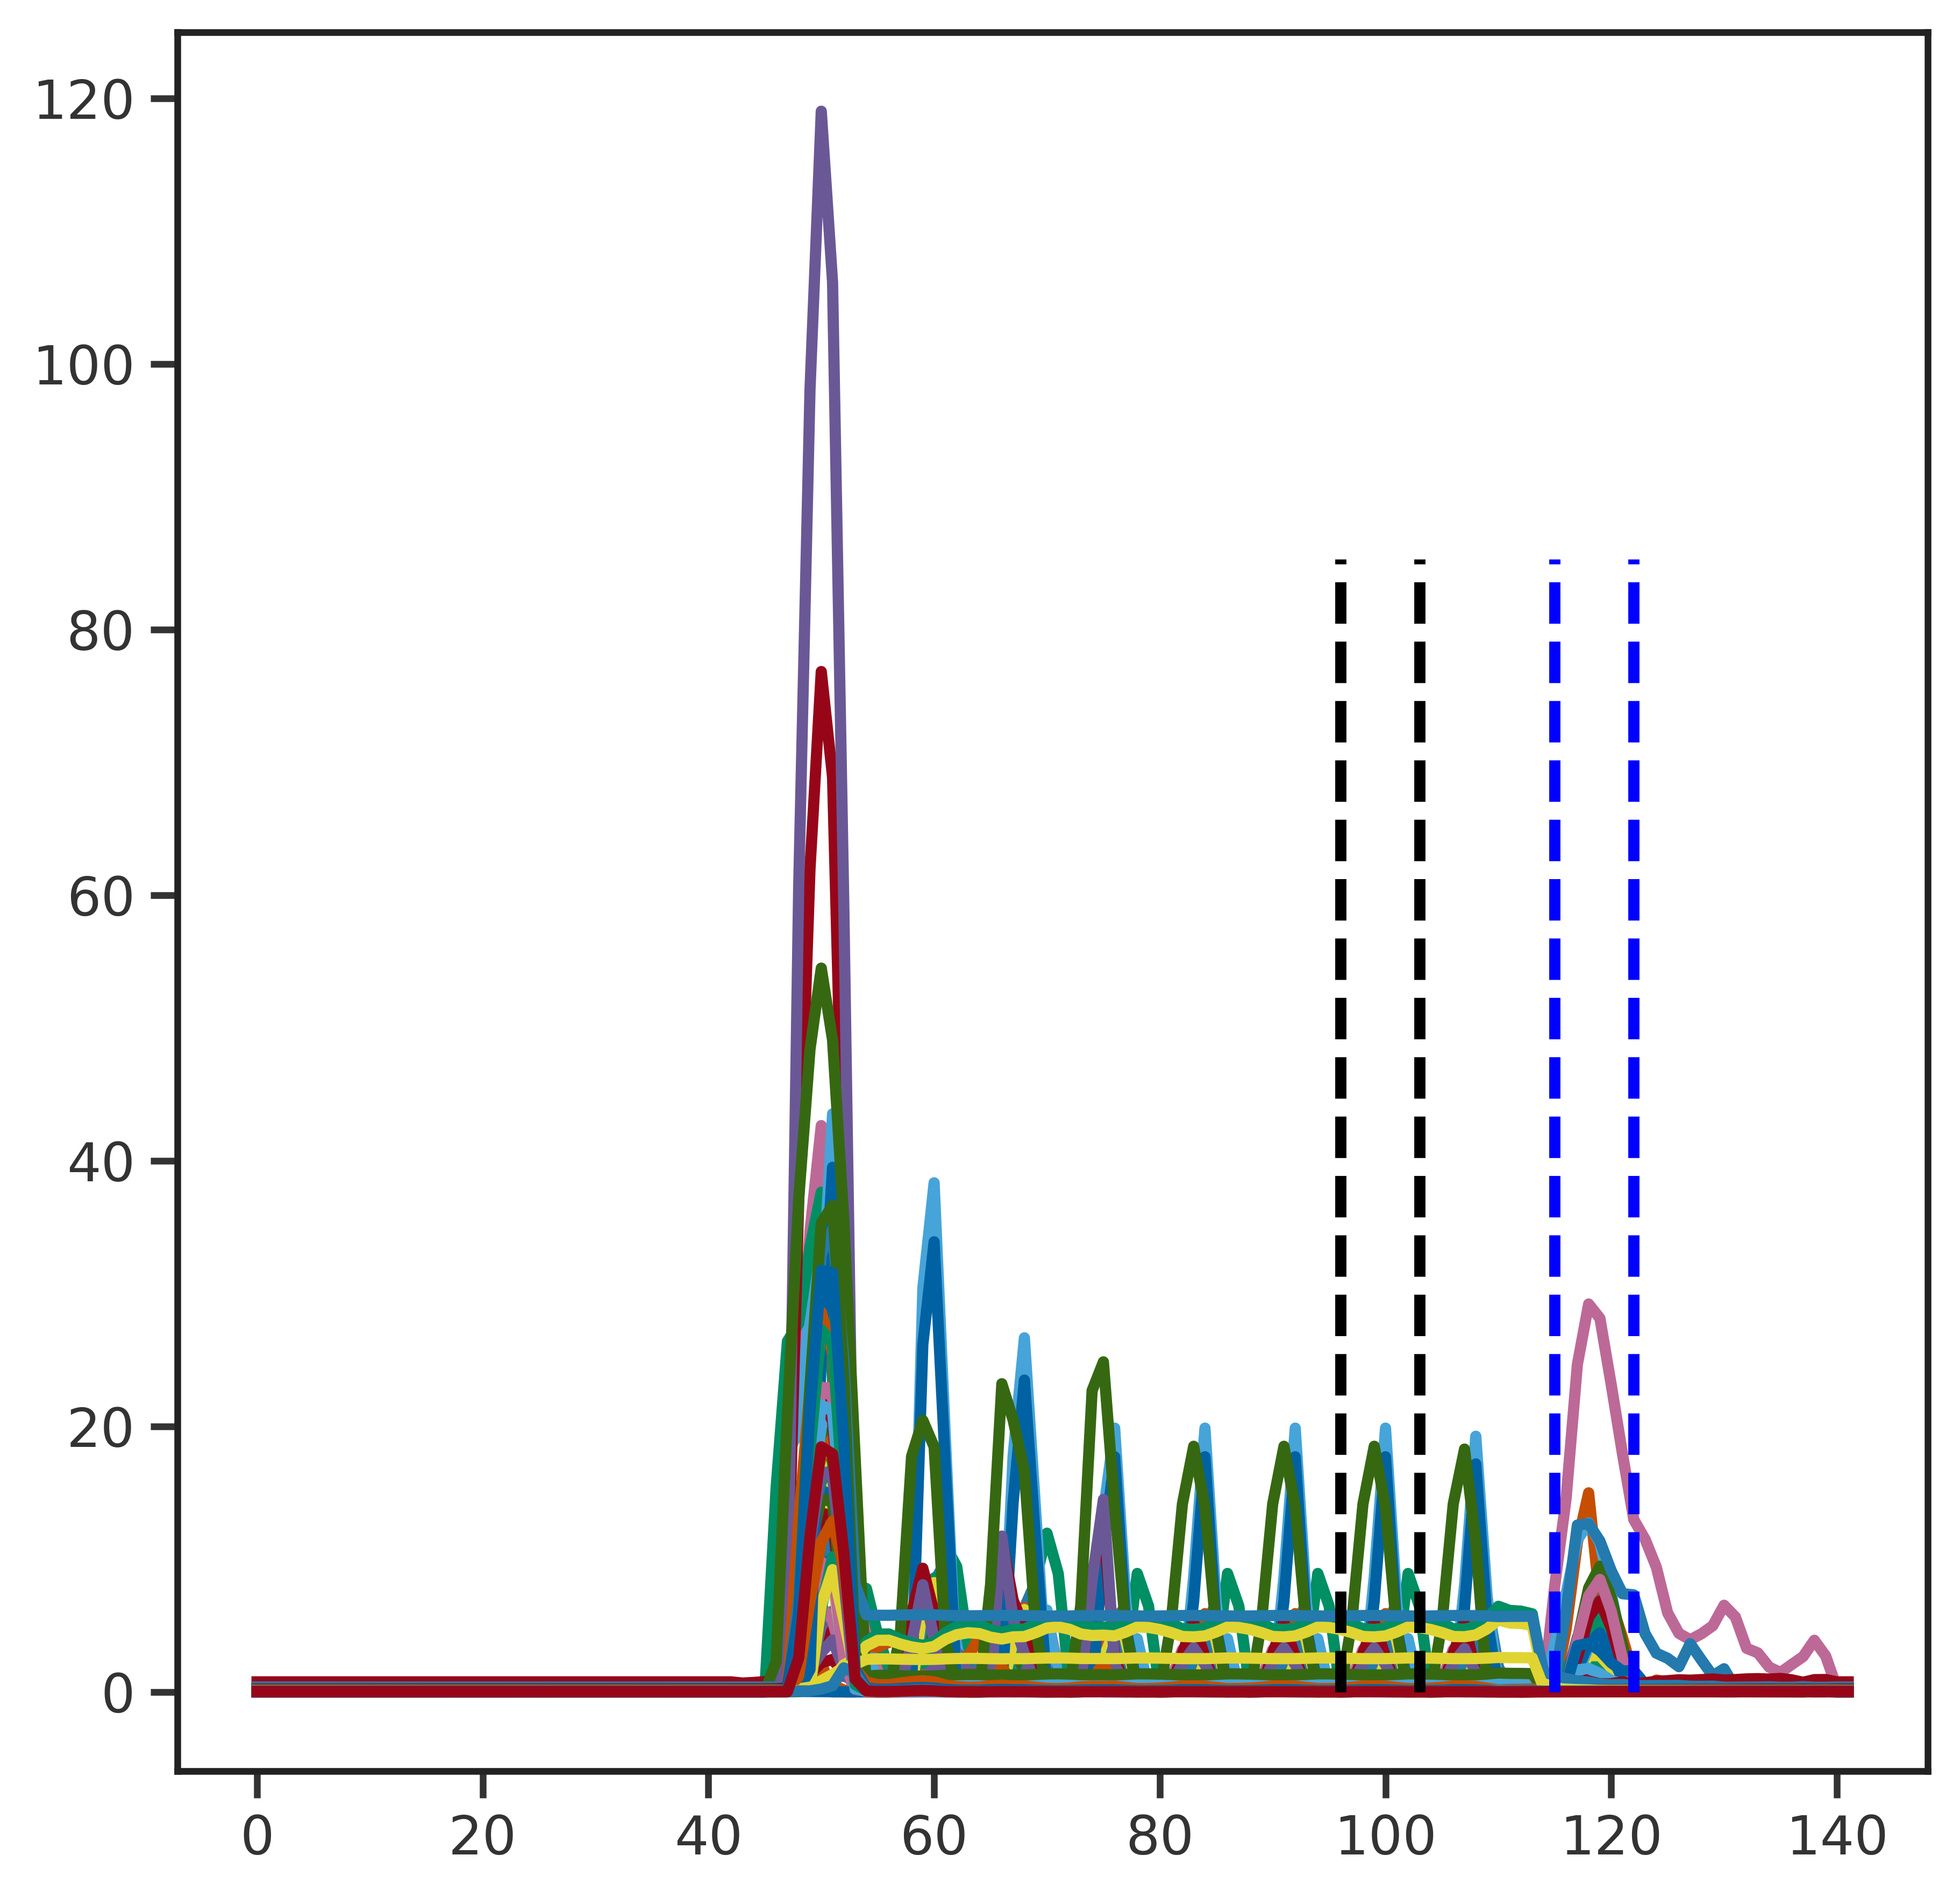

In [16]:
fig = plt.figure(figsize=(7,7))
ax = plt.gca()
x = np.arange(ns_resp.shape[-1])
plt.plot(x, ns_resp.T)
plt.plot(x, wn_resp.T)

offset = 3
peak_width = 7
trough_low = omt_idx-offset-peak_width
trough_high = omt_idx-offset
ax.plot([x[trough_high], x[trough_high]], [0, 2*np.max(ns_resp)], "k--")
ax.plot([x[trough_low], x[trough_low]], [0, 2*np.max(ns_resp)], "k--")

osr_offset = -9
osr_width = -peak_width
peak_low = omt_idx-osr_offset
peak_high = omt_idx-osr_offset-osr_width
ax.plot([x[peak_low], x[peak_low]], [0, 2*np.max(ns_resp)], "b--")
ax.plot([x[peak_high], x[peak_high]], [0, 2*np.max(ns_resp)], "b--")
plt.show()

osr_kwargs = {**osr_kwargs, **{"offset": offset, "peak_width": peak_width, "osr_offset": osr_offset}}

In [17]:
wn_trough = wn_resp[:,trough_low:trough_high].sum(-1)
ns_trough = ns_resp[:,trough_low:trough_high].sum(-1)
wn_peak = wn_resp[:,peak_low:peak_high].sum(-1)
ns_peak = ns_resp[:,peak_low:peak_high].sum(-1)
wn_ratios = wn_peak/wn_trough
ns_ratios = ns_peak/ns_trough

wn_df = pd.DataFrame({
    "trough": wn_trough,
    "peak": wn_peak,
    "Ratio": wn_ratios,
    "cell_idx": np.arange(len(wn_trough)),
})
wn_df["Stim Type"] = "White Noise"

ns_df = pd.DataFrame({
    "trough": ns_trough,
    "peak": ns_peak,
    "Ratio": ns_ratios,
    "cell_idx": np.arange(len(ns_trough)),
})
ns_df["Stim Type"] = "Natural Scenes"

df = pd.concat([wn_df, ns_df], axis=0)
df = df.reset_index()
df

index     trough        peak       Ratio  cell_idx       Stim Type
0       0  36.027504    6.540736    0.181548         0     White Noise
1       1   5.693316    0.559651    0.098300         1     White Noise
2       2   7.074661    0.216036    0.030537         2     White Noise
3       3  29.932795   14.618211    0.488368         3     White Noise
4       4   6.324188   60.099808    9.503165         4     White Noise
5       5  11.705172    5.389987    0.460479         5     White Noise
6       6   8.527331    2.207691    0.258896         6     White Noise
7       7  56.349773    0.146665    0.002603         7     White Noise
8       8   0.327168    0.561027    1.714799         8     White Noise
9       9   0.070686    0.064887    0.917951         9     White Noise
10     10   6.819160    1.372630    0.201290        10     White Noise
11     11  35.879784    3.043355    0.084821        11     White Noise
12     12  31.148355    1.785346    0.057317        12     White Noise
13     13   0.549481    0.201849    0.367344        13     White Noise
14     14  40.181671    5.531259    0.137656        14     White Noise
15     15   0.339155    1.005912    2.965938        15     White Noise
16     16   0.271663    0.114495    0.421459        16     White Noise
17     17   9.208991    0.881683    0.095742        17     White Noise
18     18   2.578510    0.972773    0.377262        18     White Noise
19     19   0.110486    0.117352    1.062149        19     White Noise
20     20   0.690988    0.258927    0.374720        20     White Noise
21     21   0.298955    0.181821    0.608187        21     White Noise
22     22  17.706930    1.165713    0.065834        22     White Noise
23     23   0.939061    0.485791    0.517315        23     White Noise
24     24   0.228303    0.085047    0.372520        24     White Noise
25     25   0.126003    0.078458    0.622670        25     White Noise
26      0  14.252983   12.522025    0.878555         0  Natural Scenes
27      1   4.913200    3.880144    0.789739         1  Natural Scenes
28      2   5.266668    4.493879    0.853268         2  Natural Scenes
29      3   7.699244    9.831088    1.276890         3  Natural Scenes
30      4  10.954093   43.511356    3.972155         4  Natural Scenes
31      5   8.335911  145.656998   17.473434         5  Natural Scenes
32      6   5.096760   57.155476   11.214081         6  Natural Scenes
33      7  12.686723    9.926657    0.782445         7  Natural Scenes
34      8   0.451932    9.986179   22.096666         8  Natural Scenes
35      9   0.106329   28.306158  266.213318         9  Natural Scenes
36     10   2.402773    3.074878    1.279721        10  Natural Scenes
37     11   2.549038   14.890447    5.841594        11  Natural Scenes
38     12   3.629708    0.252531    0.069573        12  Natural Scenes
39     13   0.214423    0.221551    1.033244        13  Natural Scenes
40     14   4.805239   30.571743    6.362169        14  Natural Scenes
41     15   0.463763   19.386353   41.802265        15  Natural Scenes
42     16   0.077415   12.945271  167.219757        16  Natural Scenes
43     17   0.476184   18.296347   38.422874        17  Natural Scenes
44     18   0.412717    2.815240    6.821236        18  Natural Scenes
45     19   0.089359   13.880990  155.339645        19  Natural Scenes
46     20   0.107176   24.087954  224.750732        20  Natural Scenes
47     21   0.143800   22.213045  154.471771        21  Natural Scenes
48     22   2.581792    1.256632    0.486729        22  Natural Scenes
49     23   0.187809   32.575726  173.451675        23  Natural Scenes
50     24   0.193823    0.339082    1.749441        24  Natural Scenes
51     25   0.087566   28.915501  330.215363        25  Natural Scenes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


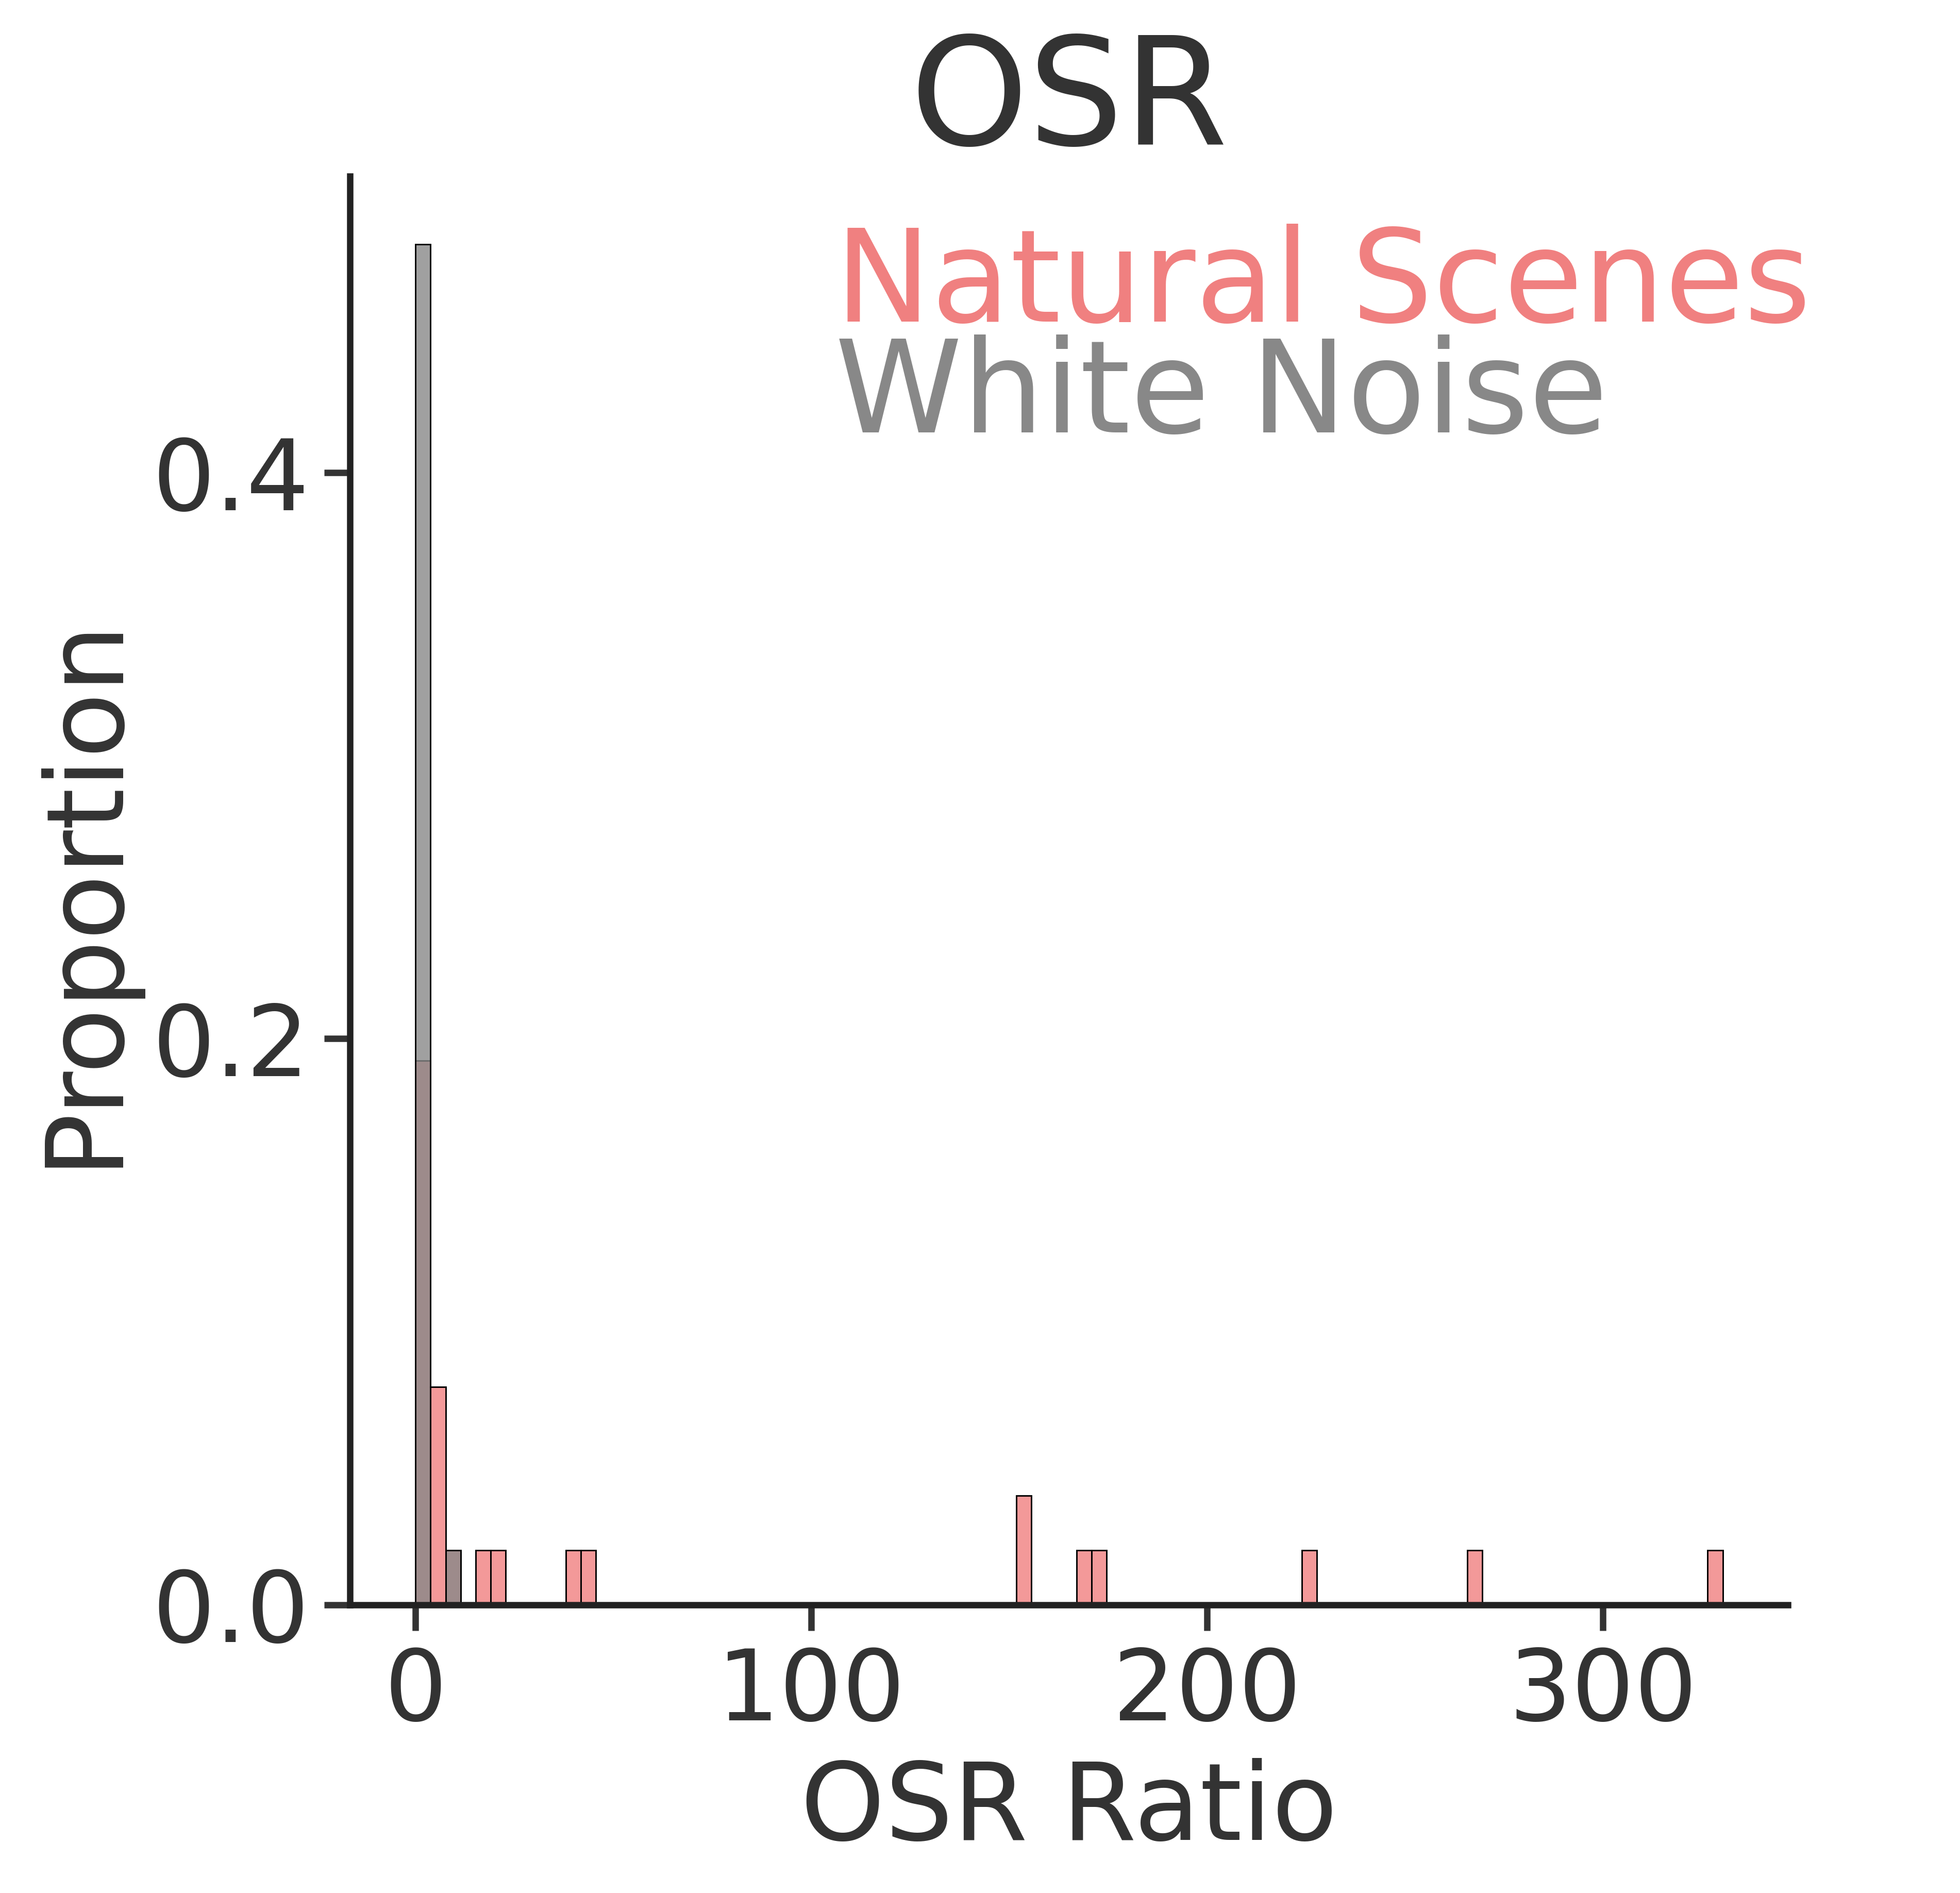

In [18]:
fontsize = 25
titlesize = 35
ticksize = 23
binwidth = 1
annotesize = 30
alpha = 0.8

fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.histplot(x="Ratio", data=df, stat="proportion", hue="Stim Type", ax=ax,
             palette={"White Noise": whit_color, "Natural Scenes": nat_color}, alpha=alpha)
#ylim = [0,0.6]
#yticks = [i/10 for i in range(0, int(ylim[1]*10)+1, 3)]
#plt.yticks(yticks, fontsize=ticksize)
#plt.xticks([-8, -4, 0], fontsize=ticksize)
#plt.ylim(ylim)
plt.ylabel("Proportion", fontsize=fontsize)
plt.xlabel("OSR Ratio", fontsize=fontsize)
plt.title("OSR", fontsize=titlesize)
plt.legend().set_visible(False)
xpos = 0.45
ypos = 0.84
ax.annotate('White Noise', xy=(xpos, ypos), #xycoords='axes points',
            xycoords="figure fraction",
            size=annotesize, ha='left', va='top',
            bbox=None,
            color=whit_color)
            
ax.annotate('Natural Scenes', xy=(xpos, ypos+0.06), #xycoords='axes points',
            xycoords="figure fraction",
            size=annotesize, ha='left', va='top',
            bbox=None,
            color=nat_color)
            
plt.locator_params(nbins=4)
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "osr"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
params = "_".join([k+str(v) for k,v in osr_kwargs.items()])
save_name = os.path.join(folder, "{}osr_{}_hist".format(prename,params))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
Histogram of individual cell omitted stimulus response (OSR) ratios. Each ratio
is calculated as the peak of the OSR to the peak at the onset of the last stimulus
flash.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")

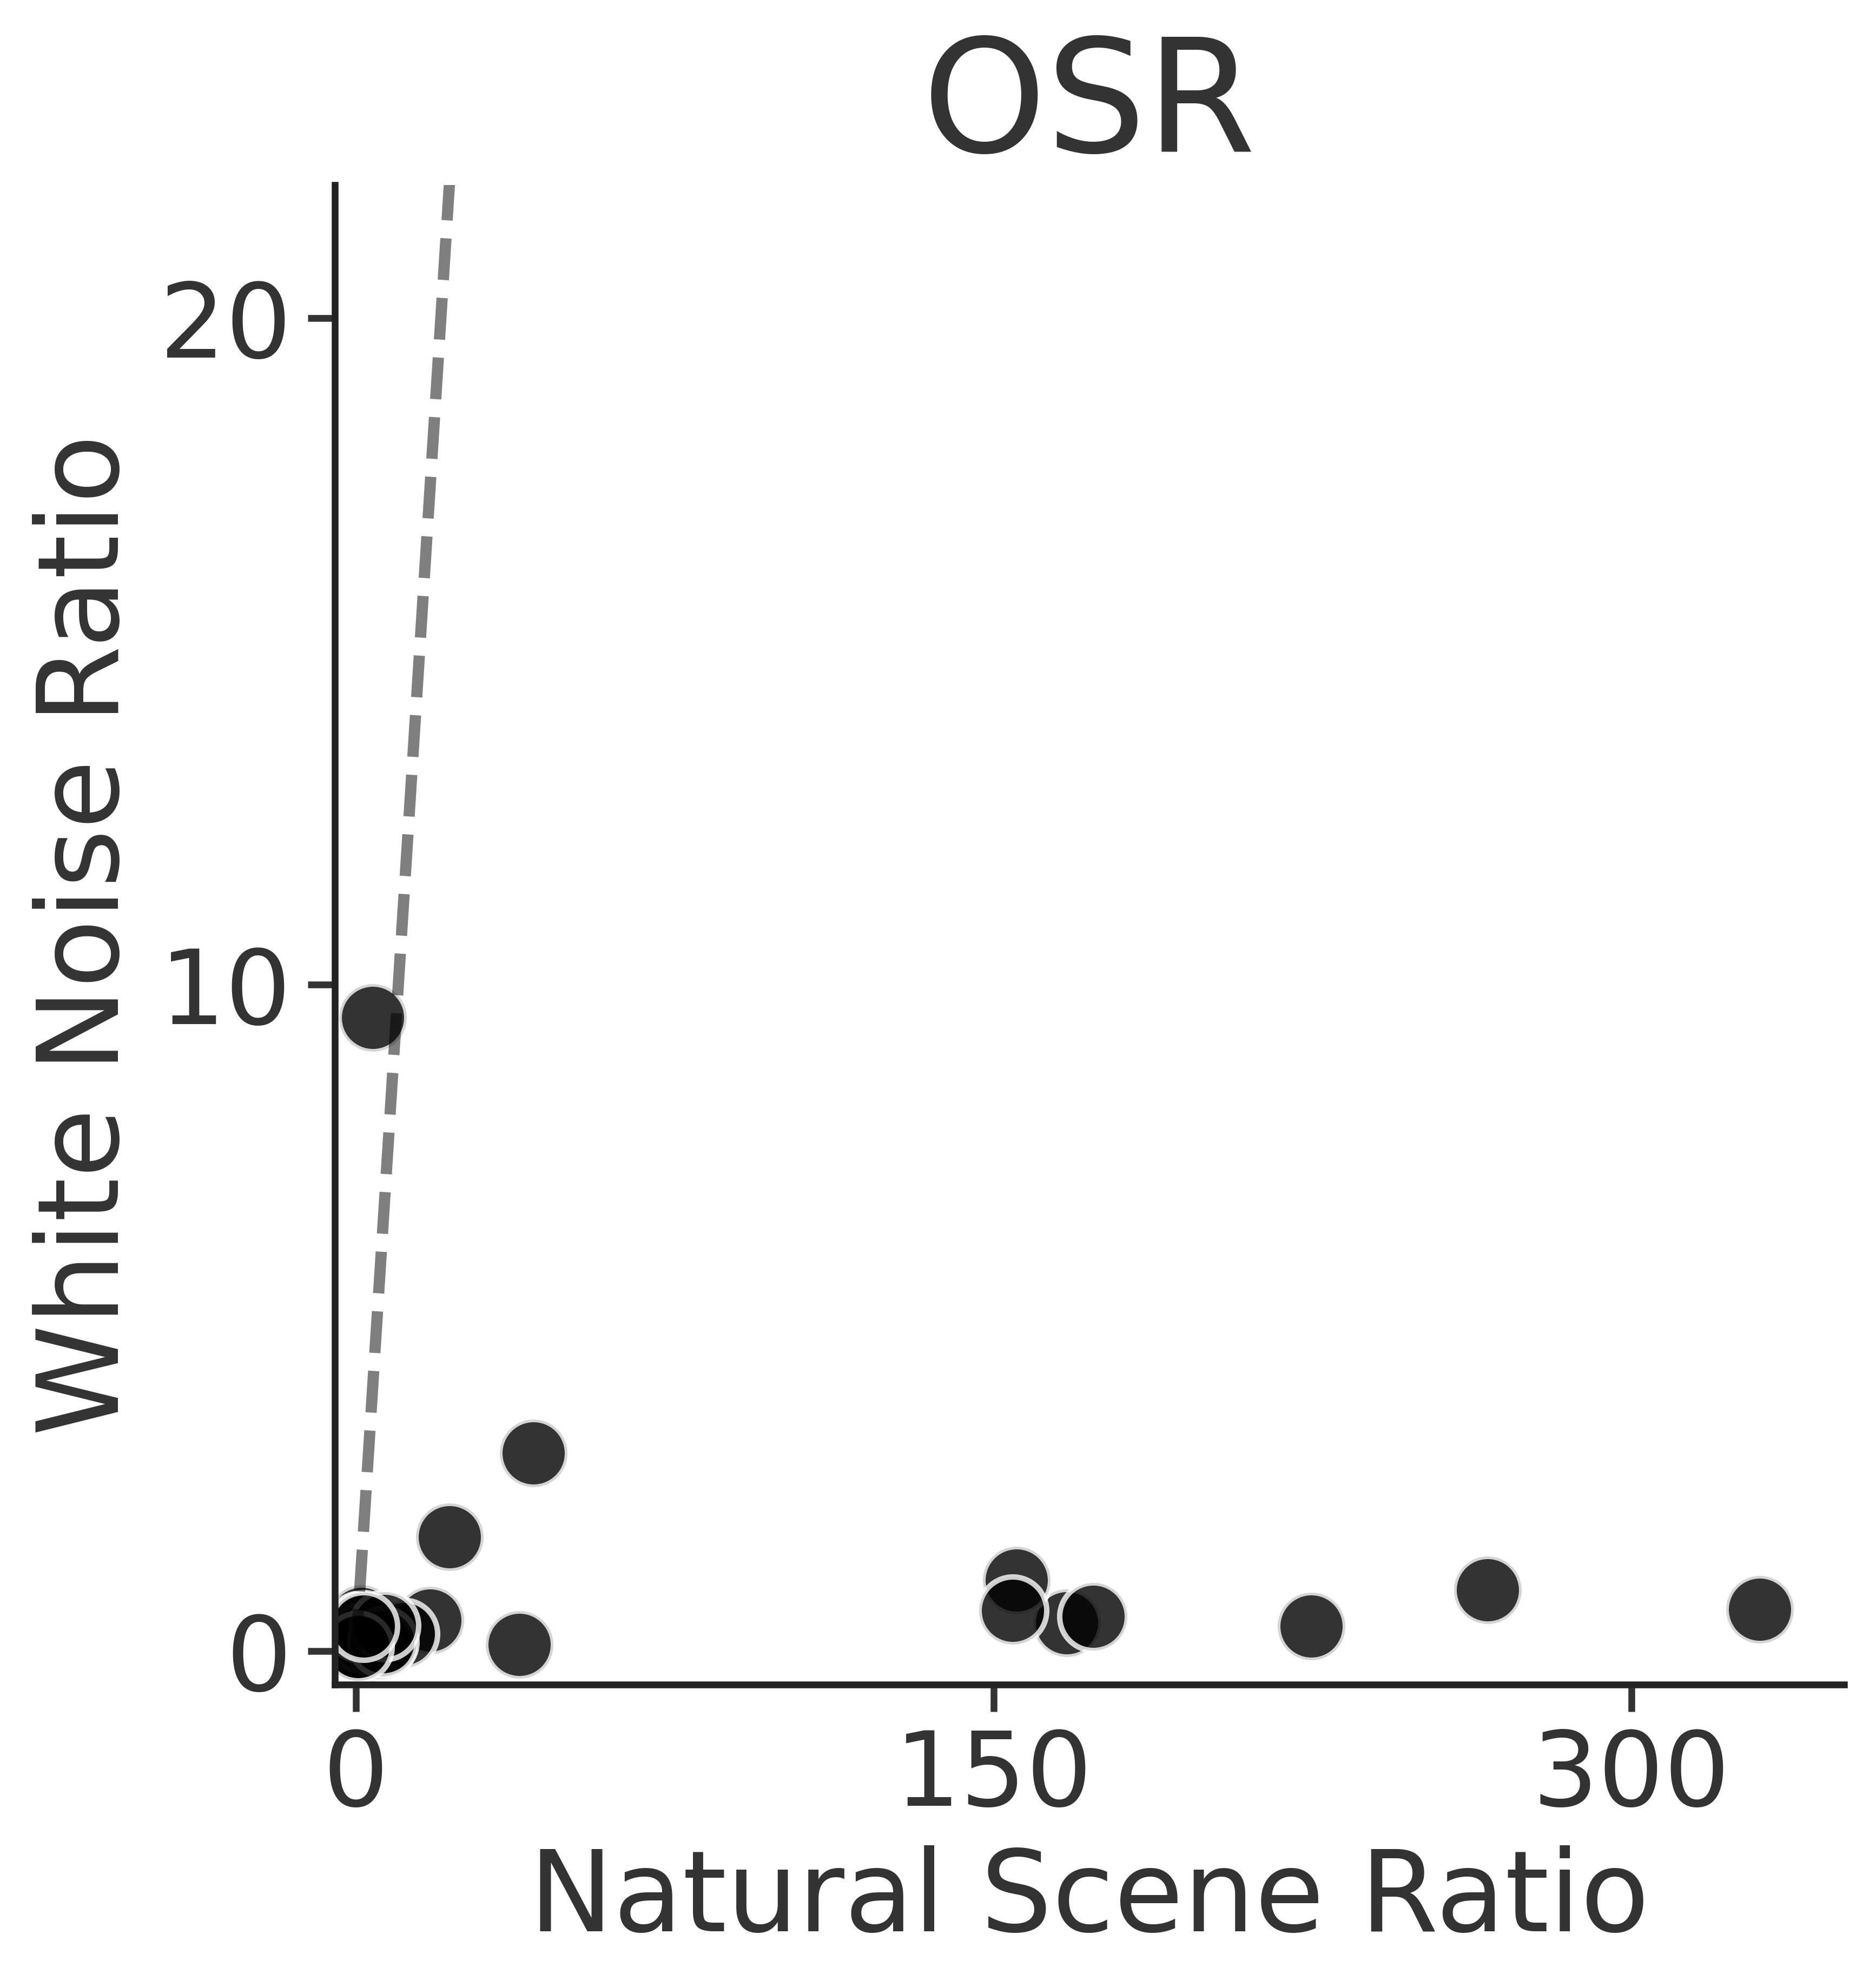

In [21]:
df = df.sort_values(by="cell_idx")
wn_rats = np.asarray(df.loc[df["Stim Type"]=="White Noise"]["Ratio"])
ns_rats = np.asarray(df.loc[df["Stim Type"]=="Natural Scenes"]["Ratio"])
x = []
y = []
for w,n in zip(wn_rats, ns_rats):
    if w is None or n is None: continue
    x.append(n)
    y.append(w)


fig = plt.figure(figsize=(6,6))

ax = plt.gca()
sns.scatterplot(x,y, ax=ax, alpha=alpha, color="black")
xlim = [-5,350]
xticks = [0,150,300]
plt.xticks(xticks, fontsize=ticksize)
ylim = [-0.5,22]
yticks = [0,10,20]
plt.yticks(yticks, fontsize=ticksize)
plt.ylim(ylim)
plt.xlim(xlim)
ax.plot(np.arange(50), np.arange(50), "--k", alpha=0.5)
plt.ylabel("White Noise Ratio", fontsize=fontsize)
plt.xlabel("Natural Scene Ratio", fontsize=fontsize)
plt.title("OSR", fontsize=titlesize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


folder_name = "osr"
folder = os.path.join(savefolder, folder_name)
if not os.path.exists(folder):
    os.makedirs(folder)
params = "_".join([k+str(v) for k,v in osr_kwargs.items()])
save_name = os.path.join(folder, "{}osr_{}_scatter".format(prename,params))
plt.savefig(save_name + ".png", bbox_inches="tight")
plt.savefig(save_name + ".pdf", bbox_inches="tight")
plt.show()

captions[folder_name][save_name.split("/")[-1]] = """
White Noise model OSR peak/trough ratio plotted against Natural Scenes model OSR ratio
for each cell.
"""

with open(os.path.join(folder, caption_file), "w") as f:
    for k,v in captions[folder_name].items():
        f.write(k+":\n")
        f.write(v+"\n\n")